## Libraries and options


In [ ]:
library(data.table)
library(glue)
library(dplyr)
library(plotly)
library(ggplot2)
library(grid)
library(gridExtra)
options(scipen=999)

## Load and prepare data

In [2]:
# Read input VCF
tgp_vcf <- fread("/home/matdawidziuk/tgp_pl/multisample_20210519.dv.bcfnorm.filtered.nogt.vcf.gz", skip="#CHROM", sep="\t")

In [ ]:
# Check dim
dim(tgp_vcf)
head(tgp_vcf)

In [4]:
# Read TGP vep annotated file
tgp_vep <- fread("/data/NGS/annotations/test_design/pl_genomes/run_1/output/multisample_20210519.dv.bcfnorm.filtered.nogt.header.format.dummygt_VEP.tsv", sep="\t")

In [ ]:
# Check dim
dim(tgp_vep)
head(tgp_vep)

In [6]:
#  Split INFO
tgp_vcf[, c("AF", "AQ", "AN", "AC") := tstrsplit(INFO, ";", fixed=TRUE)]

In [7]:
# Clean new columns, remove AQ (duplicates QUAL)
tgp_vcf[, AF := gsub("[^0-9.-]", "", AF)][, AN := gsub("[^0-9.-]", "", AN)][, AC := gsub("[^0-9.-]", "", AC)][, AQ := NULL]

In [ ]:
head(tgp_vcf)

In [9]:
# Create key - further used to merge with VCF file
tgp_vep[, key2 := gsub(">", "_", gsub(":", "_", key))]
setkey(tgp_vep, key2)
setkey(tgp_vcf, ID)

In [ ]:
# Copy selected columns from VCF to TSV
selected_columns <- c("REF", "ALT", "QUAL", "AF", "AN", "AC")
tgp_vep[tgp_vcf, (selected_columns) := mget(paste0('i.', selected_columns))]
head(tgp_vep)

In [17]:
#save(tgp_vep, file="~/tgp_vep_2021_06_26.RData")

In [22]:
dim(tgp_vep)

[1] 37318044      154

In [20]:
# Read AR genes from OMIM
omim_recessive <- fread("/srv/data/TGP-notebooks/recessive_genes.bed", sep="\t", col.names=c("chr", "start", "end", "symbol"))
omim_recessive <- unique(omim_recessive, by = "symbol")

In [24]:
tgp_recessive <- tgp_vep[which((Symbol %in% omim_recessive$symbol) & AC!=0)]

In [25]:
tgp_vep_nonsyn_rare <- tgp_recessive[which( gnomAD_AF < 0.01 & AF < 0.01 & Impact %in% c("MODERATE", "HIGH"))]

In [28]:
#save(tgp_vep_nonsyn_rare,file="~/tgp_vep_nonsyn_rare_2021_06_27.RData" )
#save(tgp_recessive,file="~/tgp_recessive_2021_06_27.RData" )

In [30]:
gnomad_vep <- fread("/data/NGS/annotations/test_design/pl_genomes/run_1/output/gnomad_genome_v3.0_gt_subset-gatk-haplotype.vcf.gz.annotated.tsv", skip="#Uploaded_variation")

In [35]:
gnomad_vep[, gnomAD_AF := as.numeric(gnomad_vep$gnomad_genome.vcf.gz_AF)]
gnomad_vep[, gnomAD_AF_NFE := as.numeric(gnomad_vep$gnomad_genome.vcf.gz_AF_nfe)]
gnomad_vep[, gnomAD_AF:=ifelse(is.na(gnomAD_AF),0,gnomAD_AF)]
gnomad_vep[, gnomAD_AF_NFE:=ifelse(is.na(gnomAD_AF_NFE),0,gnomAD_AF_NFE)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [43]:
gnomad_nonsyn_rare <- gnomad_vep[which( gnomAD_AF < 0.01 & IMPACT %in% c("MODERATE", "HIGH"))]

In [45]:
idx_duplicated <- which(duplicated(gnomad_nonsyn_rare$key))
gnomad_nonsyn_rare <- gnomad_nonsyn_rare[-idx_duplicated,]
dim(gnomad_nonsyn_rare)
#save(gnomad_nonsyn_rare,file="~/gnomad_nonsyn_rare_2021_06_27.RData" )

## Download PanelApp data

In [46]:

#install.packages("rvest")
library(rvest)
panels <- read_html("https://panelapp.genomicsengland.co.uk/panels/")
panels2 <- panels %>%html_nodes("h4")
allPanelsList <- (lapply(panels2[-length(panels2)], function(panel){
    panelURL <- paste0("https://panelapp.genomicsengland.co.uk",panel%>% html_nodes("a") %>%  html_attr("href") ,"download/01234/")
    print(panelURL)
    fread(panelURL)
}))
allPanelsDT <- rbindlist(allPanelsList)
idx <- grep ("Expert Review Green", allPanelsDT$"Sources(; separated)" )
allPanelsDT2 <- allPanelsDT[idx,]
allPanelsDT3 <- allPanelsDT2[grep("BIALLELIC", allPanelsDT2$Model_Of_Inheritance),]

[1] "https://panelapp.genomicsengland.co.uk/panels/399/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/933/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/929/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/930/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/934/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/931/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/932/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/774/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/540/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/245/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/391/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/511/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/269/download/01234/"
[1] "https://panelapp.genomicsengland.co.uk/panels/502/download/

In [51]:
#gnomad_nonsyn_rare$panelApp <- NA
#gnomad_nonsyn_rare$panelApp <- allPanelsDT3$Level4[match(gnomad_nonsyn_rare$SYMBOL, allPanelsDT3$"Gene Symbol")]


In [173]:
#head(gnomad_nonsyn_rare)

In [119]:
gnomad_nonsyn_rare[,key:=paste0(Location, ":", REF_ALLELE, ">", Allele)]

In [172]:
#head(gnomad_nonsyn_rare)

## Calculate cumulative frequencies

In [102]:
gnomad_nonsyn_rare[, CADD_phred:=as.numeric(CADD_phred)]
gnomad_nonsyn_rare[, CADD_phred:=ifelse(is.na(CADD_phred),0,CADD_phred)]


Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [164]:
calculateCumFreq <- function(tgp_clinvar, gnomad_clinvar){
    
    tgp_clinvar[, cum_AF := sum(as.numeric(AF)), by=Symbol]
    tgp_clinvar[, cum_AF2 := cum_AF^2]
    tgp_clinvar_unique <- tgp_clinvar[-which(duplicated(tgp_clinvar[,"Symbol",with=F])),]
    tgp_clinvar_unique <- tgp_clinvar_unique[order(cum_AF2, decreasing =TRUE), c("Symbol", "cum_AF", "cum_AF2"),with=F]


    gnomad_clinvar[, cum_gnomAD_AF := sum(as.numeric(gnomAD_AF)), by=SYMBOL]
    gnomad_clinvar[, cum_gnomAD_AF2 := cum_gnomAD_AF^2]
    gnomad_clinvar[, cum_gnomAD_AF_NFE := sum(as.numeric(gnomAD_AF_NFE)), by=SYMBOL]
    gnomad_clinvar[, cum_gnomAD_AF2_NFE := cum_gnomAD_AF_NFE^2]
    gnomad_clinvar_unique <- gnomad_clinvar[-which(duplicated(gnomad_clinvar[,"SYMBOL",with=F])),]
    gnomad_clinvar_unique <- gnomad_clinvar_unique[order(cum_gnomAD_AF2, decreasing =TRUE), c("SYMBOL", "cum_gnomAD_AF", "cum_gnomAD_AF2", "cum_gnomAD_AF_NFE", "cum_gnomAD_AF2_NFE"),with=F]
    list(tgp_clinvar_unique,gnomad_clinvar_unique )
}


tgp_clinvar <-  tgp_vep_nonsyn_rare[which(CLNSIG %in% c("Pathogenic", "Pathogenic/Likely_pathogenic", "Likely_pathogenic"))]
gnomad_clinvar  <- gnomad_nonsyn_rare[which(clinvar.vcf.gz_CLNSIG %in% c("Pathogenic", "Pathogenic/Likely_pathogenic", "Likely_pathogenic"))]
rr <- calculateCumFreq (tgp_clinvar, gnomad_clinvar)
tgp_clinvar_unique <- rr[[1]]
gnomad_clinvar_unique <- rr[[2]]                      

tgp_cadd <-  tgp_vep_nonsyn_rare[which(CADD_phred > 20)]
gnomad_cadd  <- gnomad_nonsyn_rare[which(CADD_phred > 20)]
rr1 <- calculateCumFreq (tgp_cadd, gnomad_cadd)
tgp_cadd_unique <- rr1[[1]]
gnomad_cadd_unique <- rr1[[2]]                      


In [165]:
dim(tgp_clinvar_unique)
dim(gnomad_clinvar_unique)

[1] 466   3

[1] 1919    5

In [166]:
tgp_clinvar_unique$cum_gnomad_AF2 <- gnomad_clinvar_unique$cum_gnomAD_AF2[match(tgp_clinvar_unique$Symbol,gnomad_clinvar_unique$SYMBOL )]
tgp_clinvar_unique$cum_gnomad_AF2_NFE <- gnomad_clinvar_unique$cum_gnomAD_AF2_NFE[match(tgp_clinvar_unique$Symbol,gnomad_clinvar_unique$SYMBOL )]

tgp_cadd_unique$cum_gnomad_AF2 <- gnomad_cadd_unique$cum_gnomAD_AF2[match(tgp_cadd_unique$Symbol,gnomad_cadd_unique$SYMBOL )]
tgp_cadd_unique$cum_gnomad_AF2_NFE <- gnomad_cadd_unique$cum_gnomAD_AF2_NFE[match(tgp_cadd_unique$Symbol,gnomad_cadd_unique$SYMBOL )]

In [167]:
dim(gnomad_clinvar_unique)

[1] 1919    5

### Cum frequency differences
* Difference of cumulative frequencies between Polish and GnomAD (first column) and Polish and NFE  (second columns)
* Cumulative frequencies have been calculated for pathogenic and likely pathogenic clinvar variants (first row) and for predicted deleterious (CADD >20) variants (second row)


Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_text).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_text).”Warning message:
“Removed 11 rows containing missing values (geom_point).”Warning message:
“Removed 11 rows containing missing values (geom_text).”Warning message:
“Removed 5 rows containing missing values (geom_point).”Warning message:
“Removed 5 rows containing missing values (geom_text).”

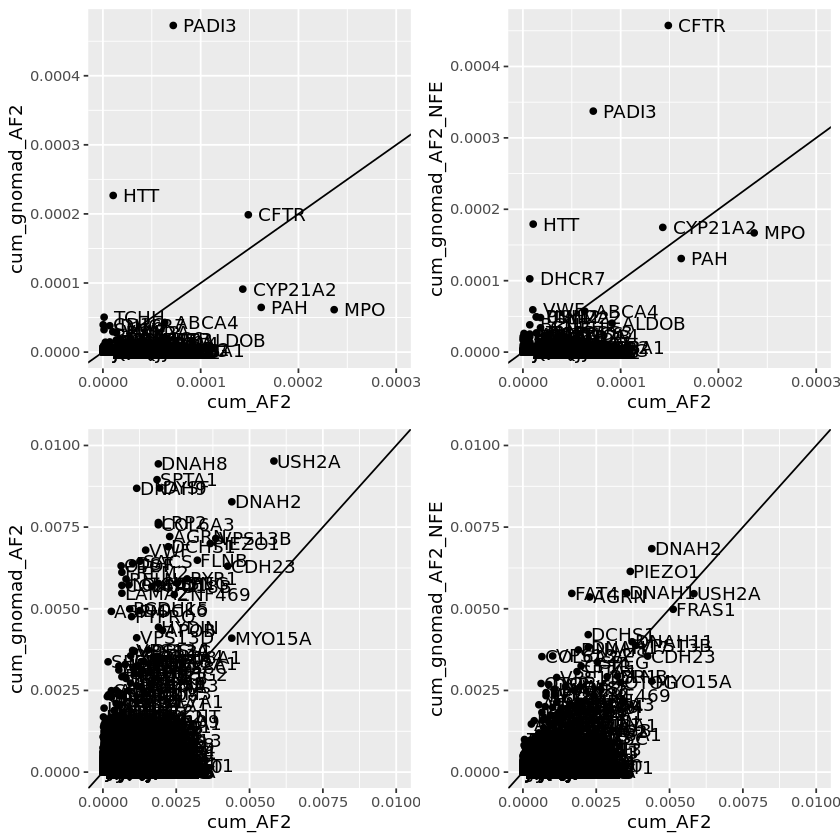

In [171]:
p1 <- ggplot(tgp_clinvar_unique, aes(cum_AF2, cum_gnomad_AF2)) +
    geom_point() +
     geom_text(aes(label = Symbol),hjust = 0, nudge_x = 0.00001)+ 
    geom_abline()+
      xlim(0, 0.0003) 
p2 <- ggplot(tgp_clinvar_unique, aes(cum_AF2, cum_gnomad_AF2_NFE)) +
    geom_point() +
    geom_text(aes(label = Symbol),hjust = 0, nudge_x = 0.00001) + 
    geom_abline()+
    xlim(0, 0.0003) 

p3 <- ggplot(tgp_cadd_unique, aes(cum_AF2, cum_gnomad_AF2)) +
    geom_point() +
     geom_text(aes(label = Symbol),hjust = 0, nudge_x = 0.0001)+ 
    geom_abline()+ xlim(0, 0.01) + ylim(0, 0.01) 

p4 <- ggplot(tgp_cadd_unique, aes(cum_AF2, cum_gnomad_AF2_NFE)) +
    geom_point() +
    geom_text(aes(label = Symbol),hjust = 0, nudge_x = 0.0001) + 
    geom_abline()+ xlim(0, 0.01) + ylim(0, 0.01) 

    
grid.arrange(p1, p2,p3,p4, nrow = 2)

In [180]:
allPanelsDT3$clinvar_cum_AF2 <- tgp_clinvar_unique$cum_AF2[match(allPanelsDT3$"Gene Symbol",tgp_clinvar_unique$Symbol )]
allPanelsDT3$clinvar_cum_gnomad_AF2 <- tgp_clinvar_unique$cum_gnomad_AF2[match(allPanelsDT3$"Gene Symbol",tgp_clinvar_unique$Symbol )]
allPanelsDT3$clinvar_cum_gnomad_AF2_NFE <- tgp_clinvar_unique$cum_gnomad_AF2_NFE[match(allPanelsDT3$"Gene Symbol",tgp_clinvar_unique$Symbol )]

allPanelsDT3$cadd_cum_AF2 <- tgp_cadd_unique$cum_AF2[match(allPanelsDT3$"Gene Symbol",tgp_cadd_unique$Symbol )]
allPanelsDT3$cadd_cum_gnomad_AF2 <- tgp_cadd_unique$cum_gnomad_AF2[match(allPanelsDT3$"Gene Symbol",tgp_cadd_unique$Symbol )]
allPanelsDT3$cadd_cum_gnomad_AF2_NFE <- tgp_cadd_unique$cum_gnomad_AF2_NFE[match(allPanelsDT3$"Gene Symbol",tgp_cadd_unique$Symbol )]


In [201]:
allPanelsDT3[,clinvar_cum_AF2_sum:=sum(clinvar_cum_AF2, na.rm=T), by=Level4]
allPanelsDT3[,clinvar_cum_gnomad_AF2_sum:=sum(clinvar_cum_gnomad_AF2, na.rm=T), by=Level4]
allPanelsDT3[,clinvar_cum_gnomad_AF2_NFE_sum:=sum(clinvar_cum_gnomad_AF2_NFE, na.rm=T), by=Level4]

allPanelsDT3[,cadd_cum_AF2_sum:=sum(cadd_cum_AF2, na.rm=T), by=Level4]
allPanelsDT3[,cadd_cum_gnomad_AF2_sum:=sum(cadd_cum_gnomad_AF2, na.rm=T), by=Level4]
allPanelsDT3[,cadd_cum_gnomad_AF2_NFE_sum:=sum(cadd_cum_gnomad_AF2_NFE, na.rm=T), by=Level4]
allPanelsDT3_unique <- allPanelsDT3[-which(duplicated(Level4)),]
allPanelsDT3_unique$Symbol <- allPanelsDT3_unique$"Gene Symbol"

Warning message:
“Removed 90 rows containing missing values (geom_point).”Warning message:
“Removed 90 rows containing missing values (geom_text).”Warning message:
“Removed 47 rows containing missing values (geom_point).”Warning message:
“Removed 47 rows containing missing values (geom_text).”

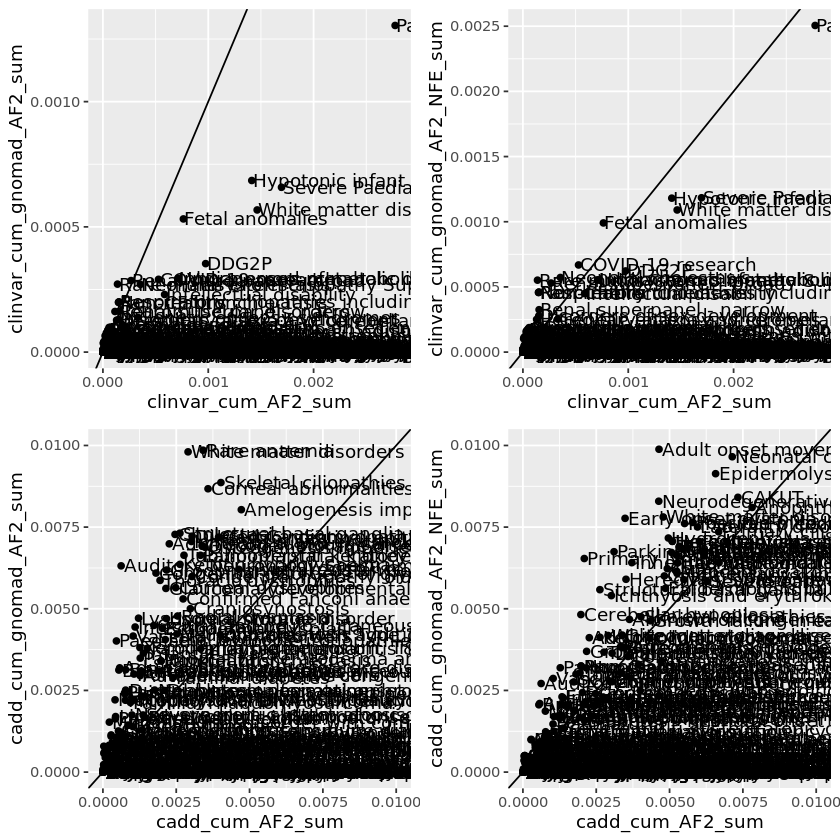

In [204]:
p1 <- ggplot(allPanelsDT3_unique, aes(clinvar_cum_AF2_sum, clinvar_cum_gnomad_AF2_sum)) +
    geom_point() +
     geom_text(aes(label = Level4),hjust = 0, nudge_x = 0.00001)+ 
    geom_abline()
      #xlim(0, 0.0003) 
p2 <- ggplot(allPanelsDT3_unique, aes(clinvar_cum_AF2_sum, clinvar_cum_gnomad_AF2_NFE_sum)) +
    geom_point() +
    geom_text(aes(label = Level4),hjust = 0, nudge_x = 0.00001) + 
    geom_abline()
    #xlim(0, 0.0003) 

p3 <- ggplot(allPanelsDT3_unique, aes(cadd_cum_AF2_sum, cadd_cum_gnomad_AF2_sum)) +
    geom_point() +
     geom_text(aes(label = Level4),hjust = 0, nudge_x = 0.0001)+ 
    geom_abline()+ xlim(0, 0.01) + ylim(0, 0.01) 

p4 <- ggplot(allPanelsDT3_unique, aes(cadd_cum_AF2_sum, cadd_cum_gnomad_AF2_NFE_sum)) +
    geom_point() +
    geom_text(aes(label = Level4),hjust = 0, nudge_x = 0.0001) + 
    geom_abline()+ xlim(0, 0.01) + ylim(0, 0.01) 

    
grid.arrange(p1, p2,p3,p4, nrow = 2)

### Estimated disease prelevance in gene panels (from geneApp)


Warning message in split.default(1:nrow(allPanelsDT3_unique), 1:10):
“data length is not a multiple of split variable”

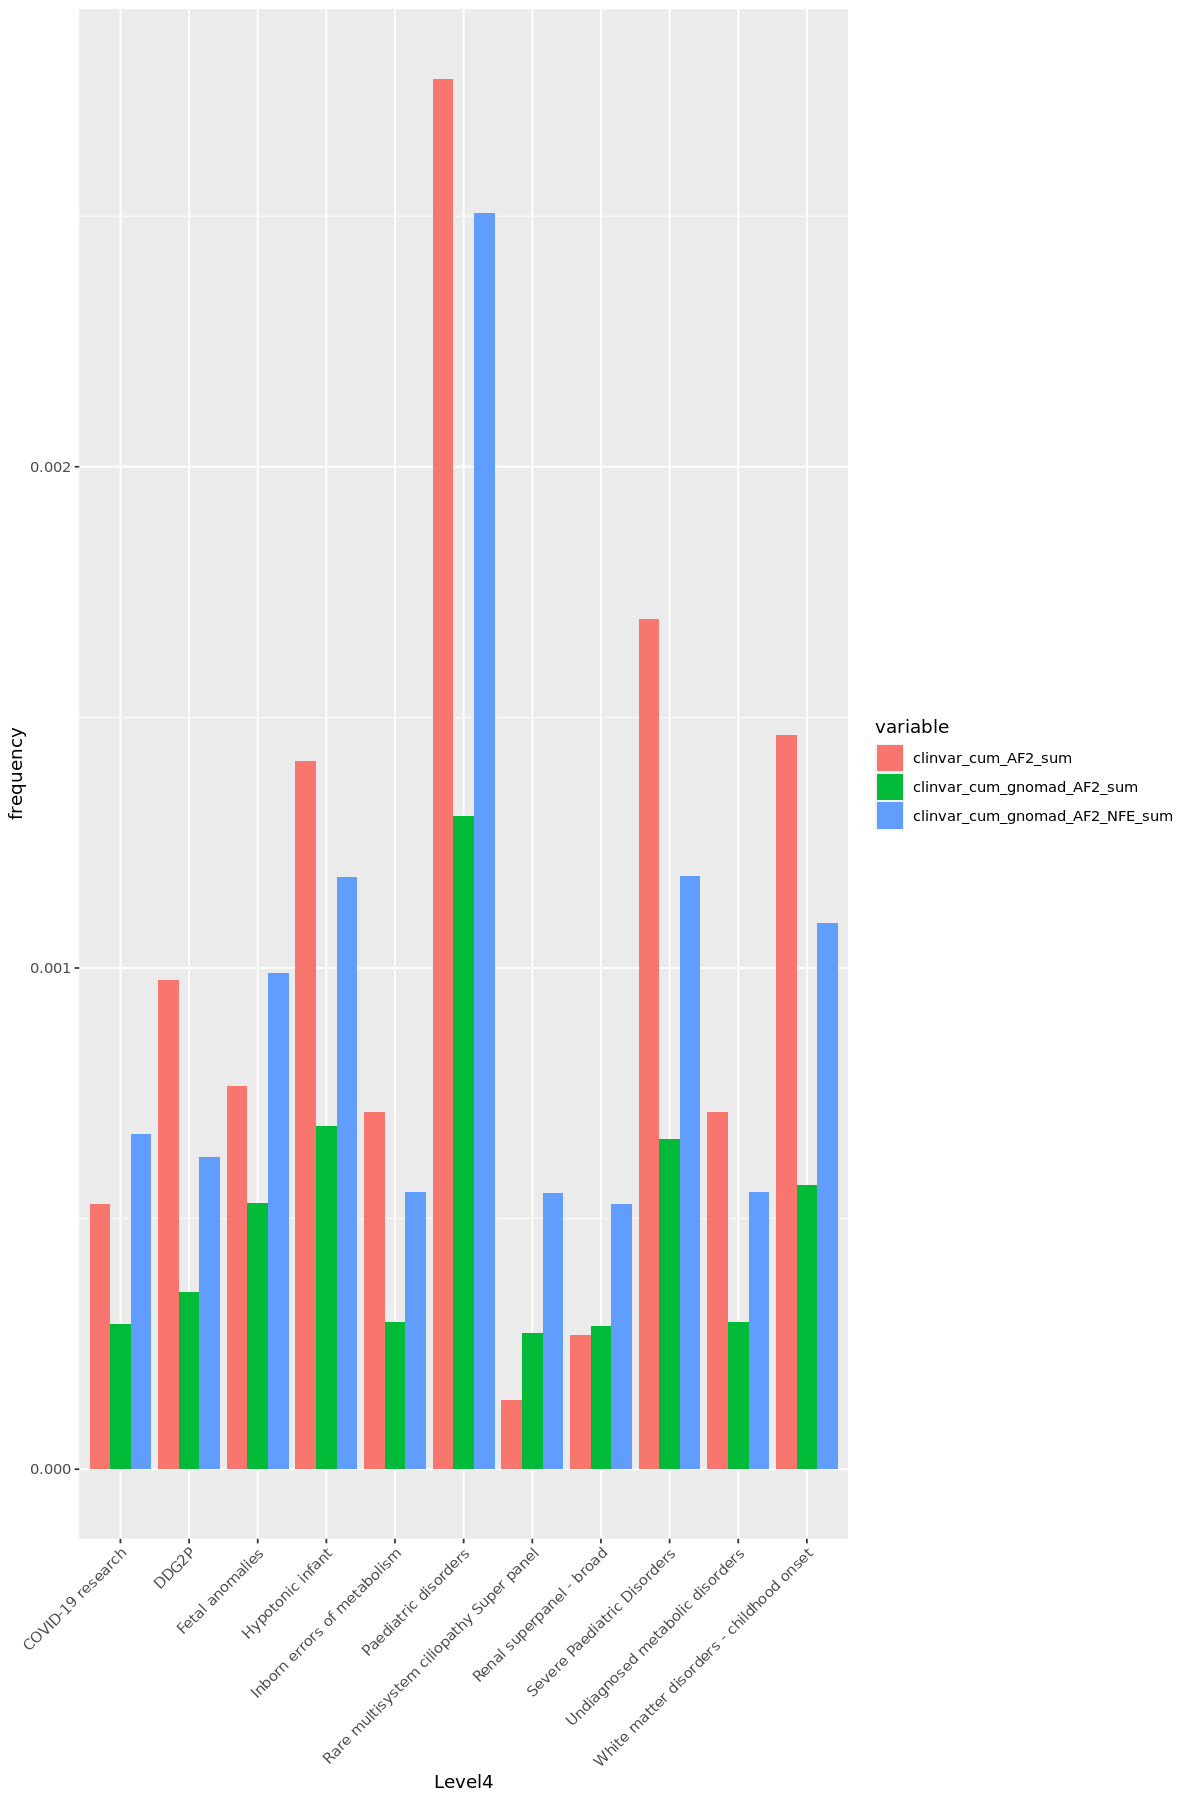

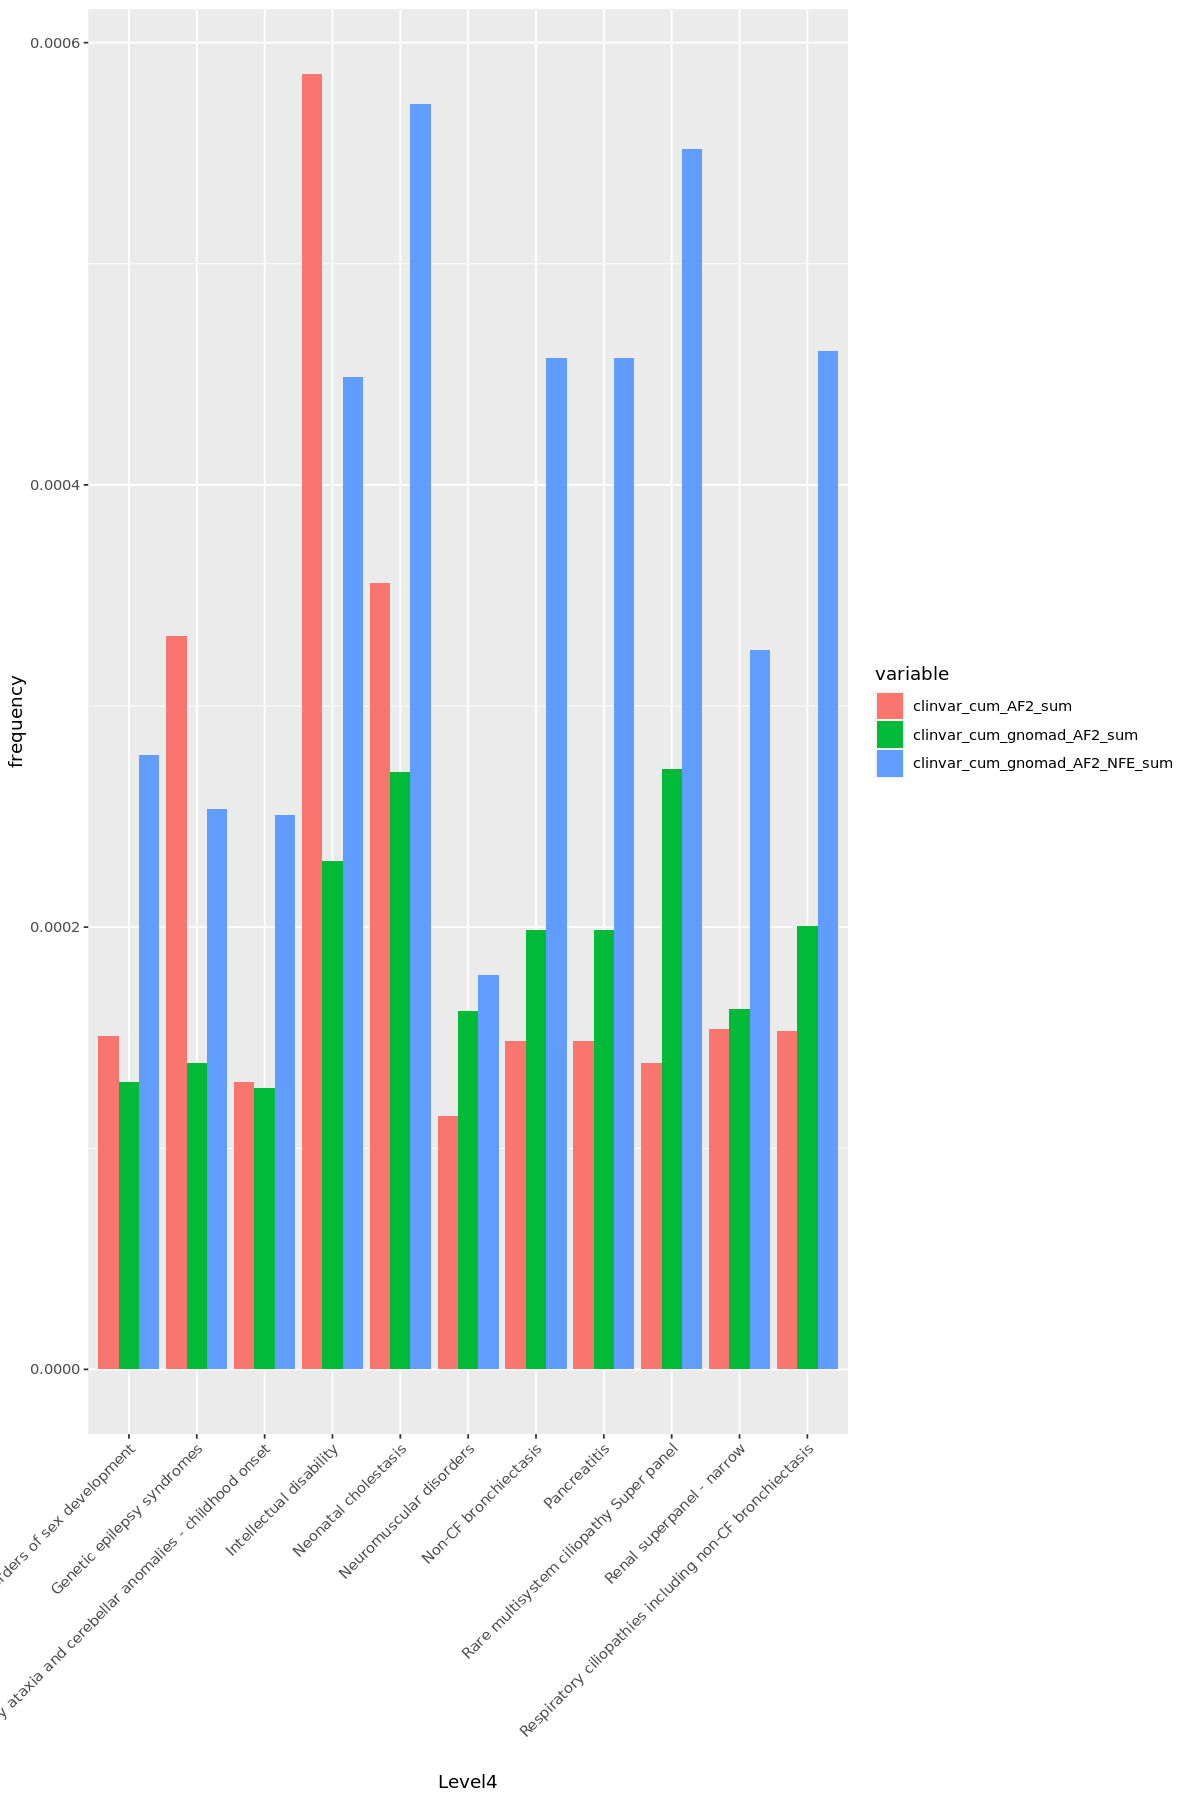

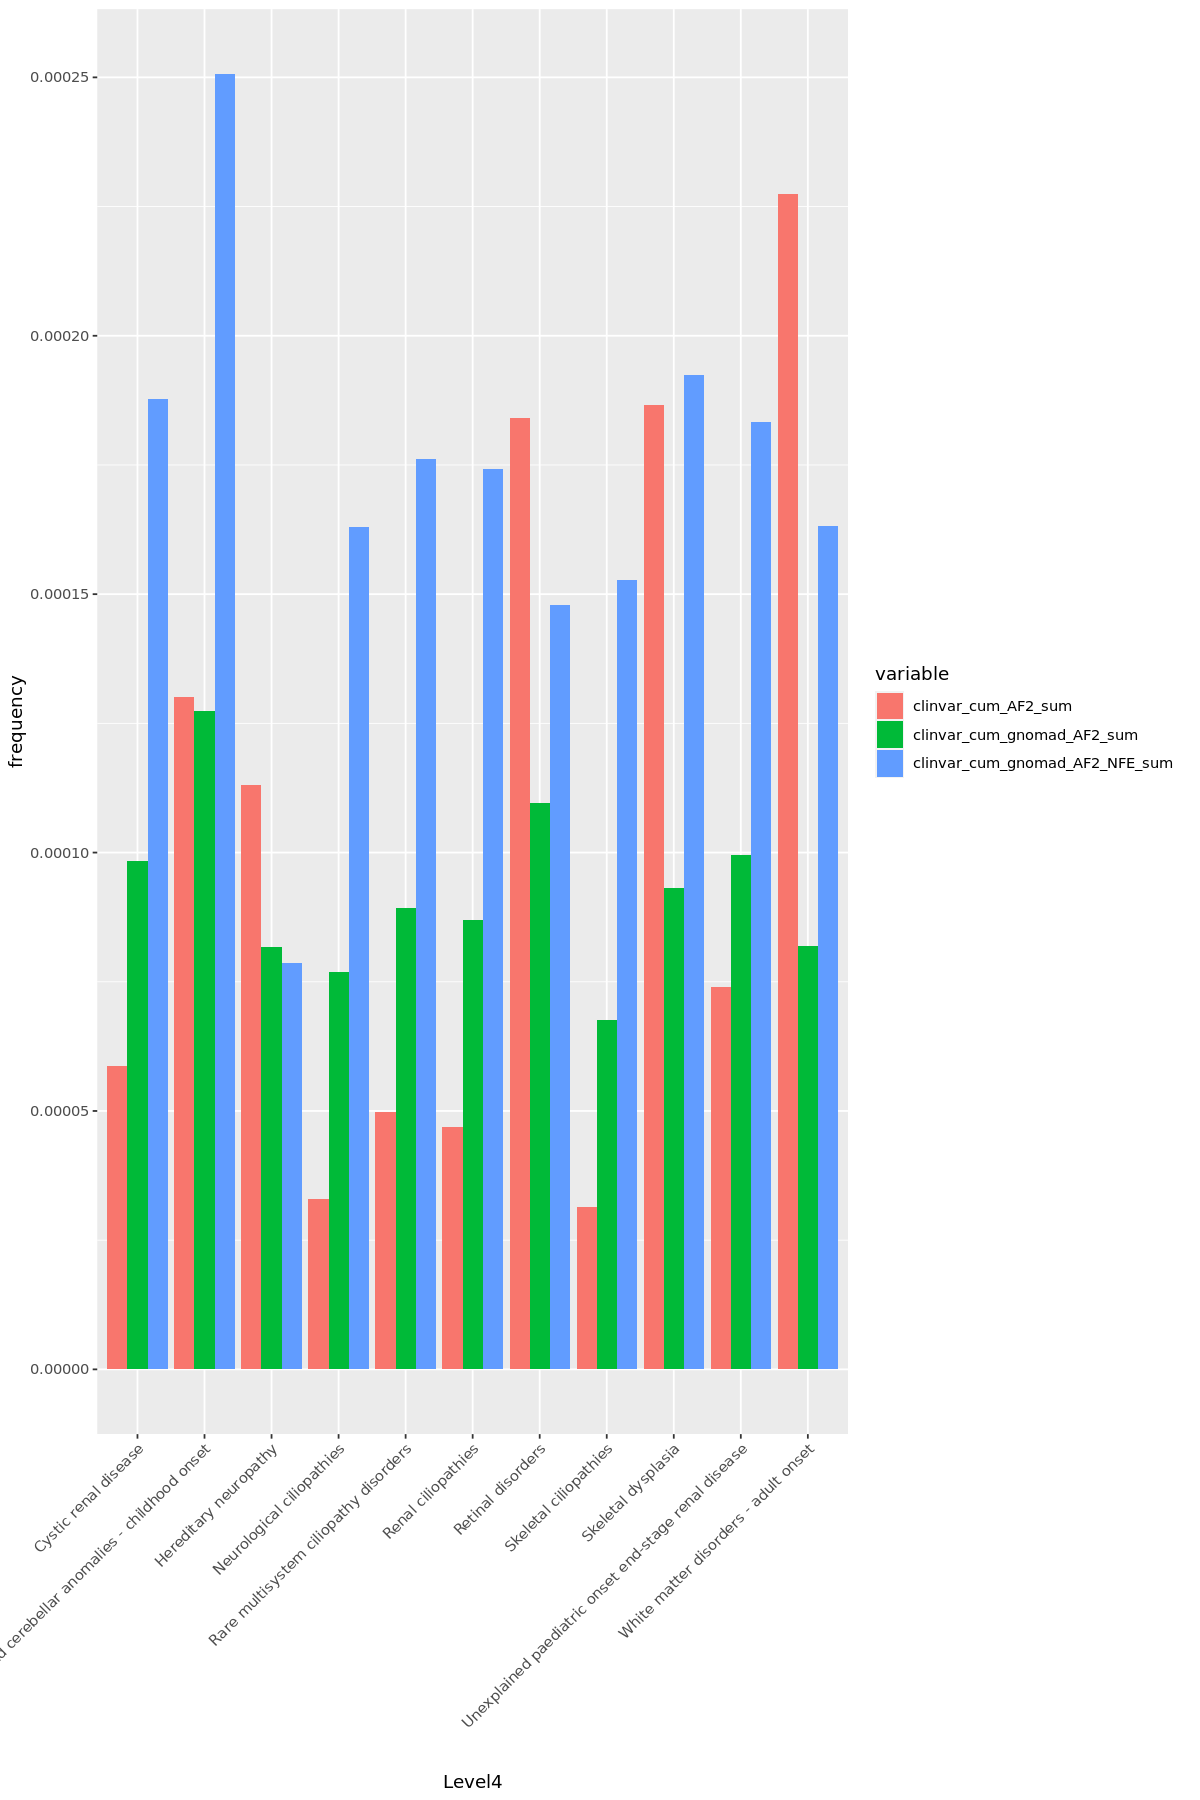

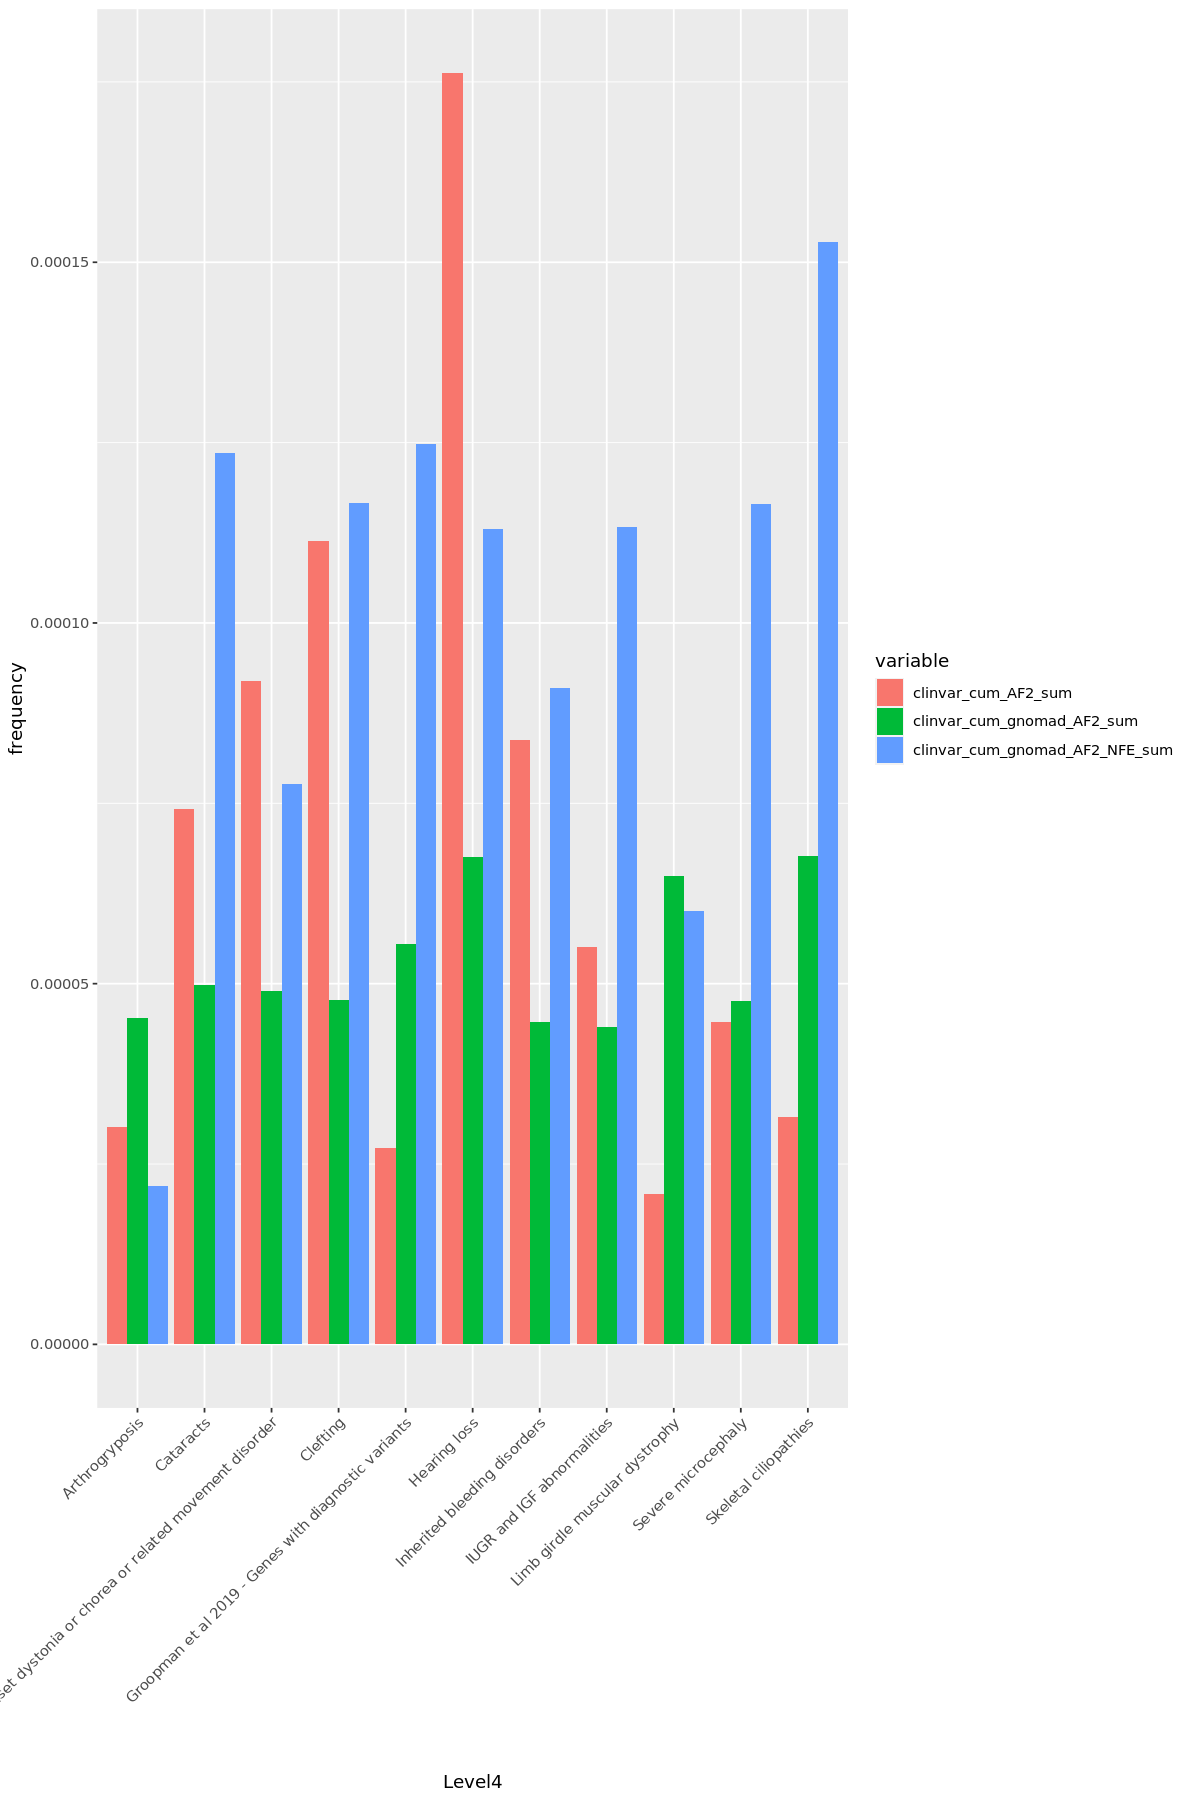

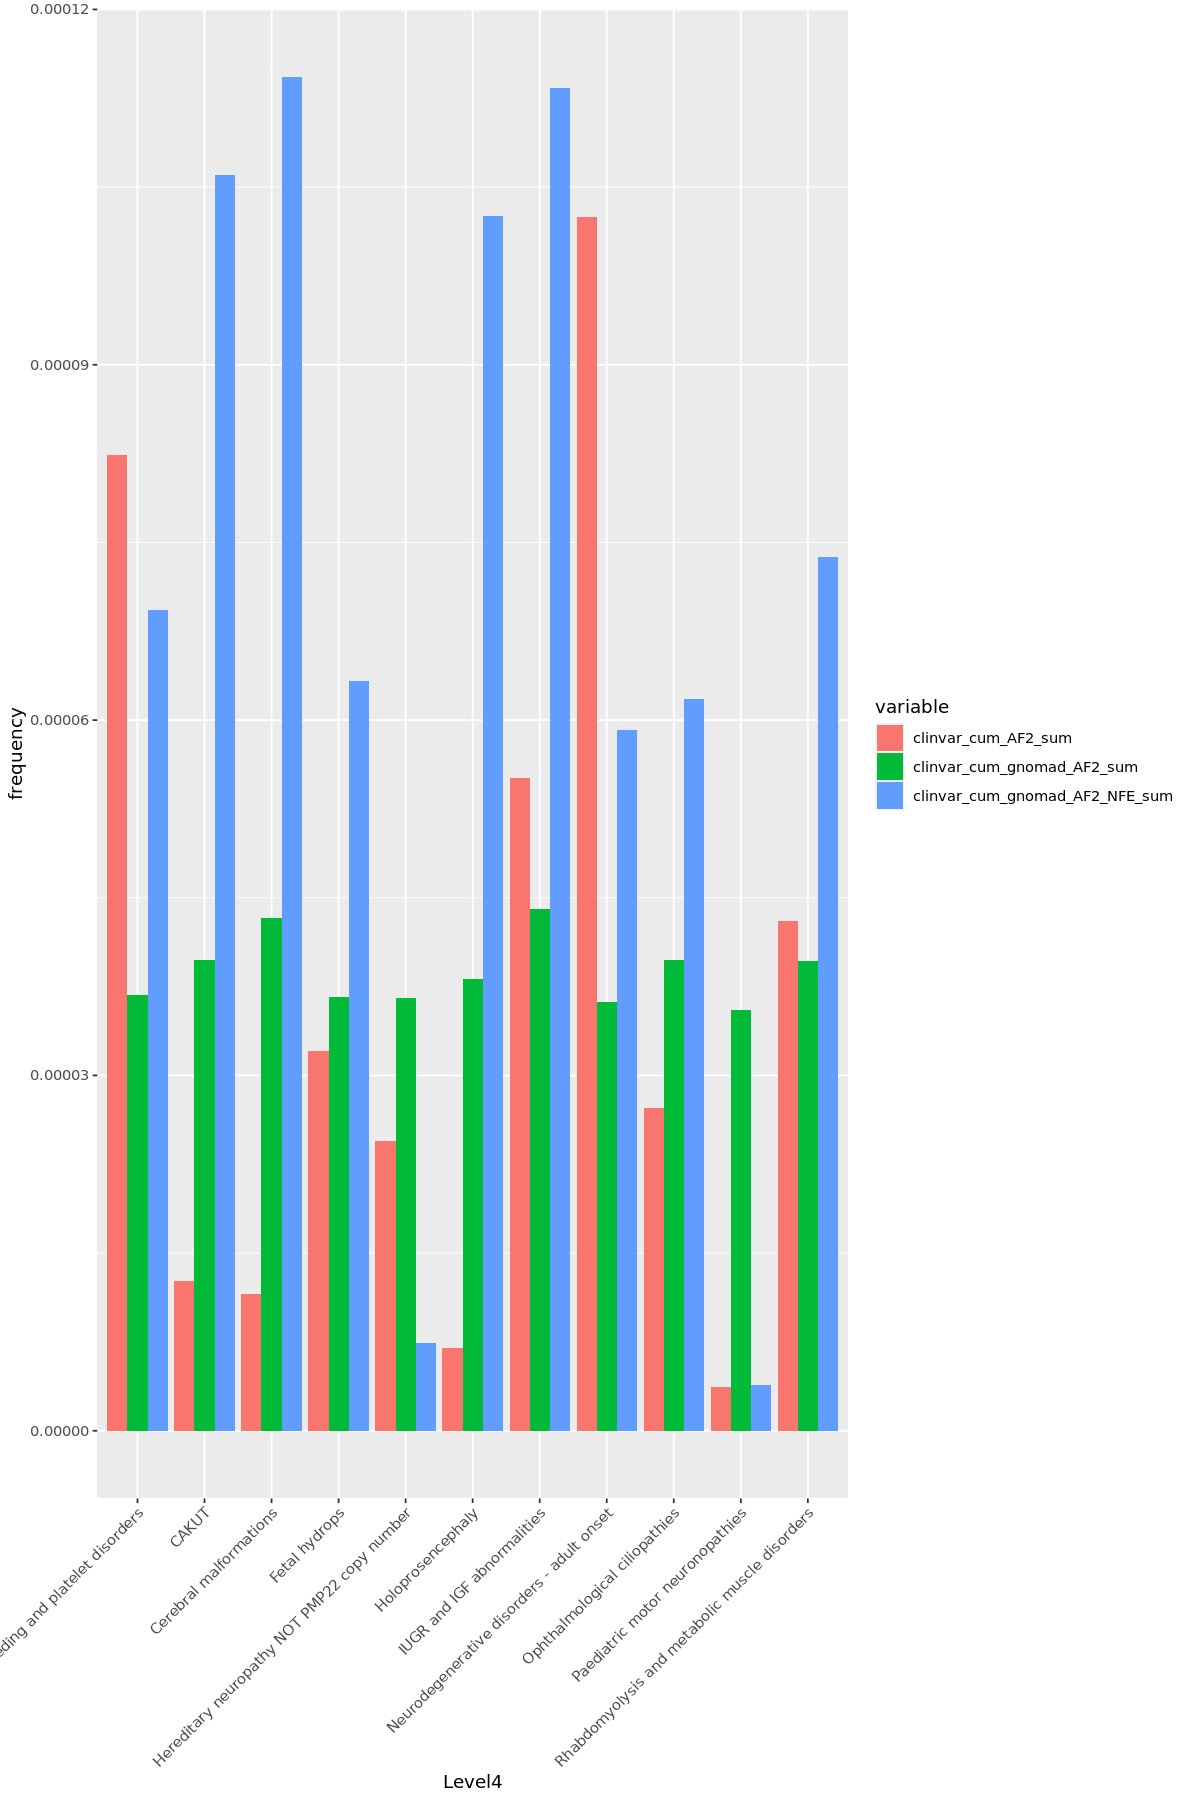

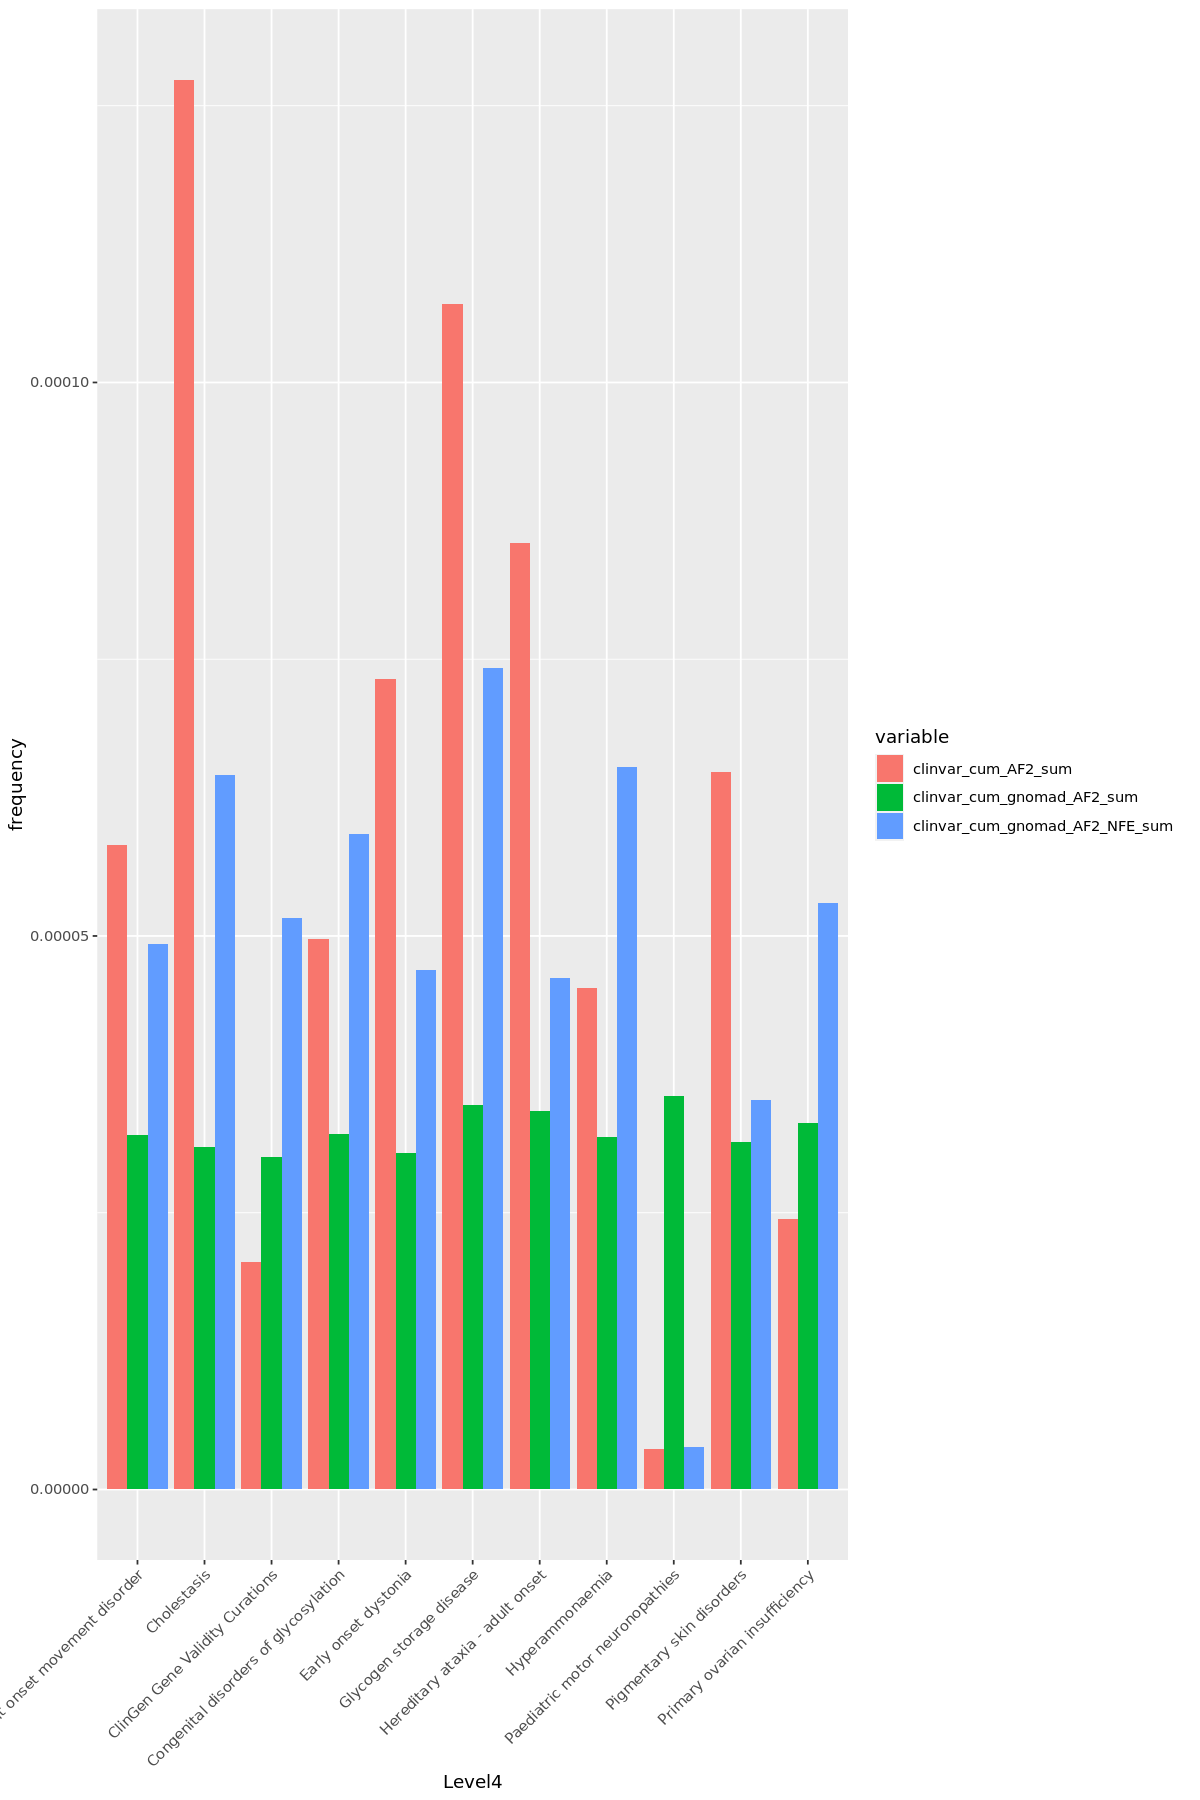

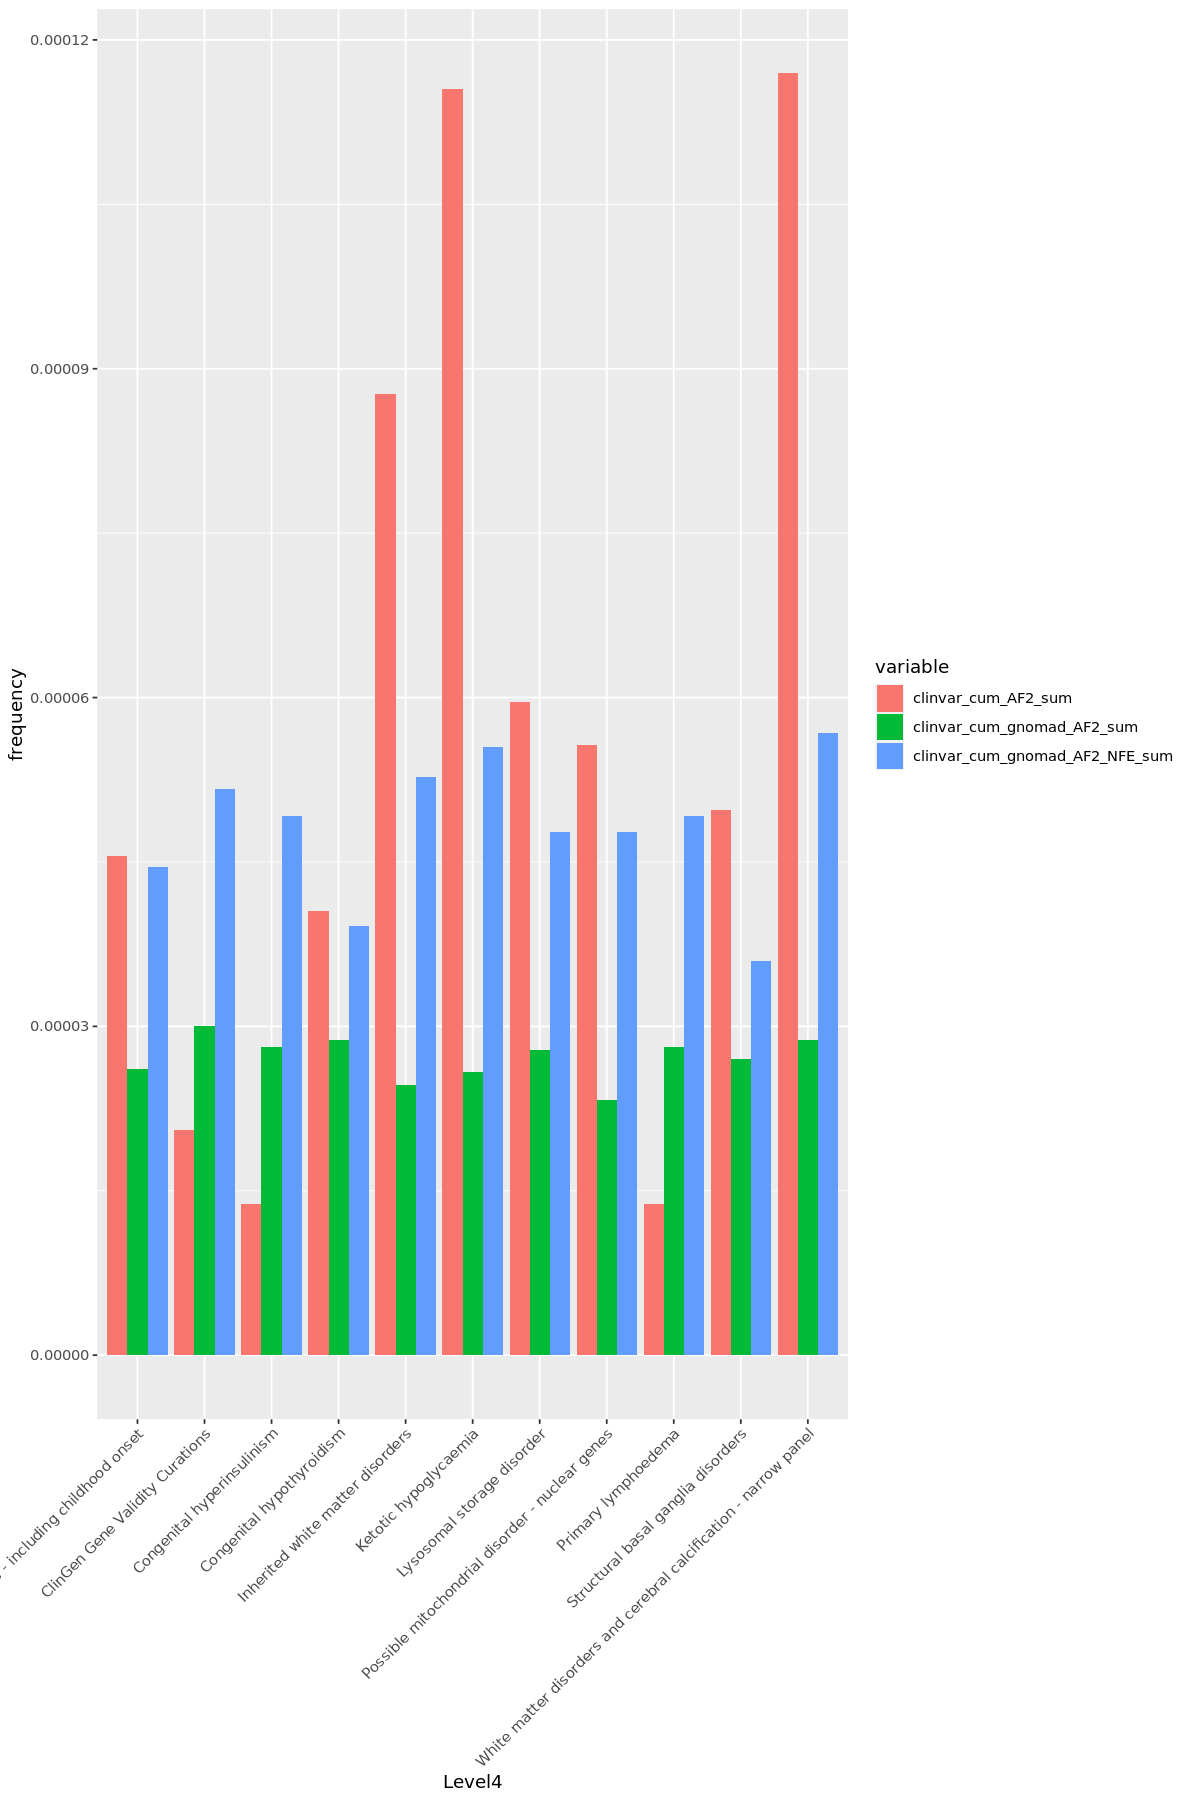

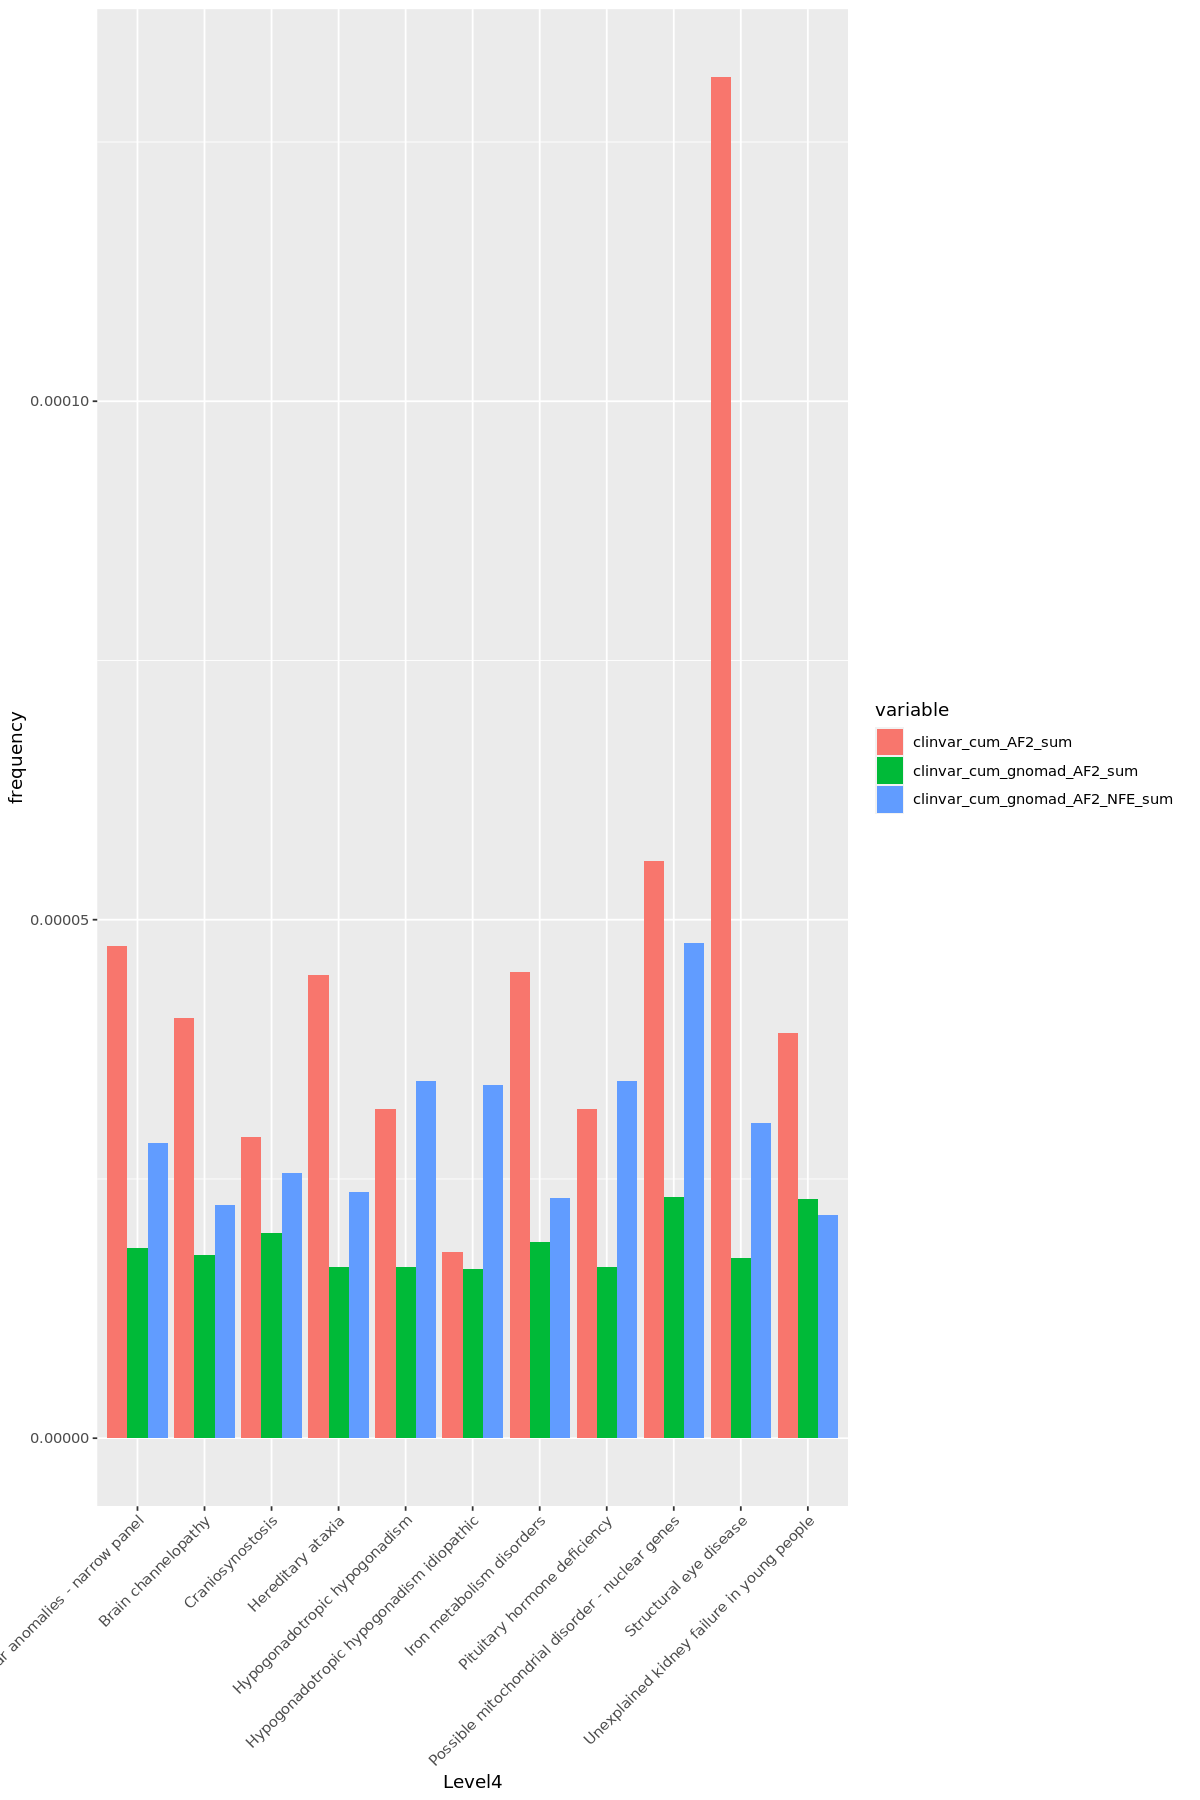

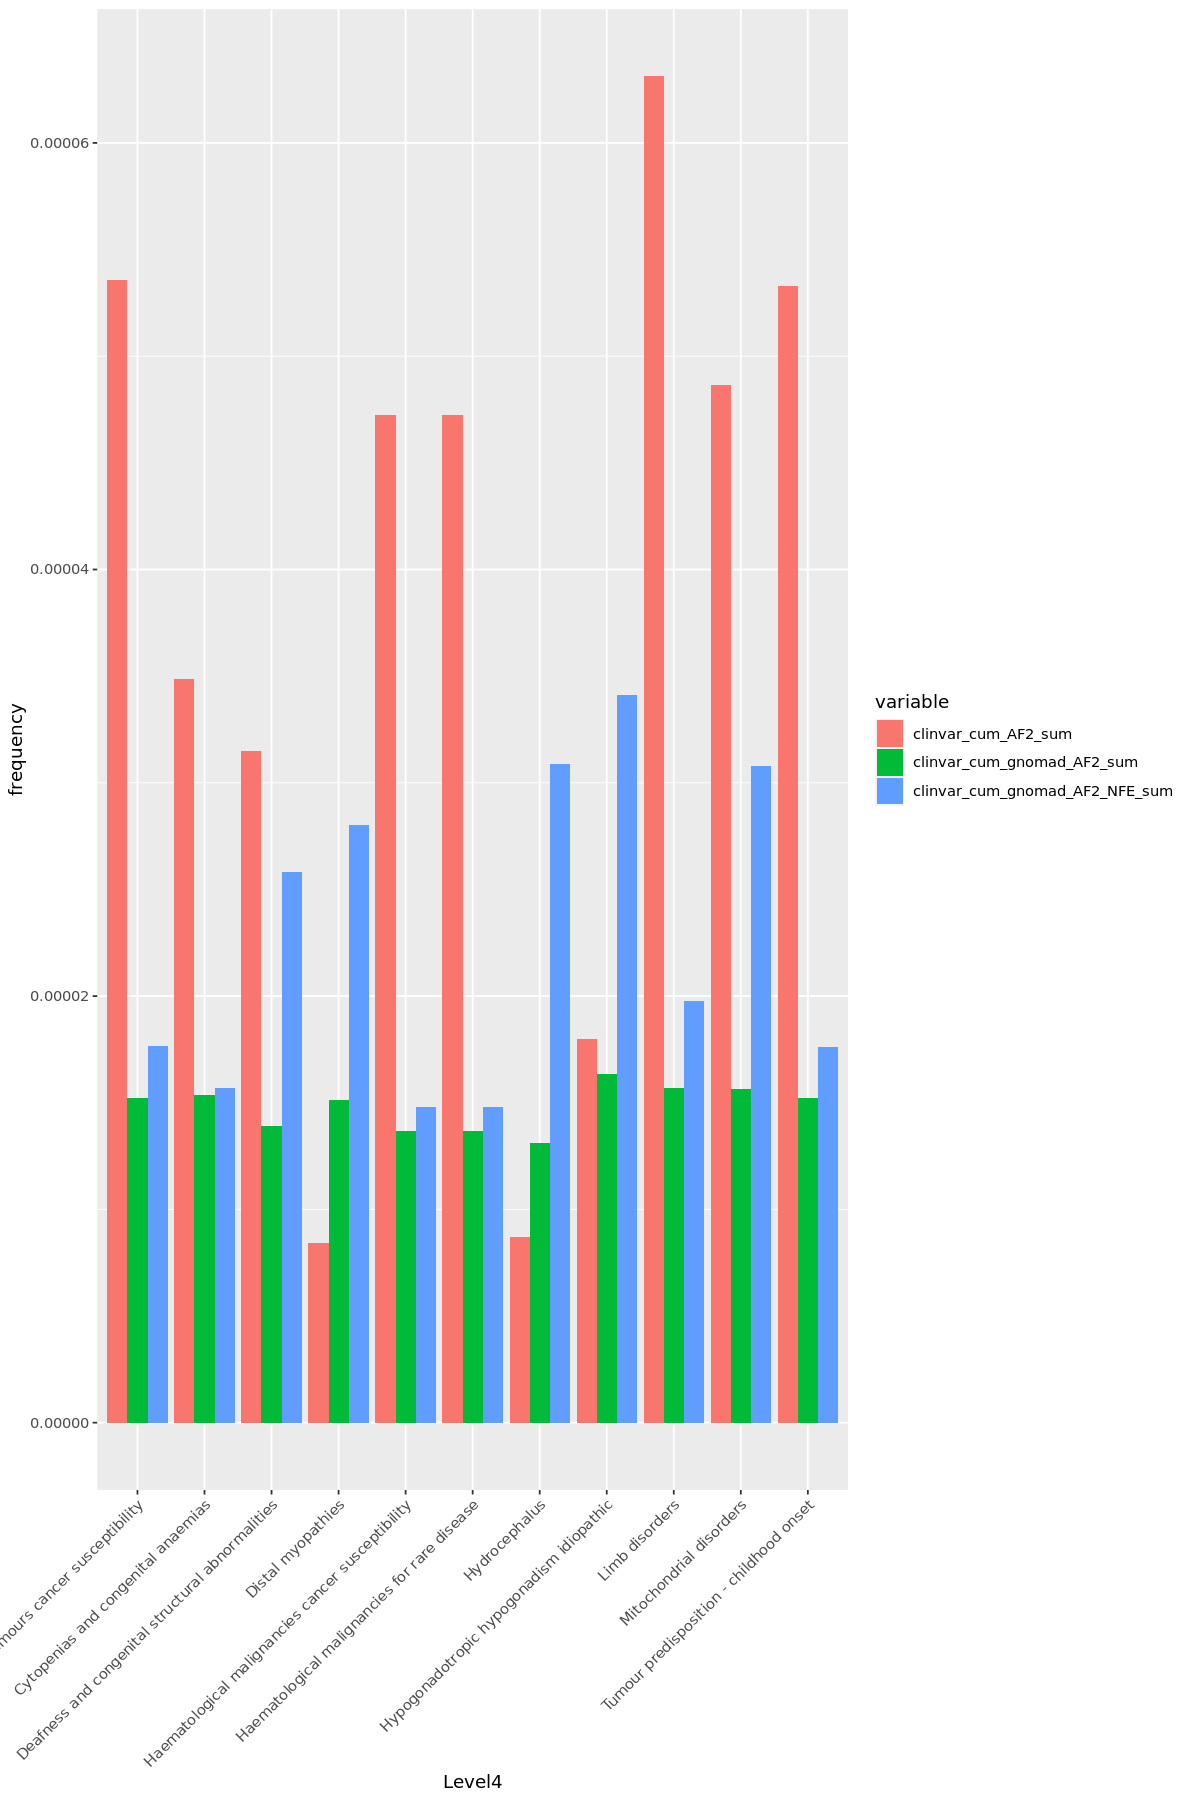

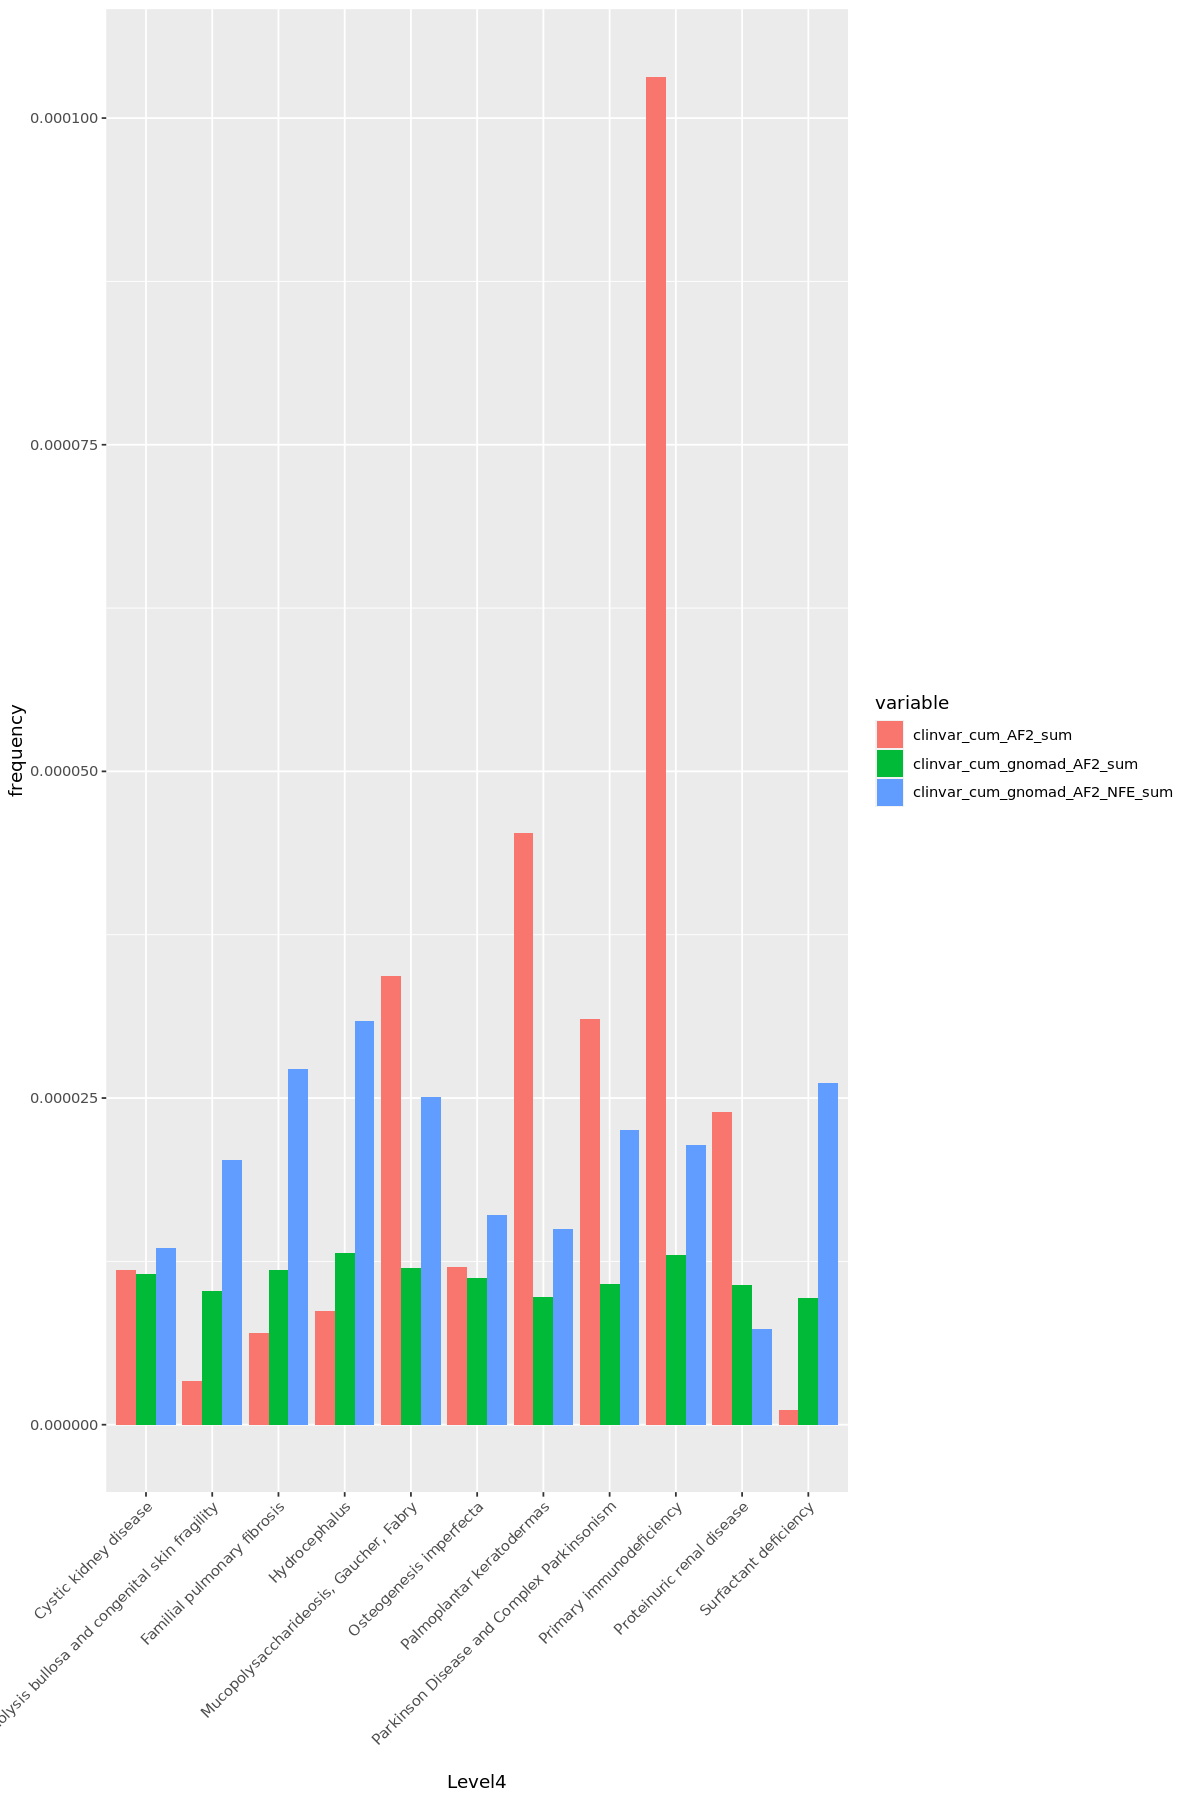

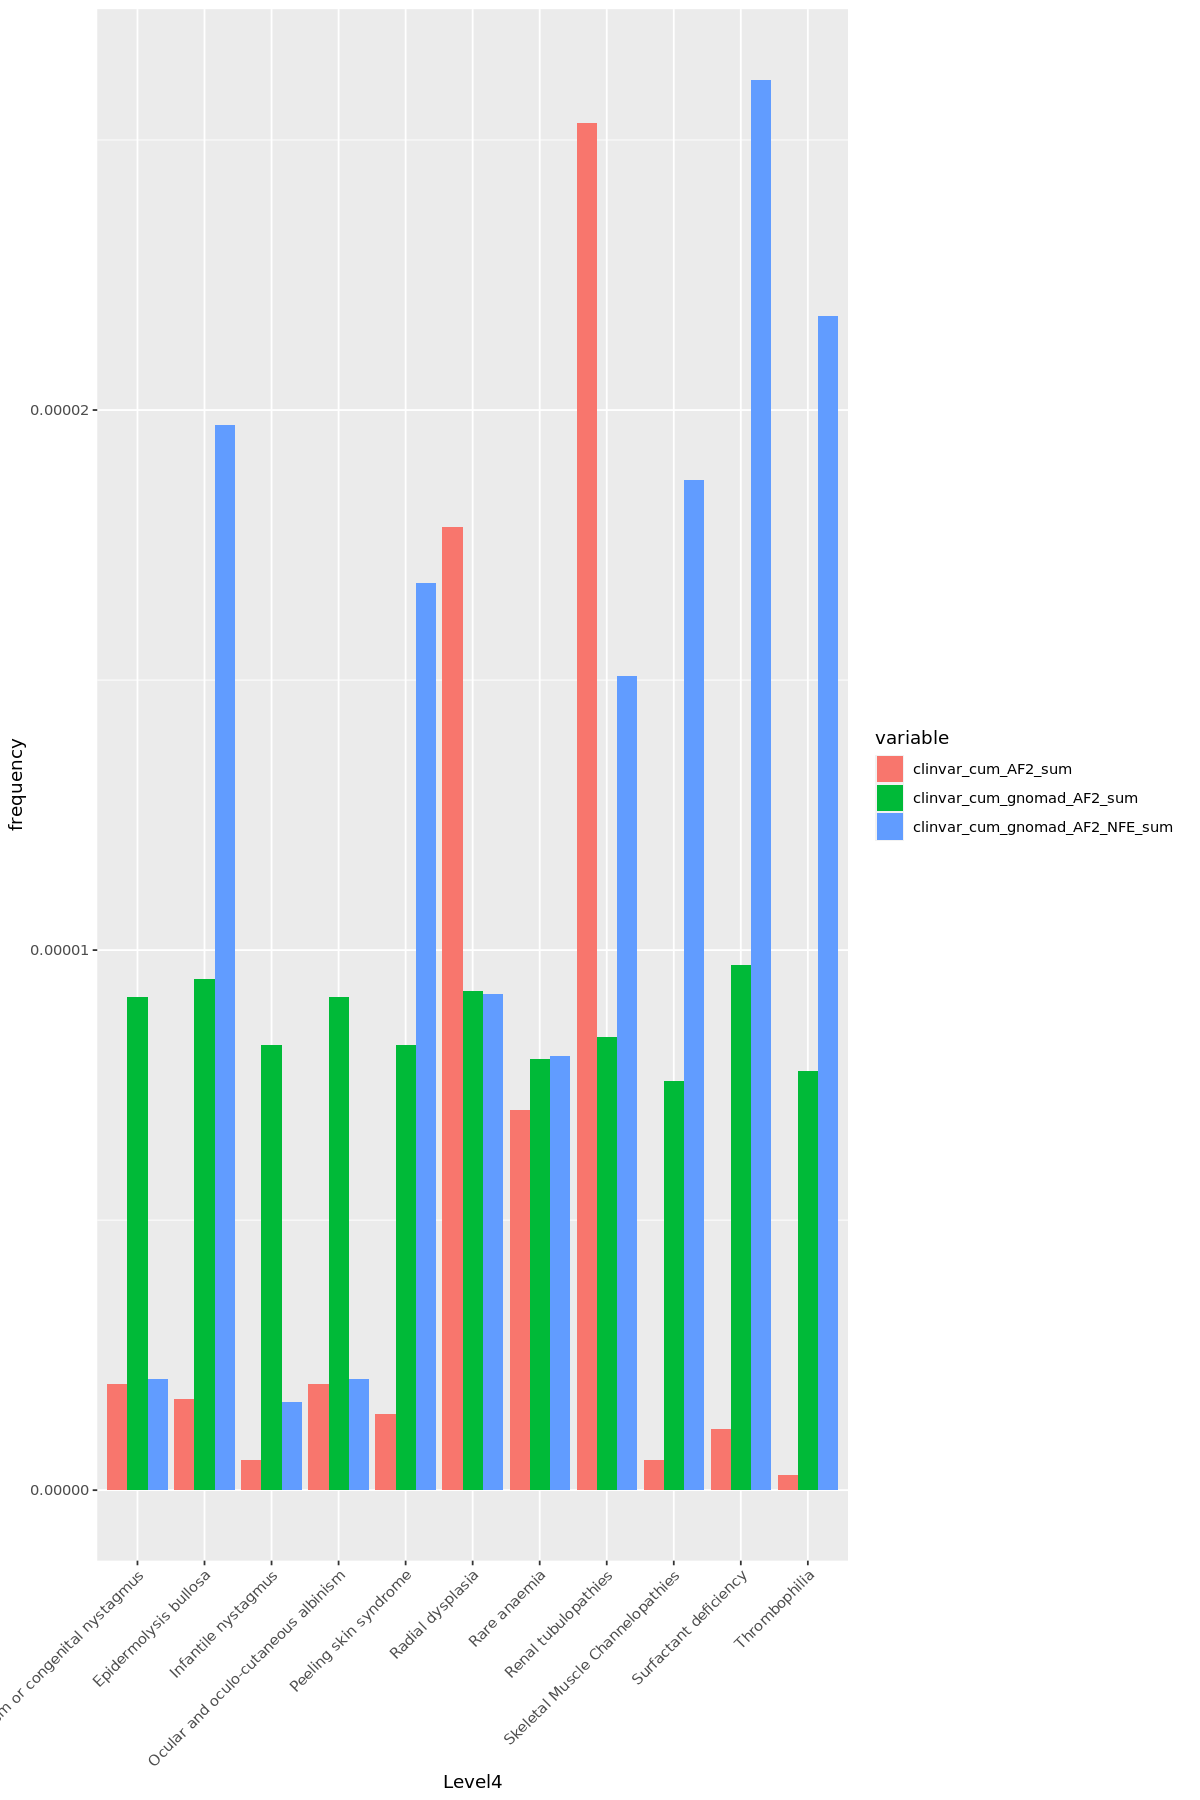

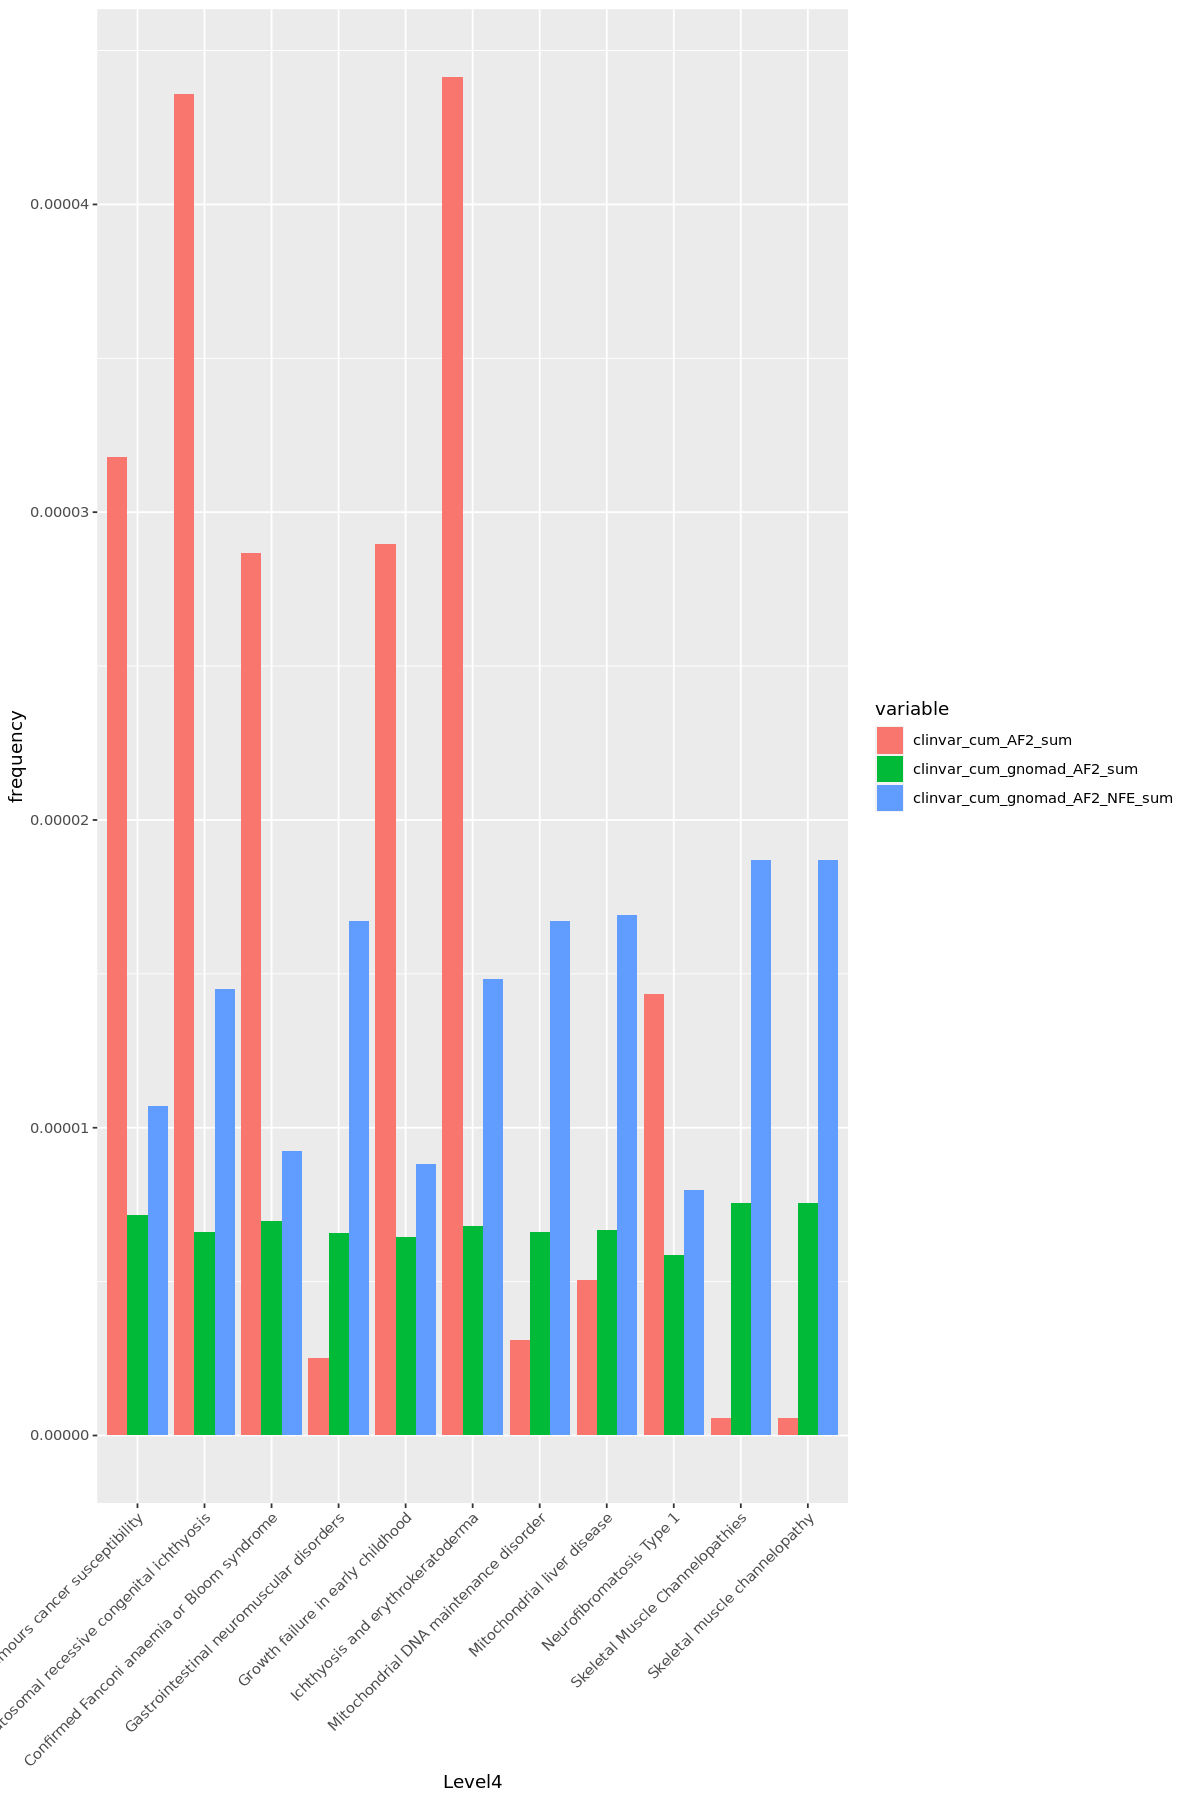

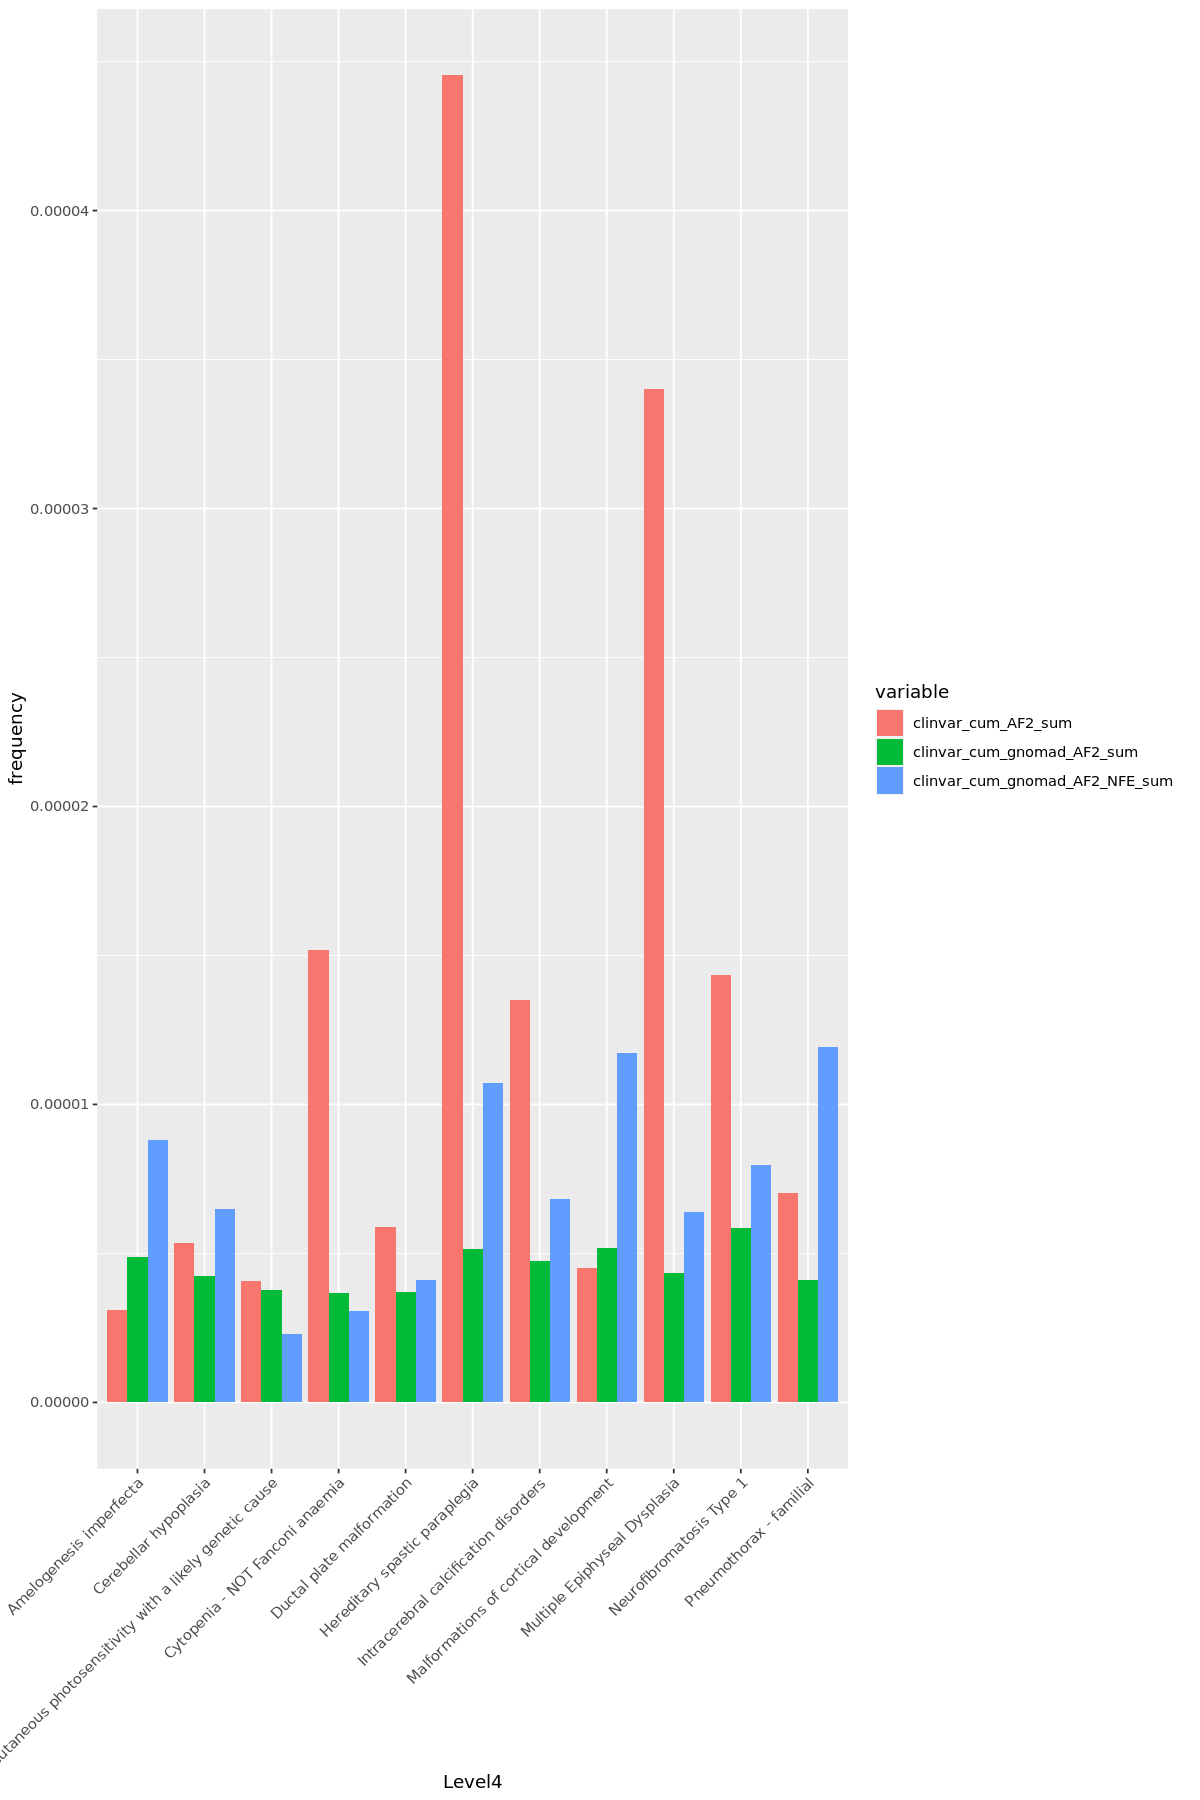

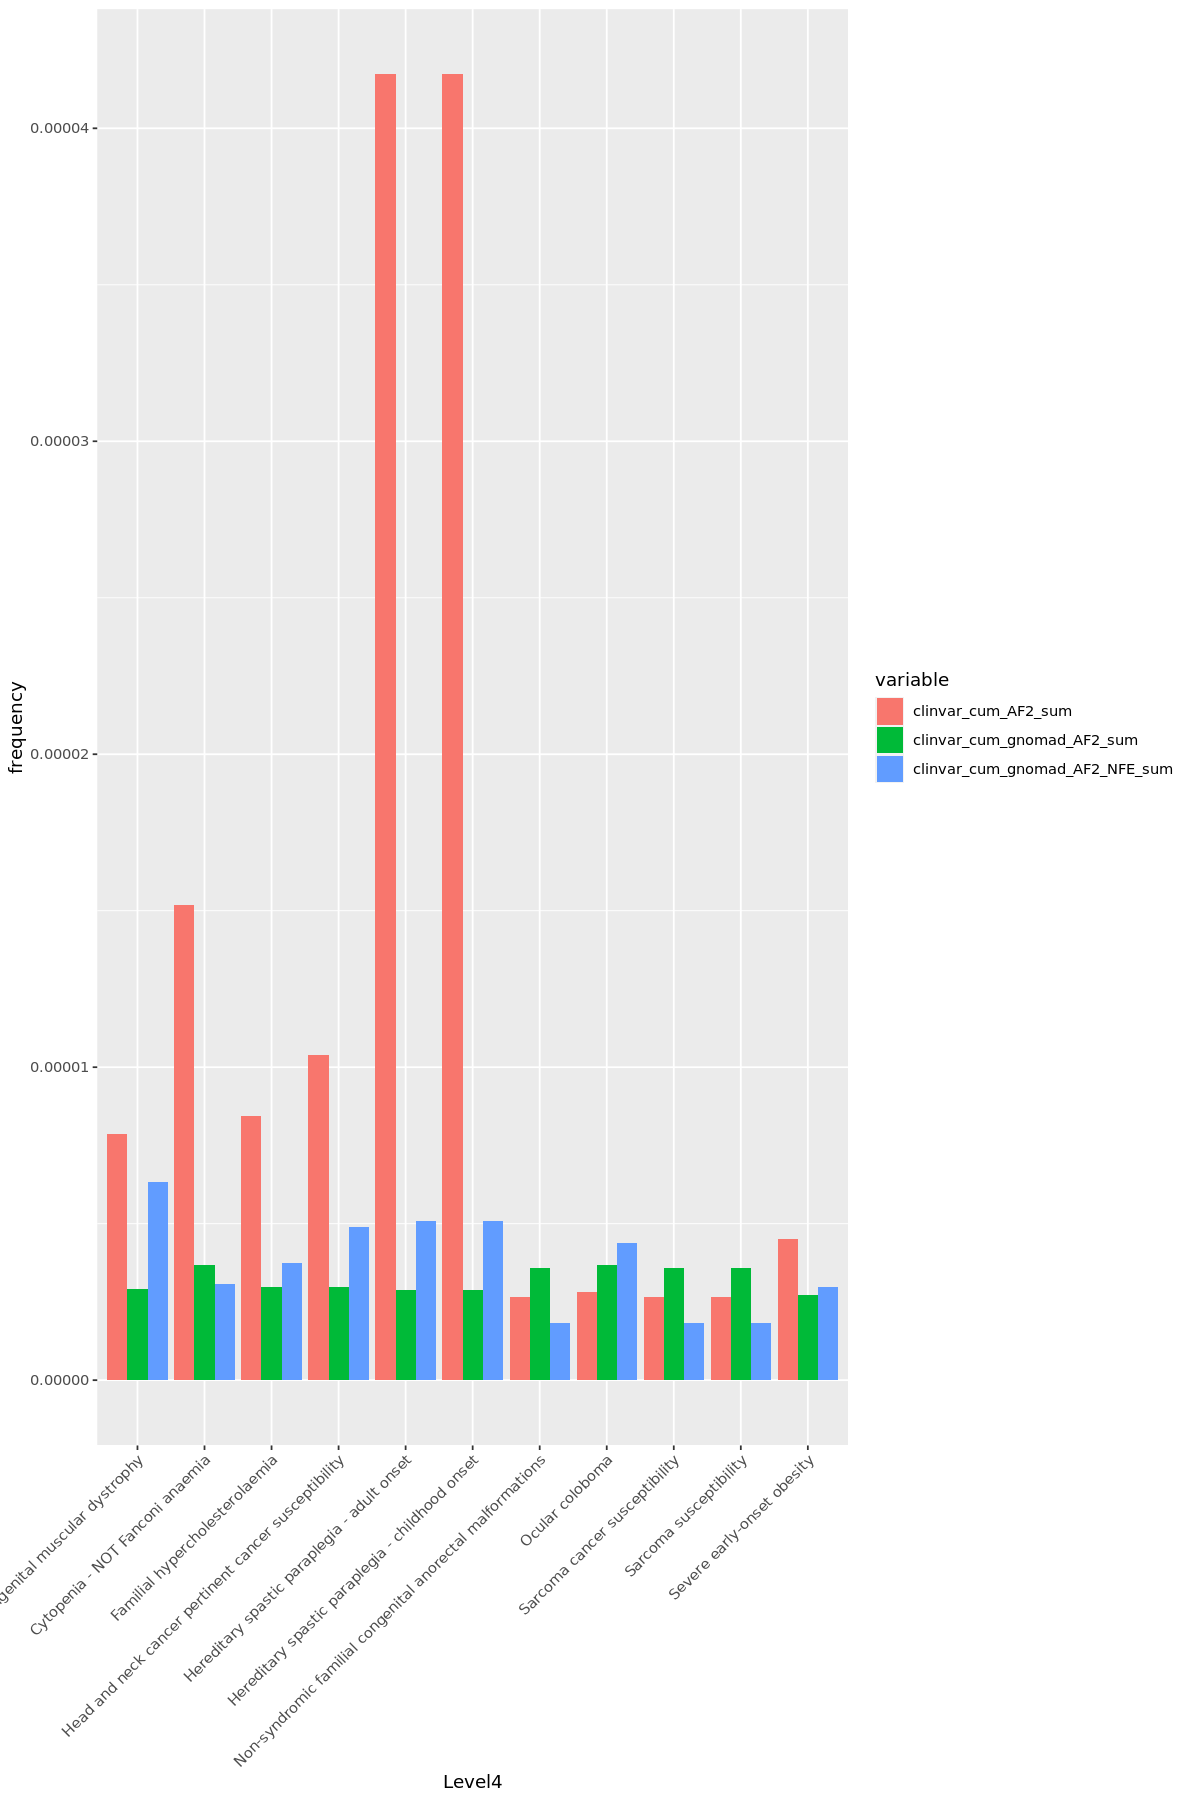

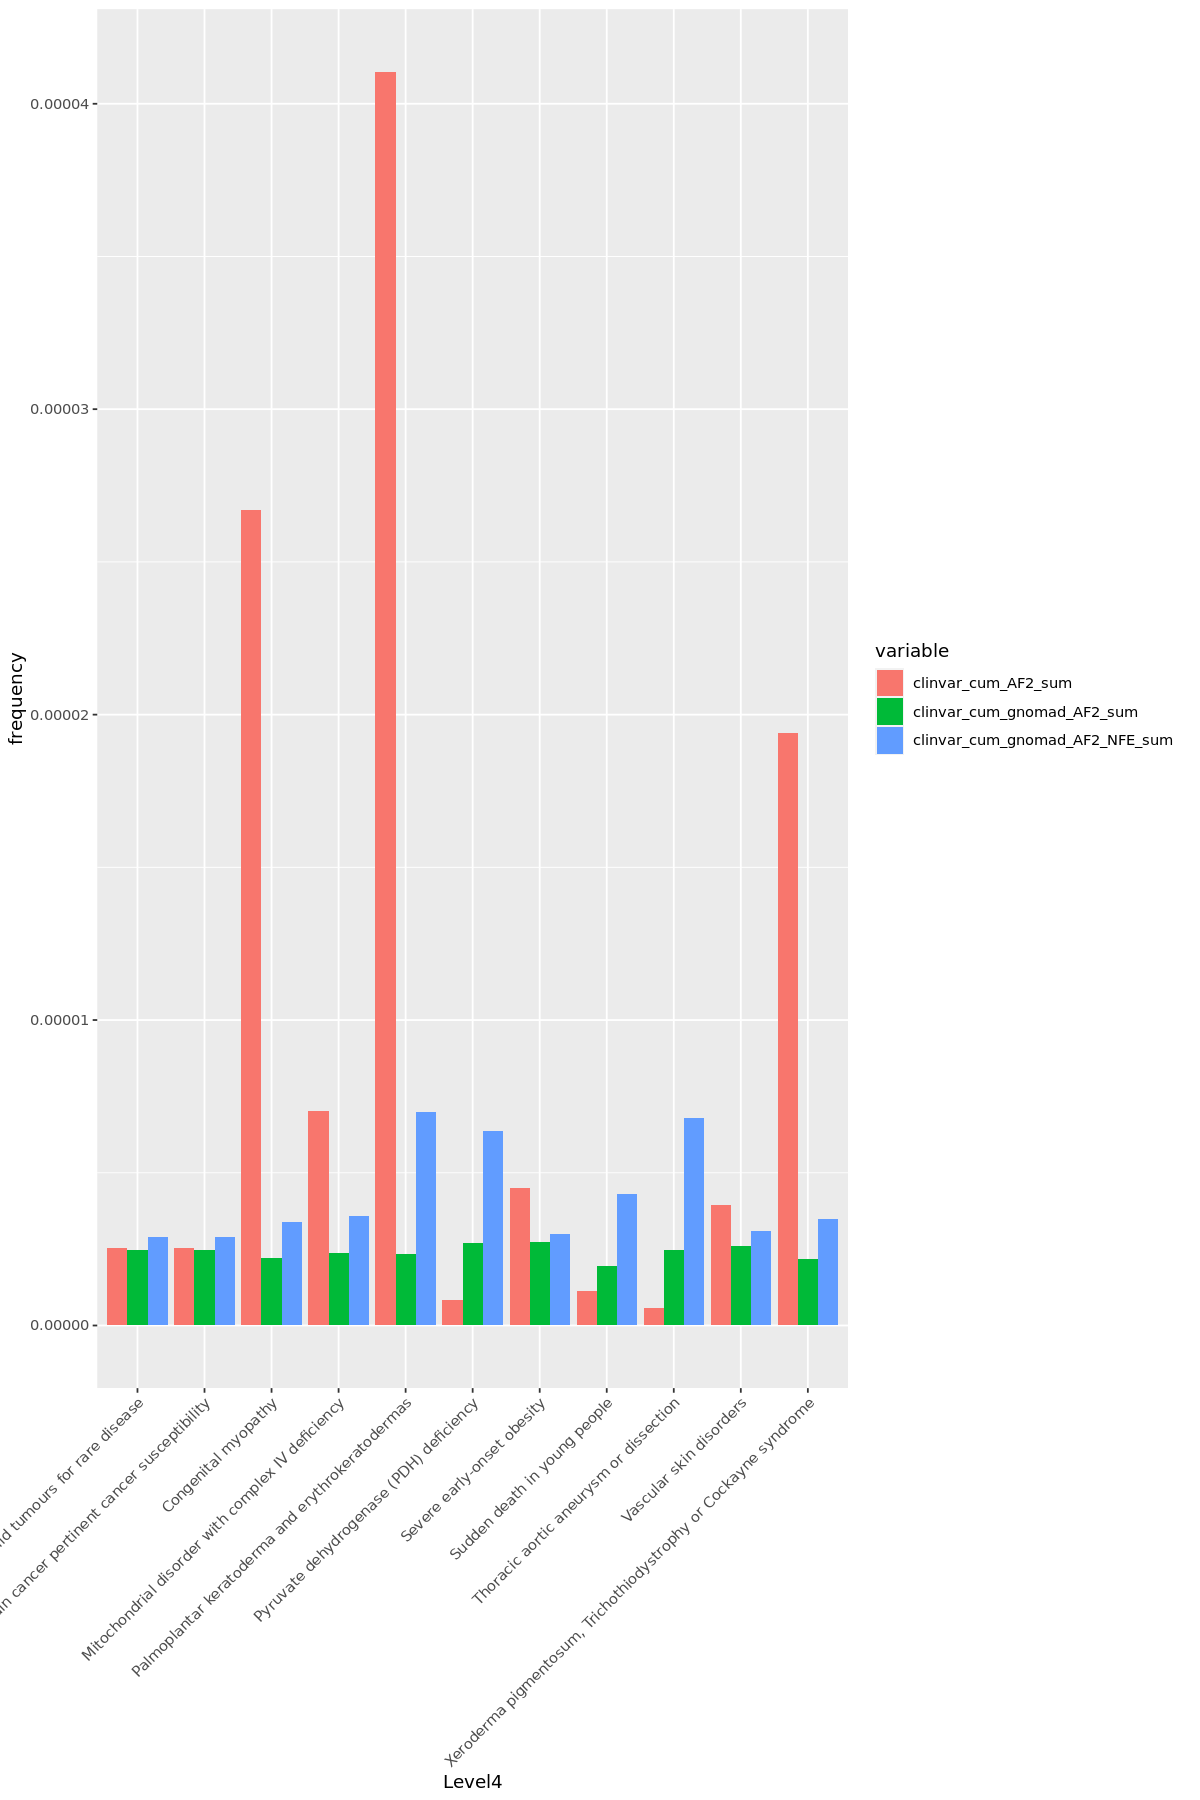

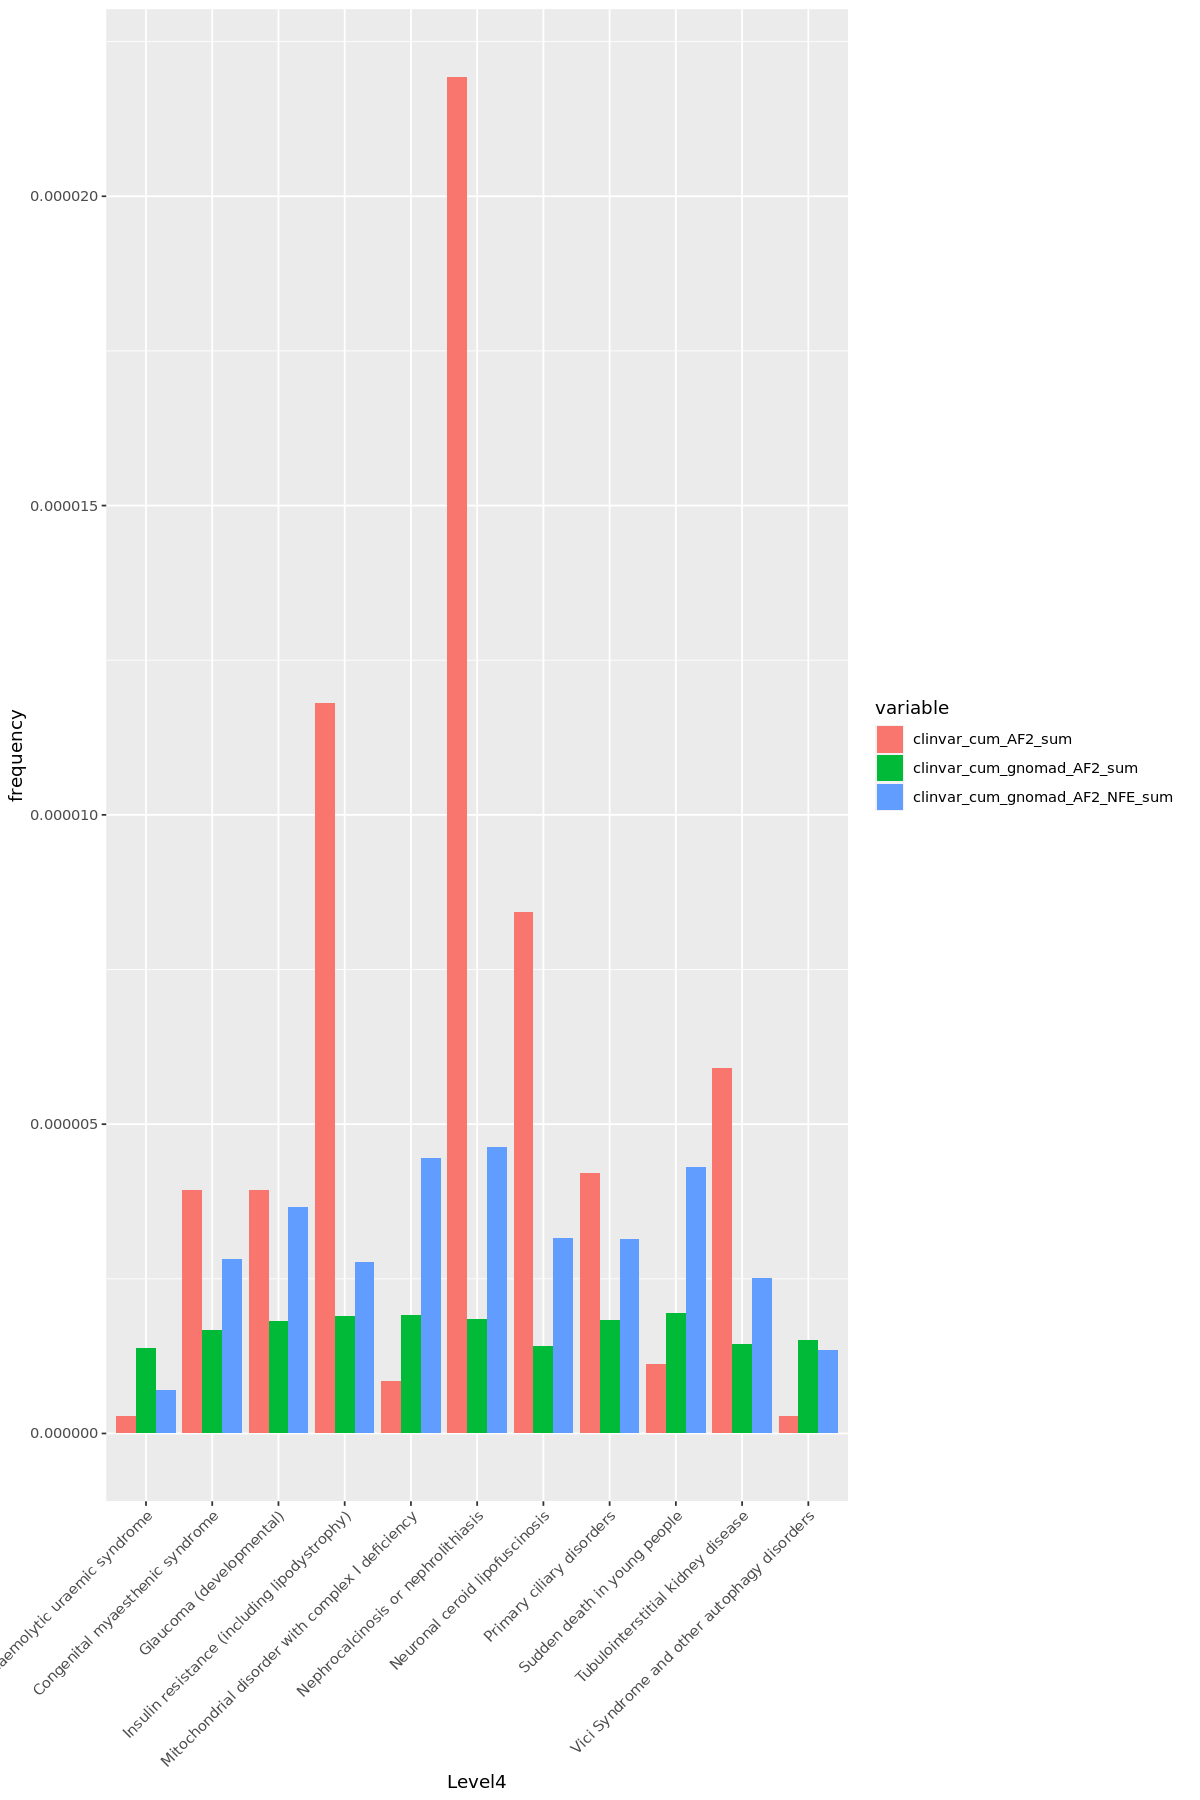

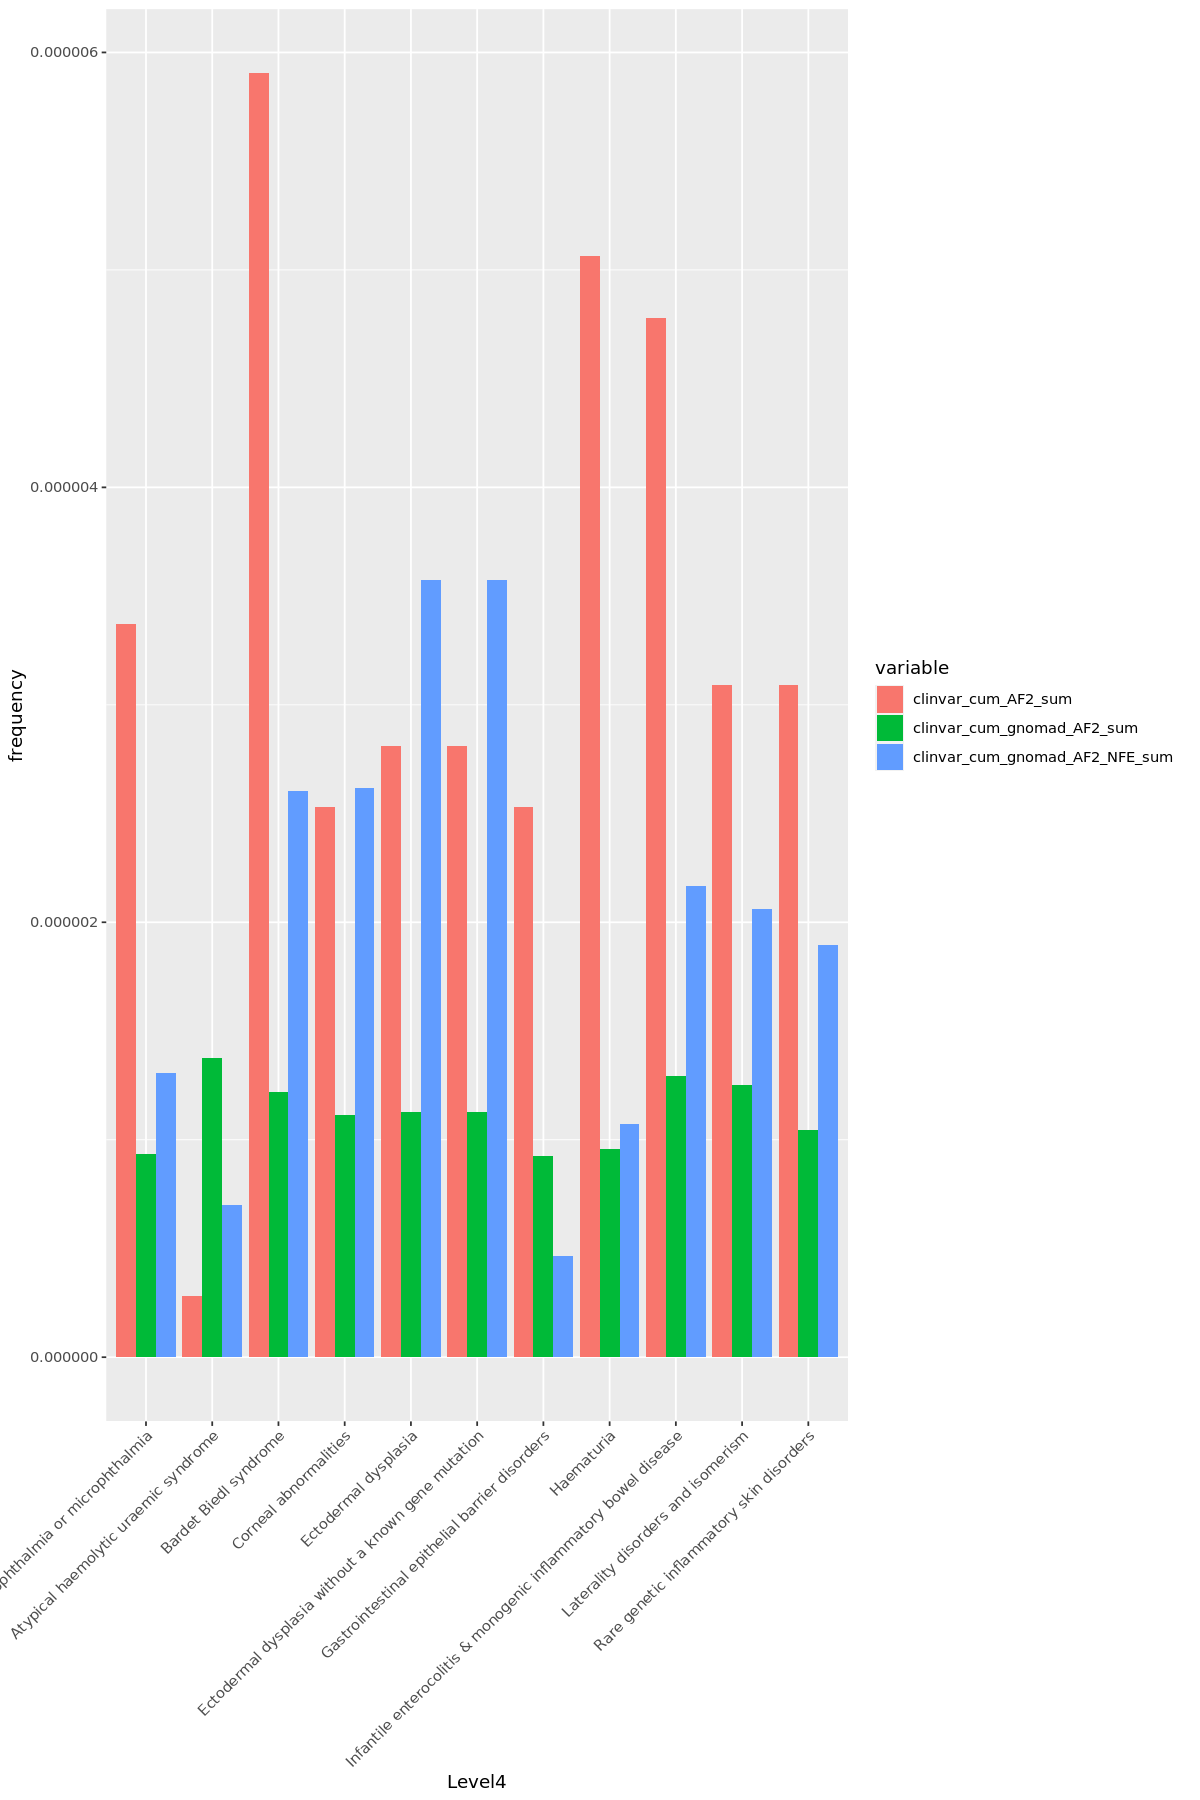

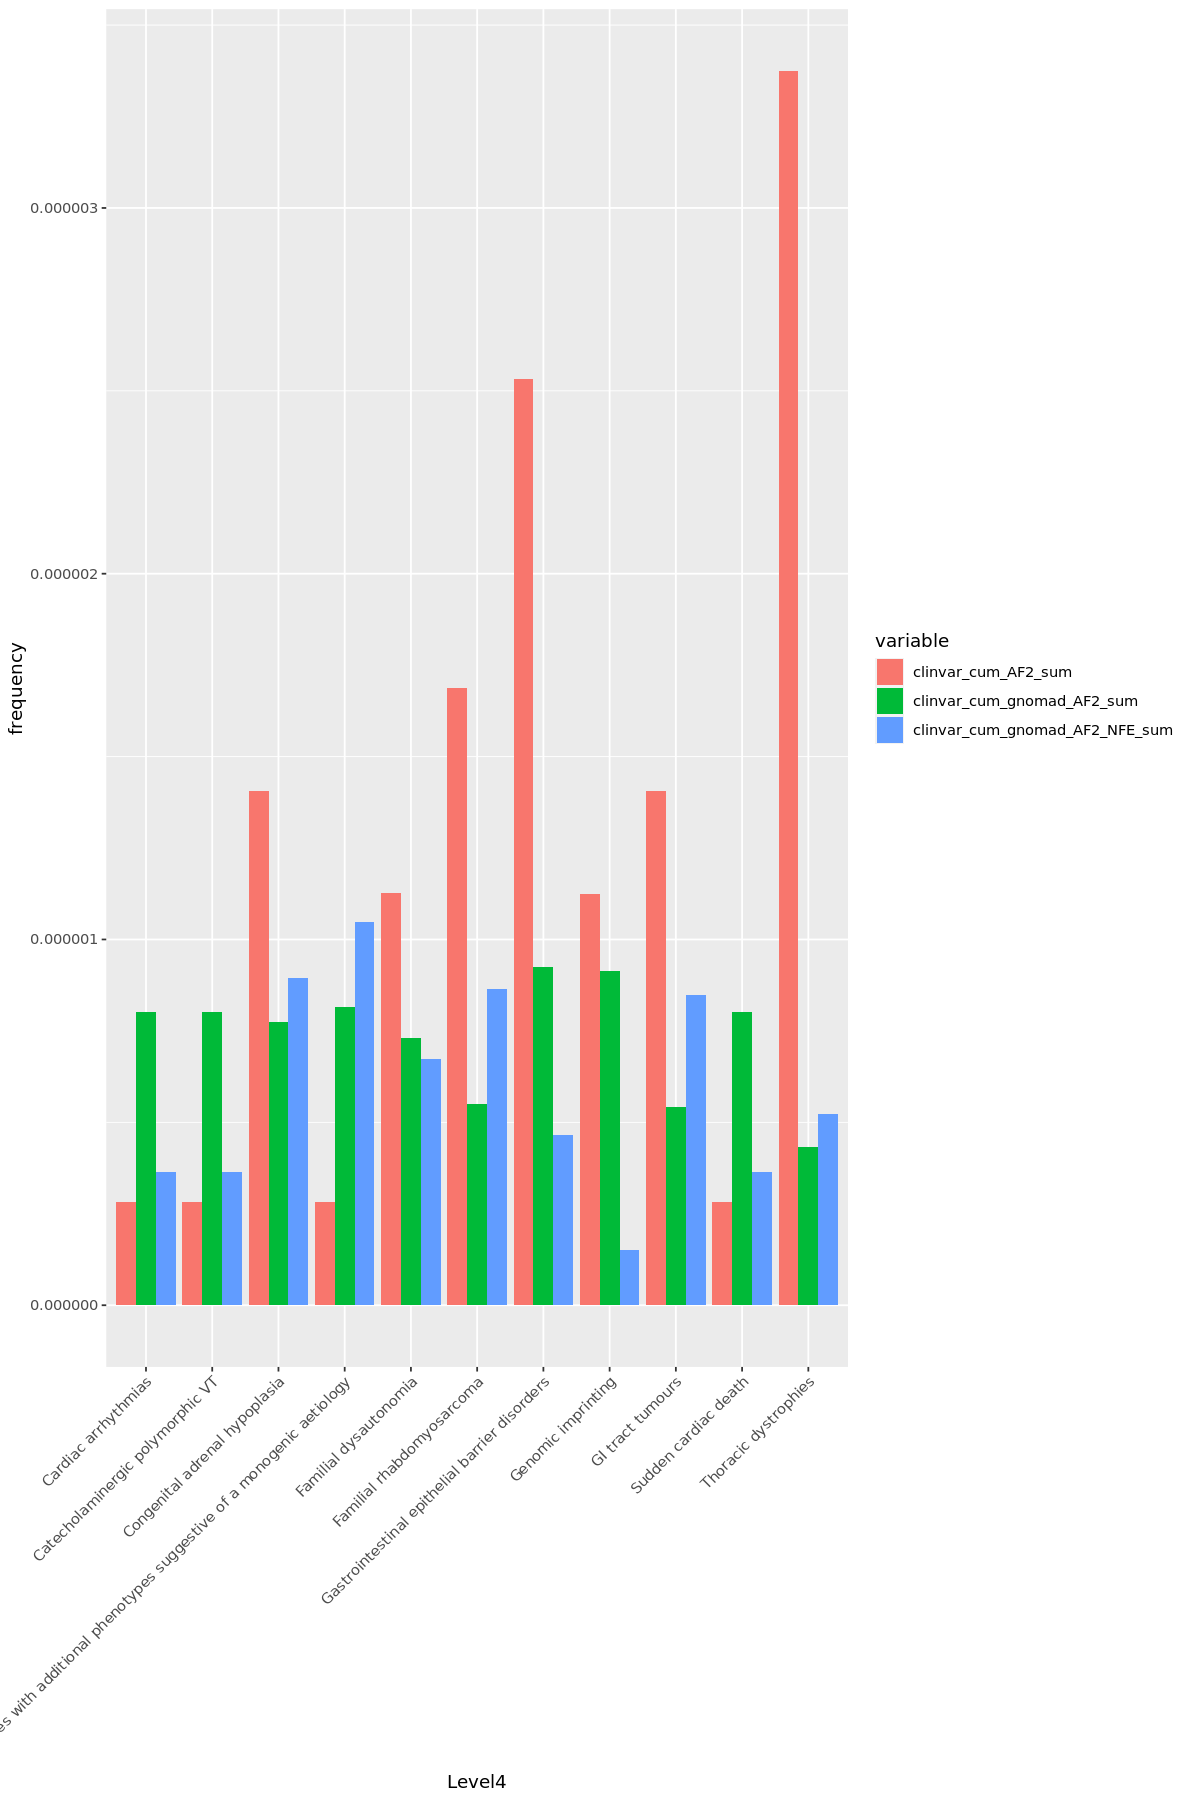

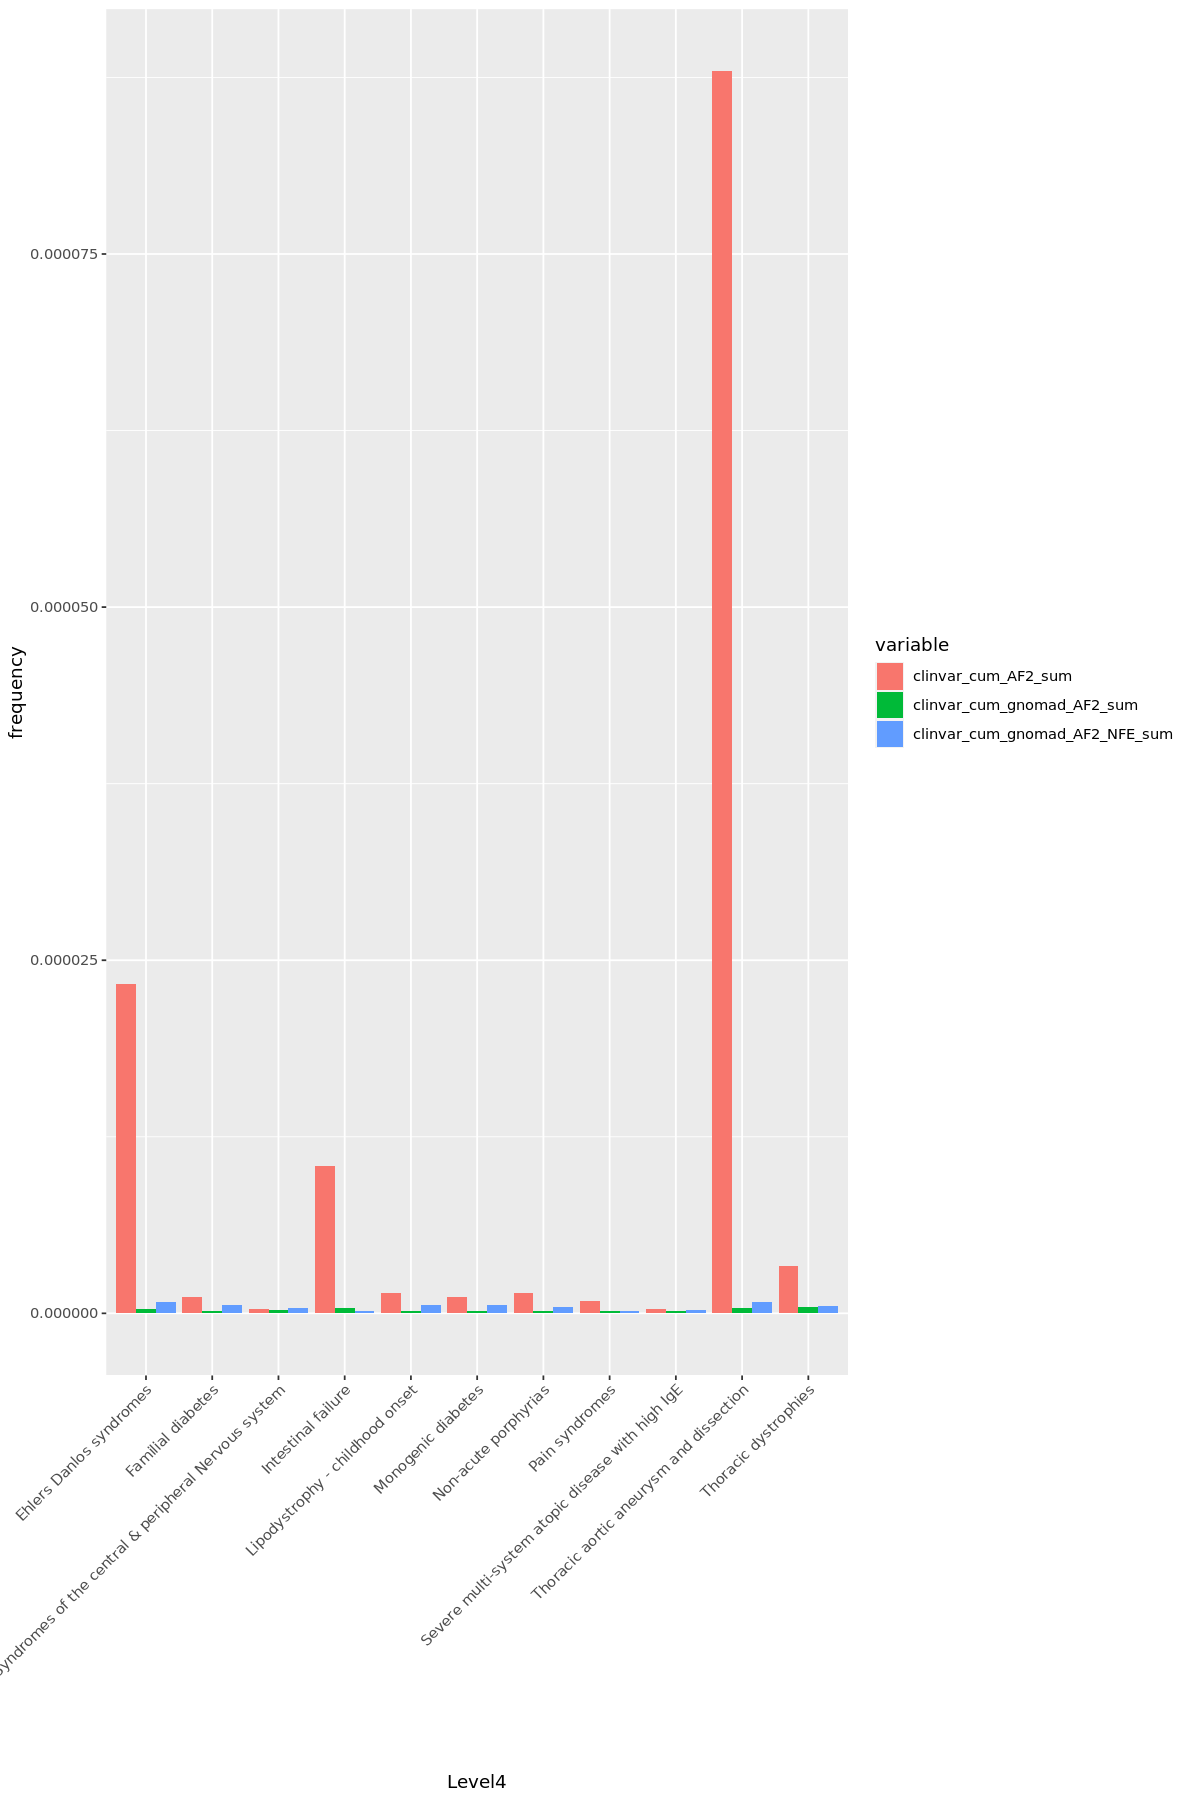

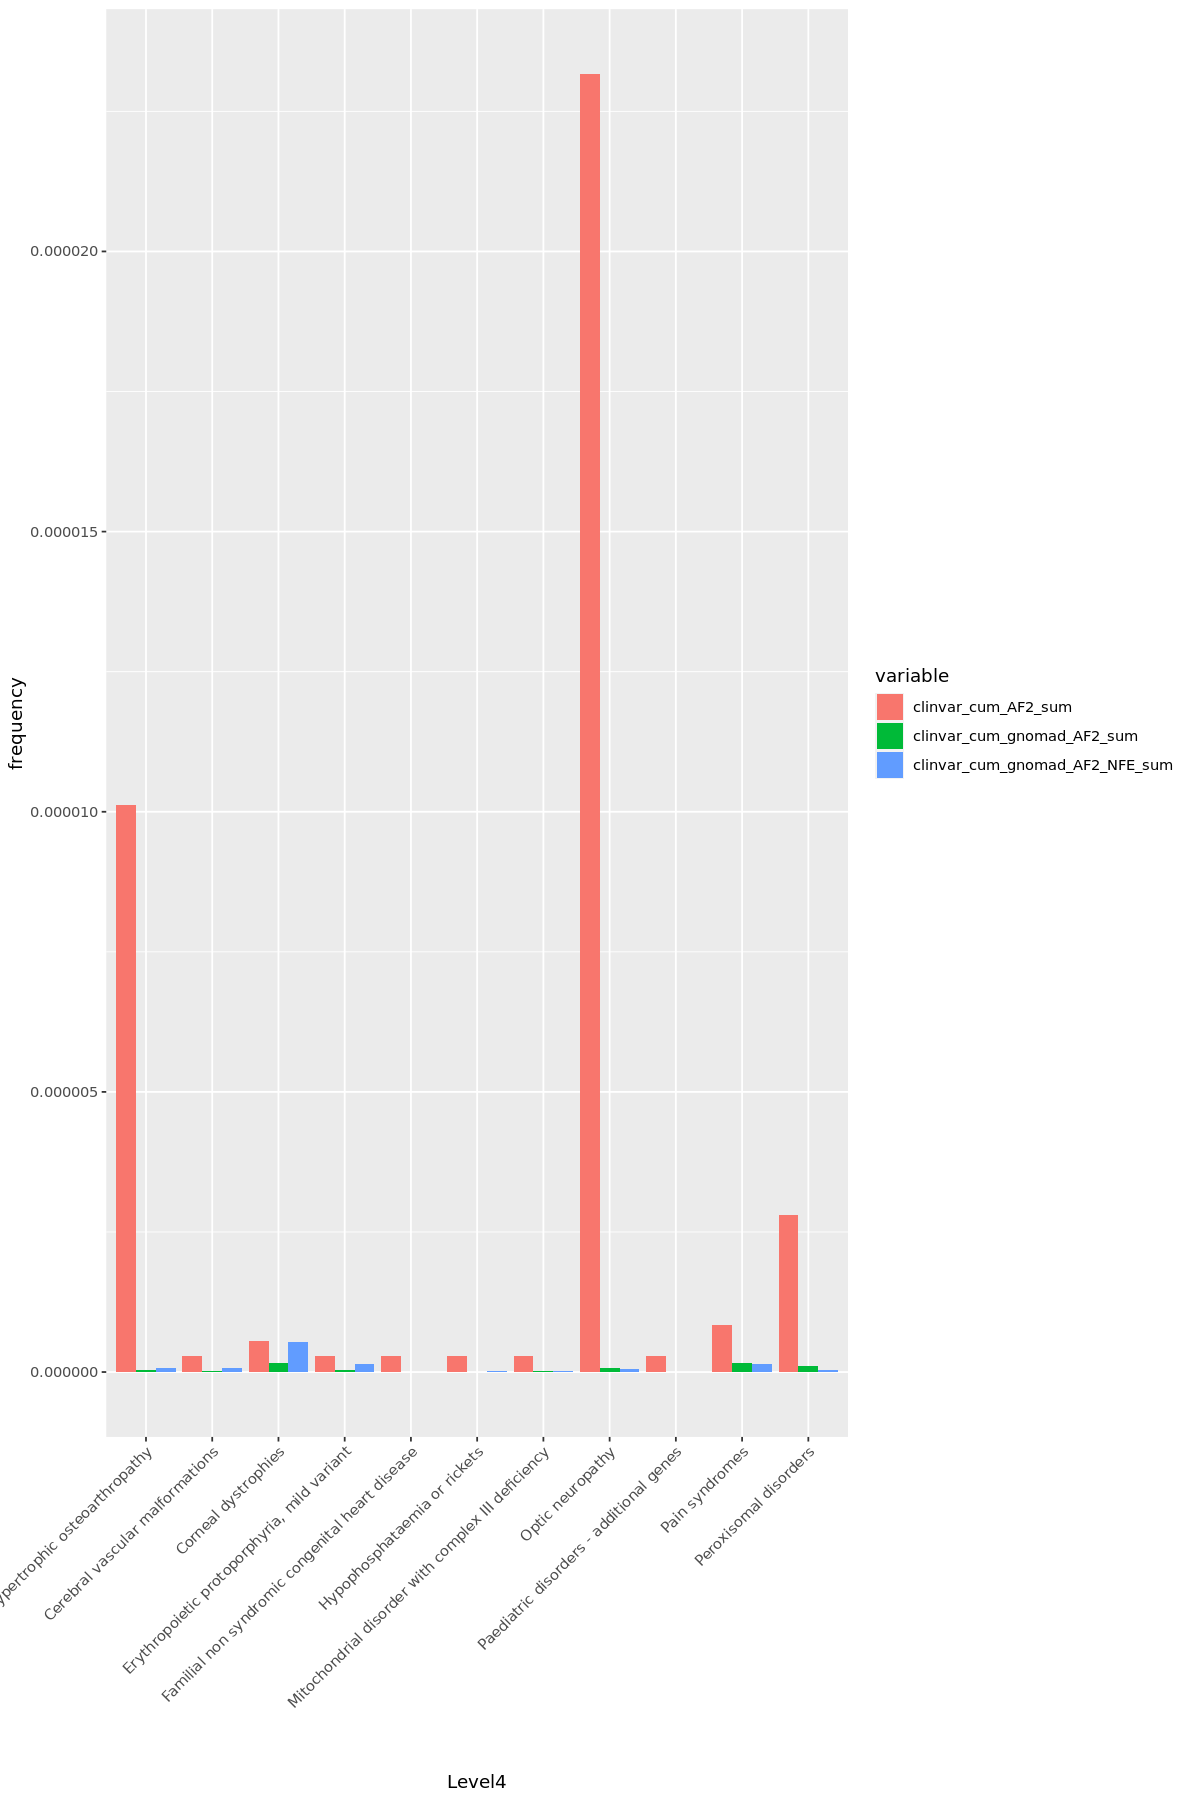

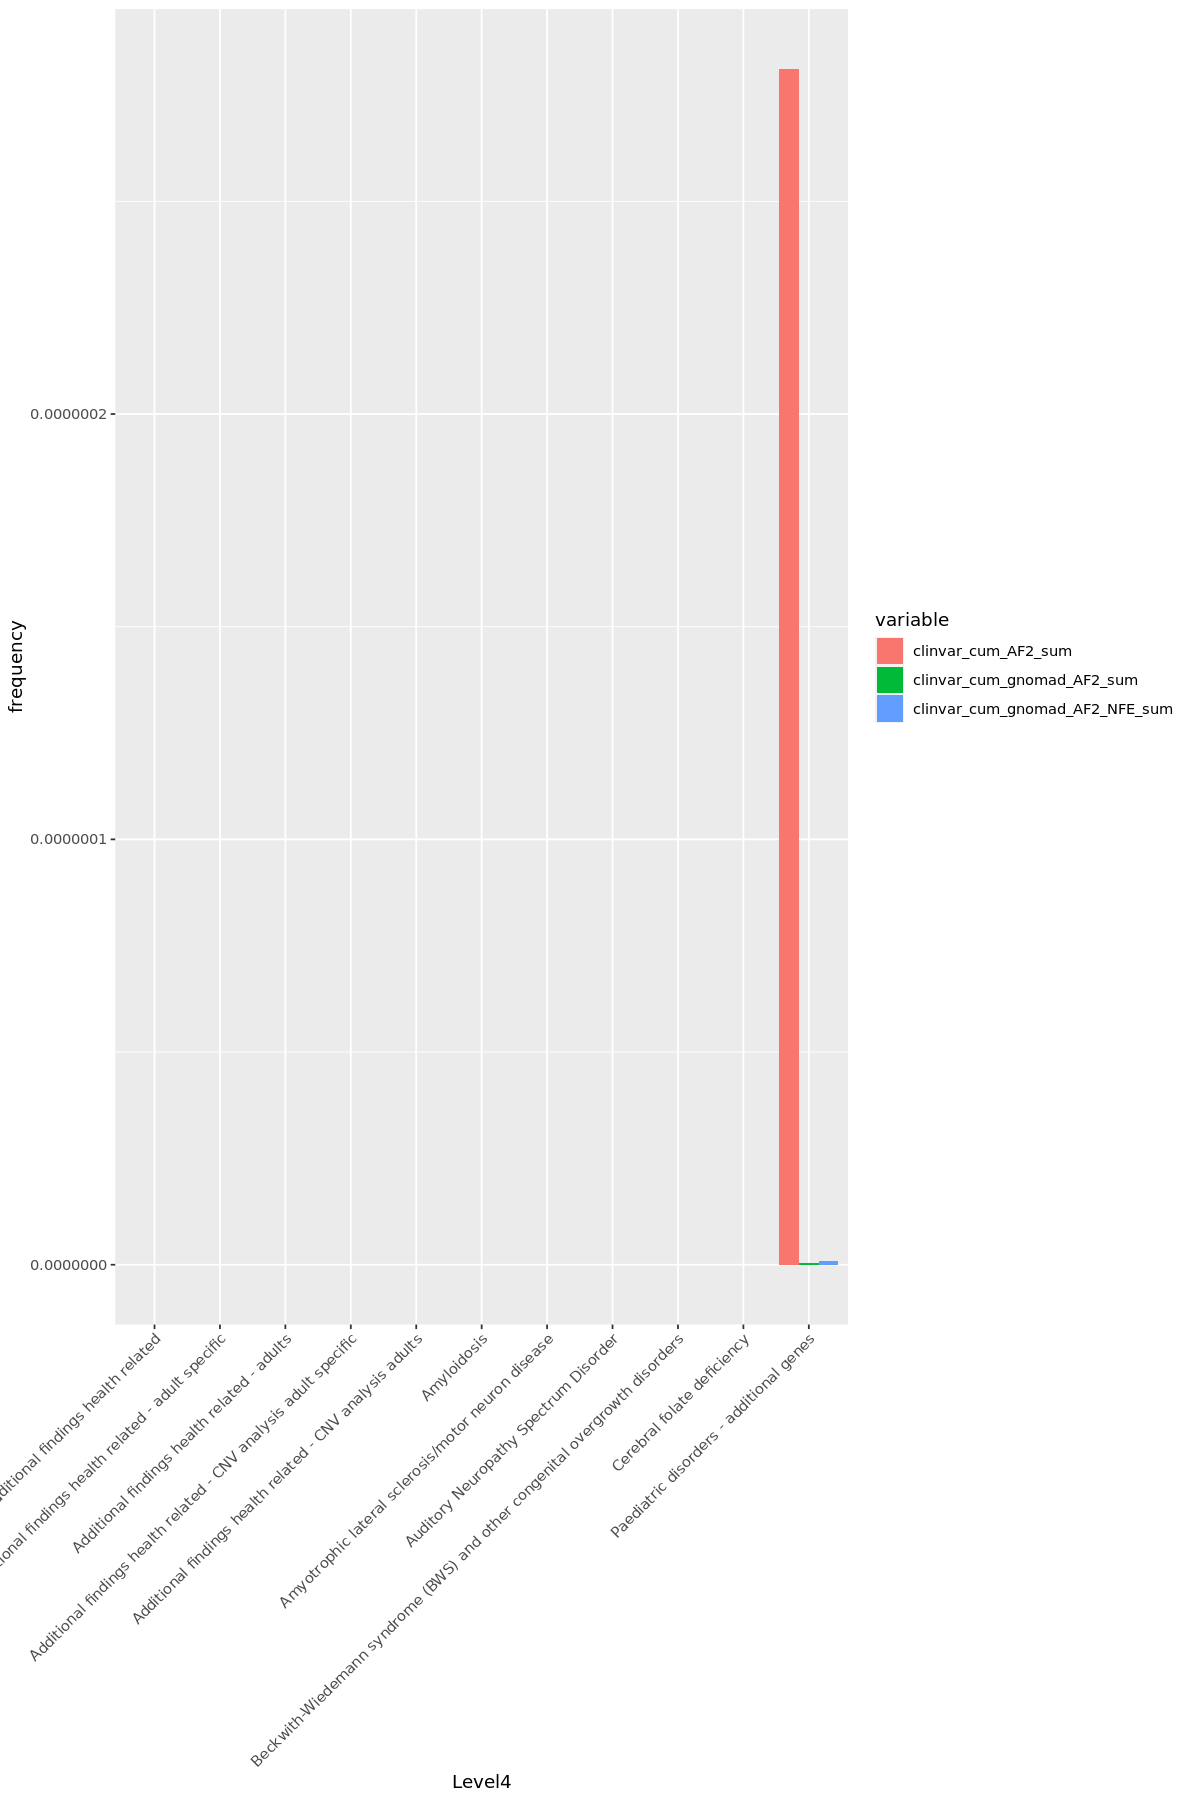

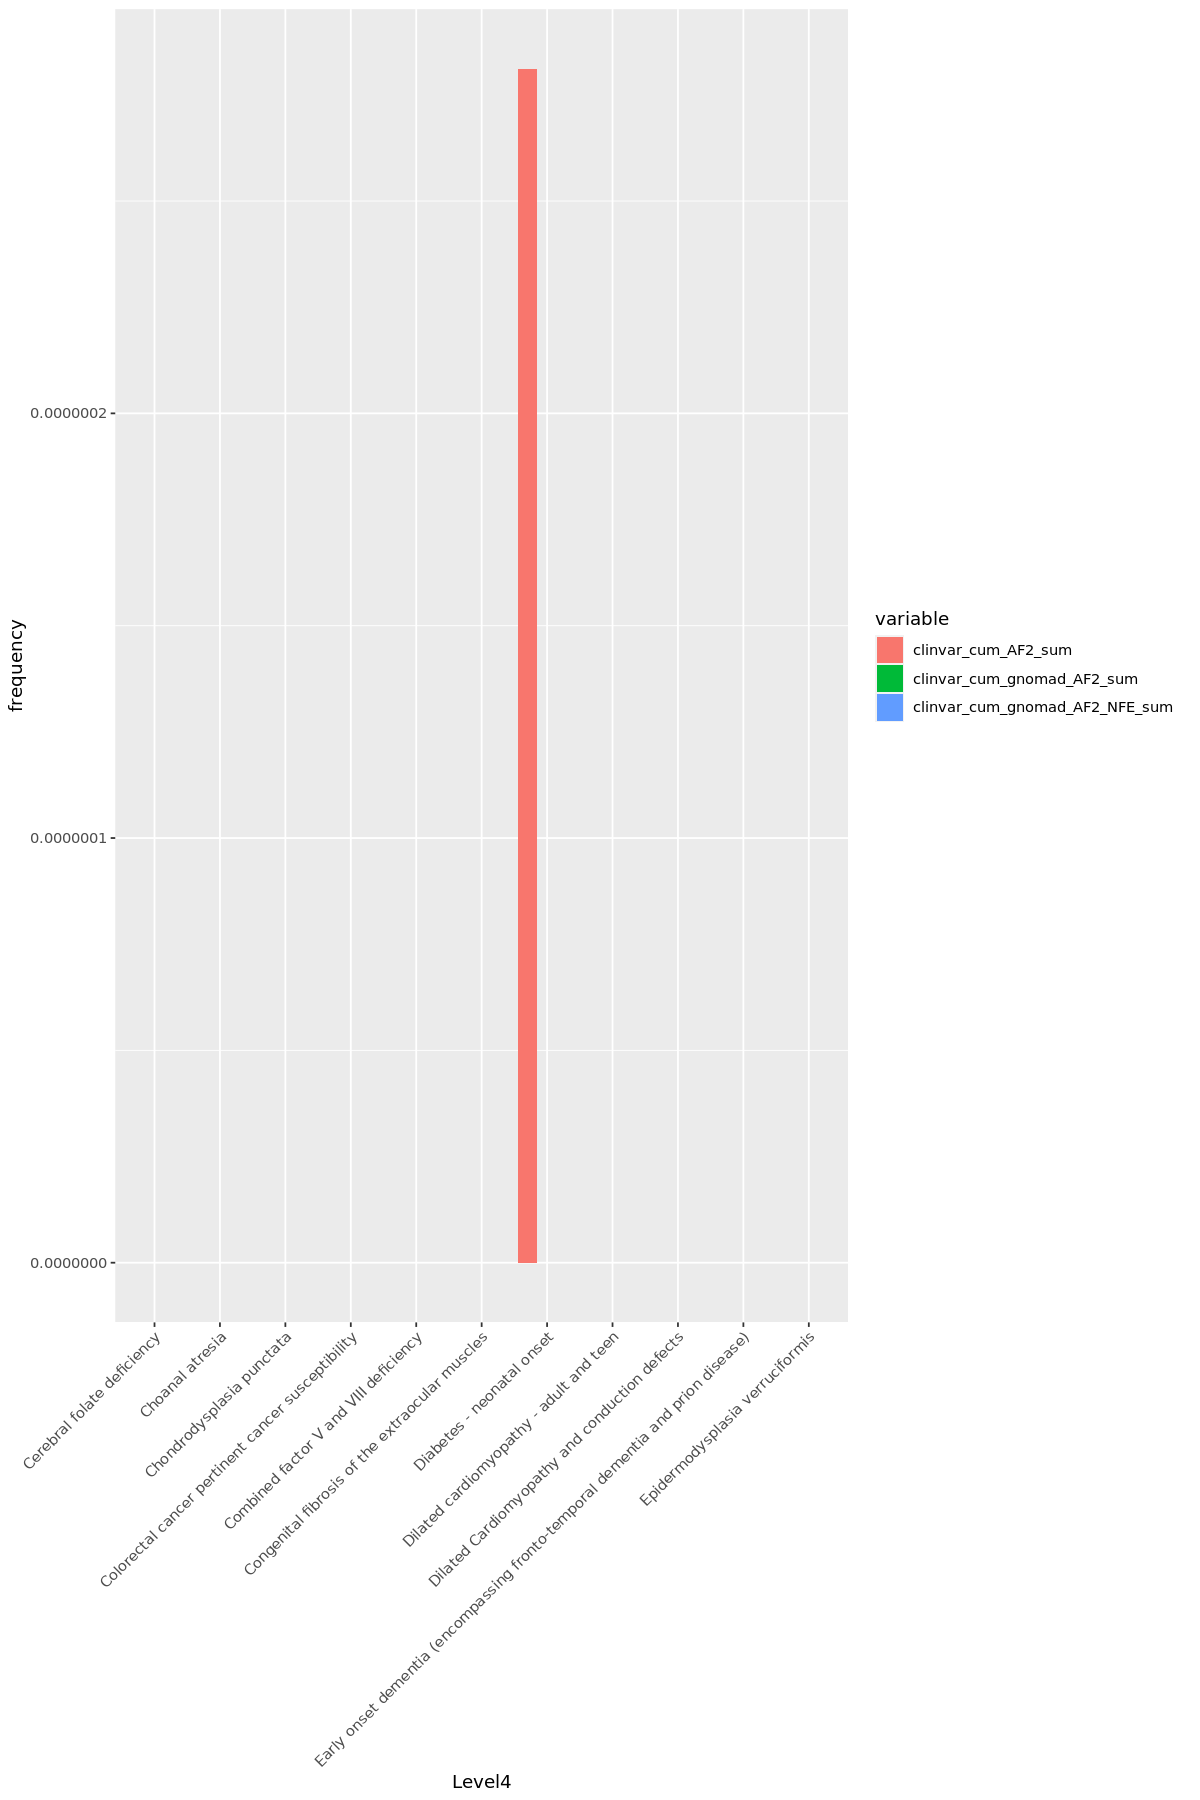

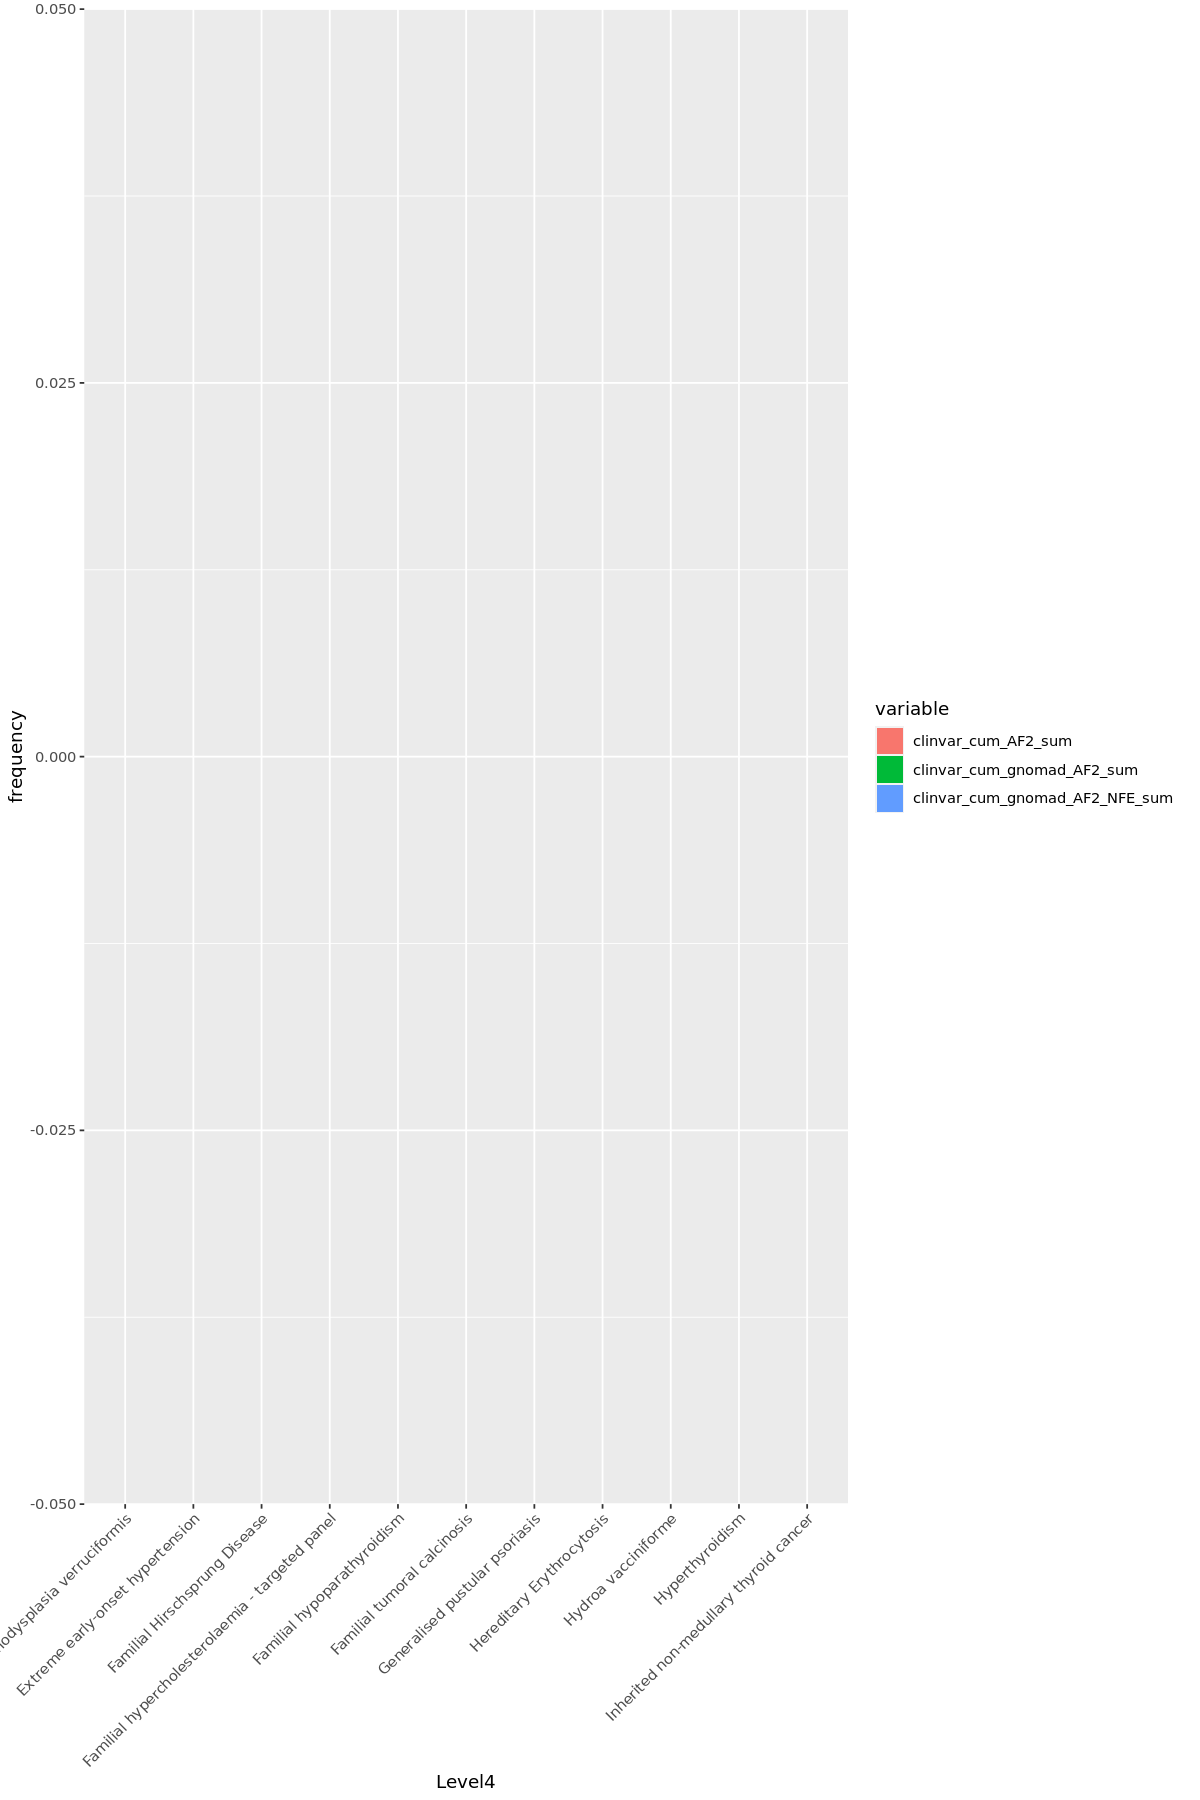

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]

[[19]]

[[20]]

[[21]]

[[22]]

[[23]]

[[24]]

[[25]]


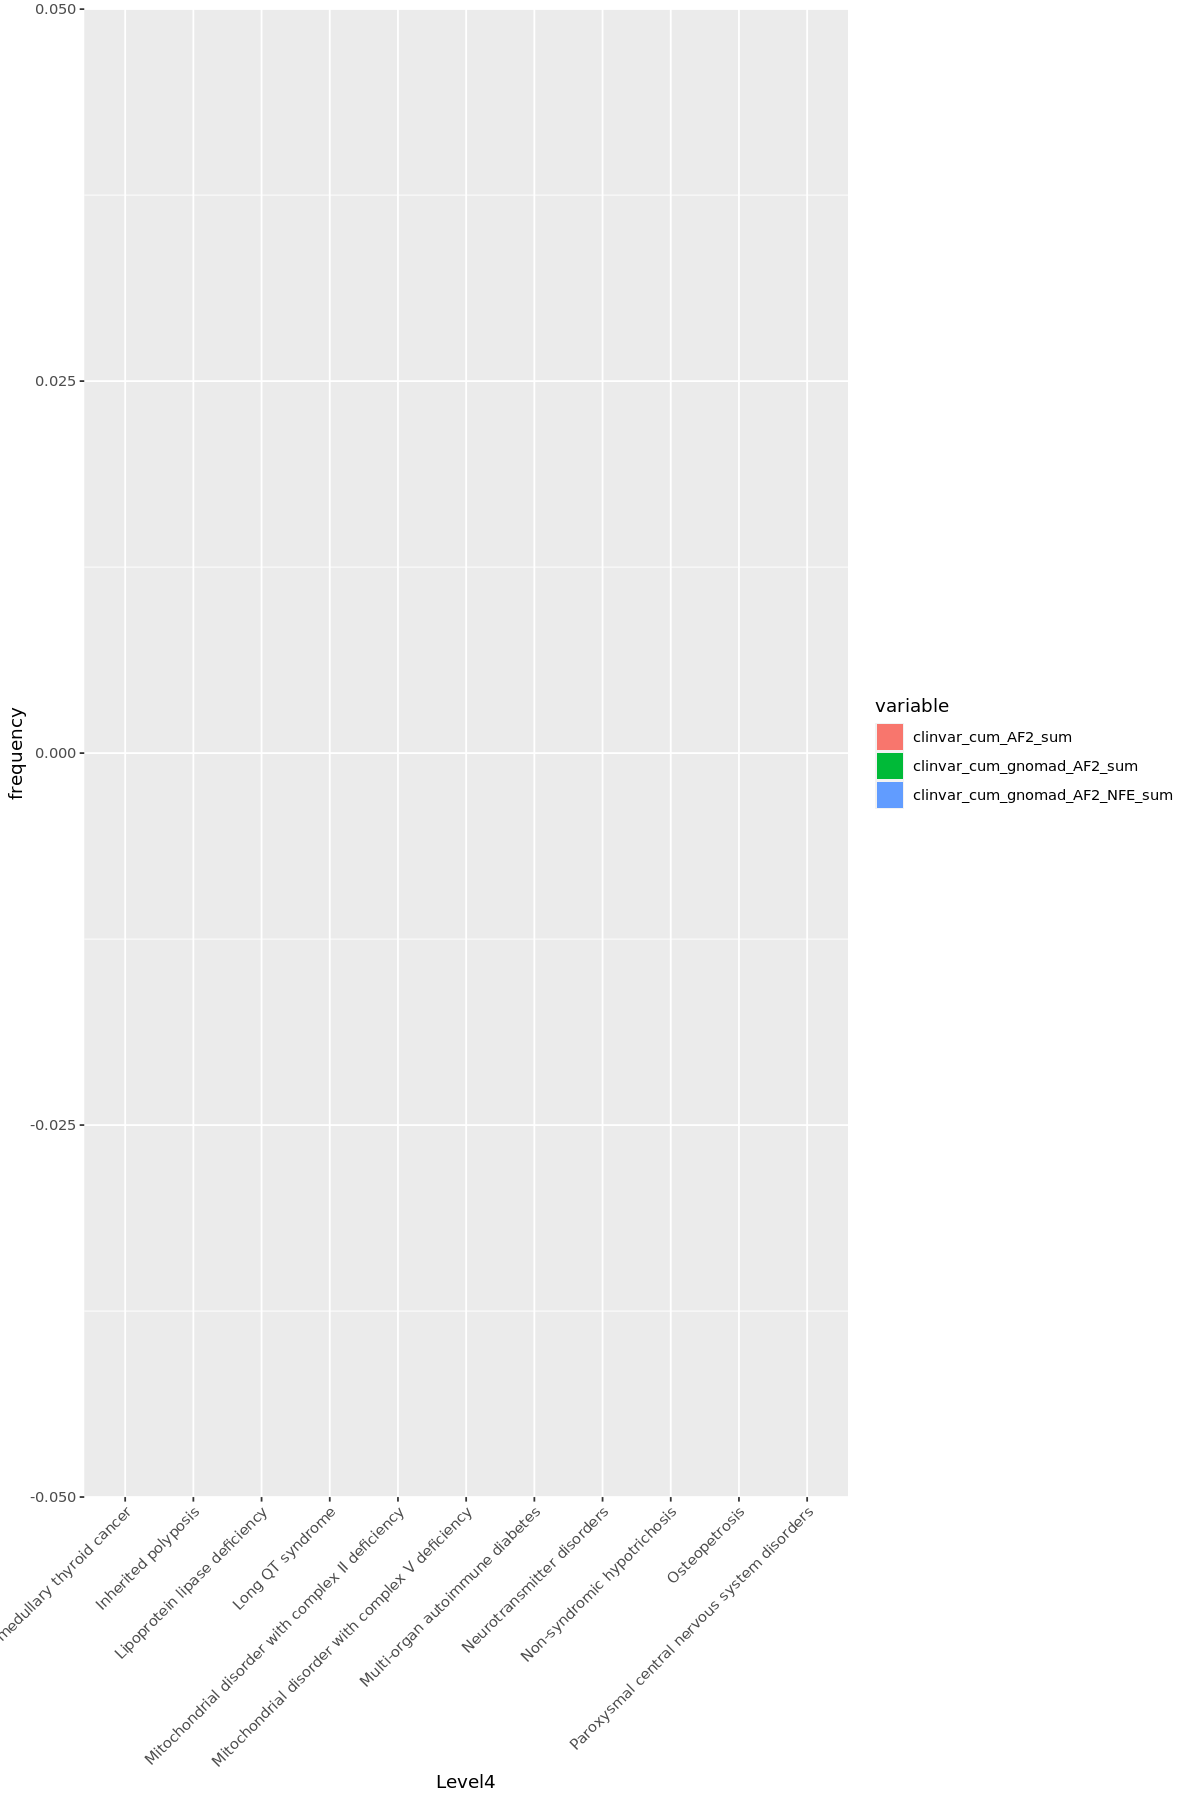

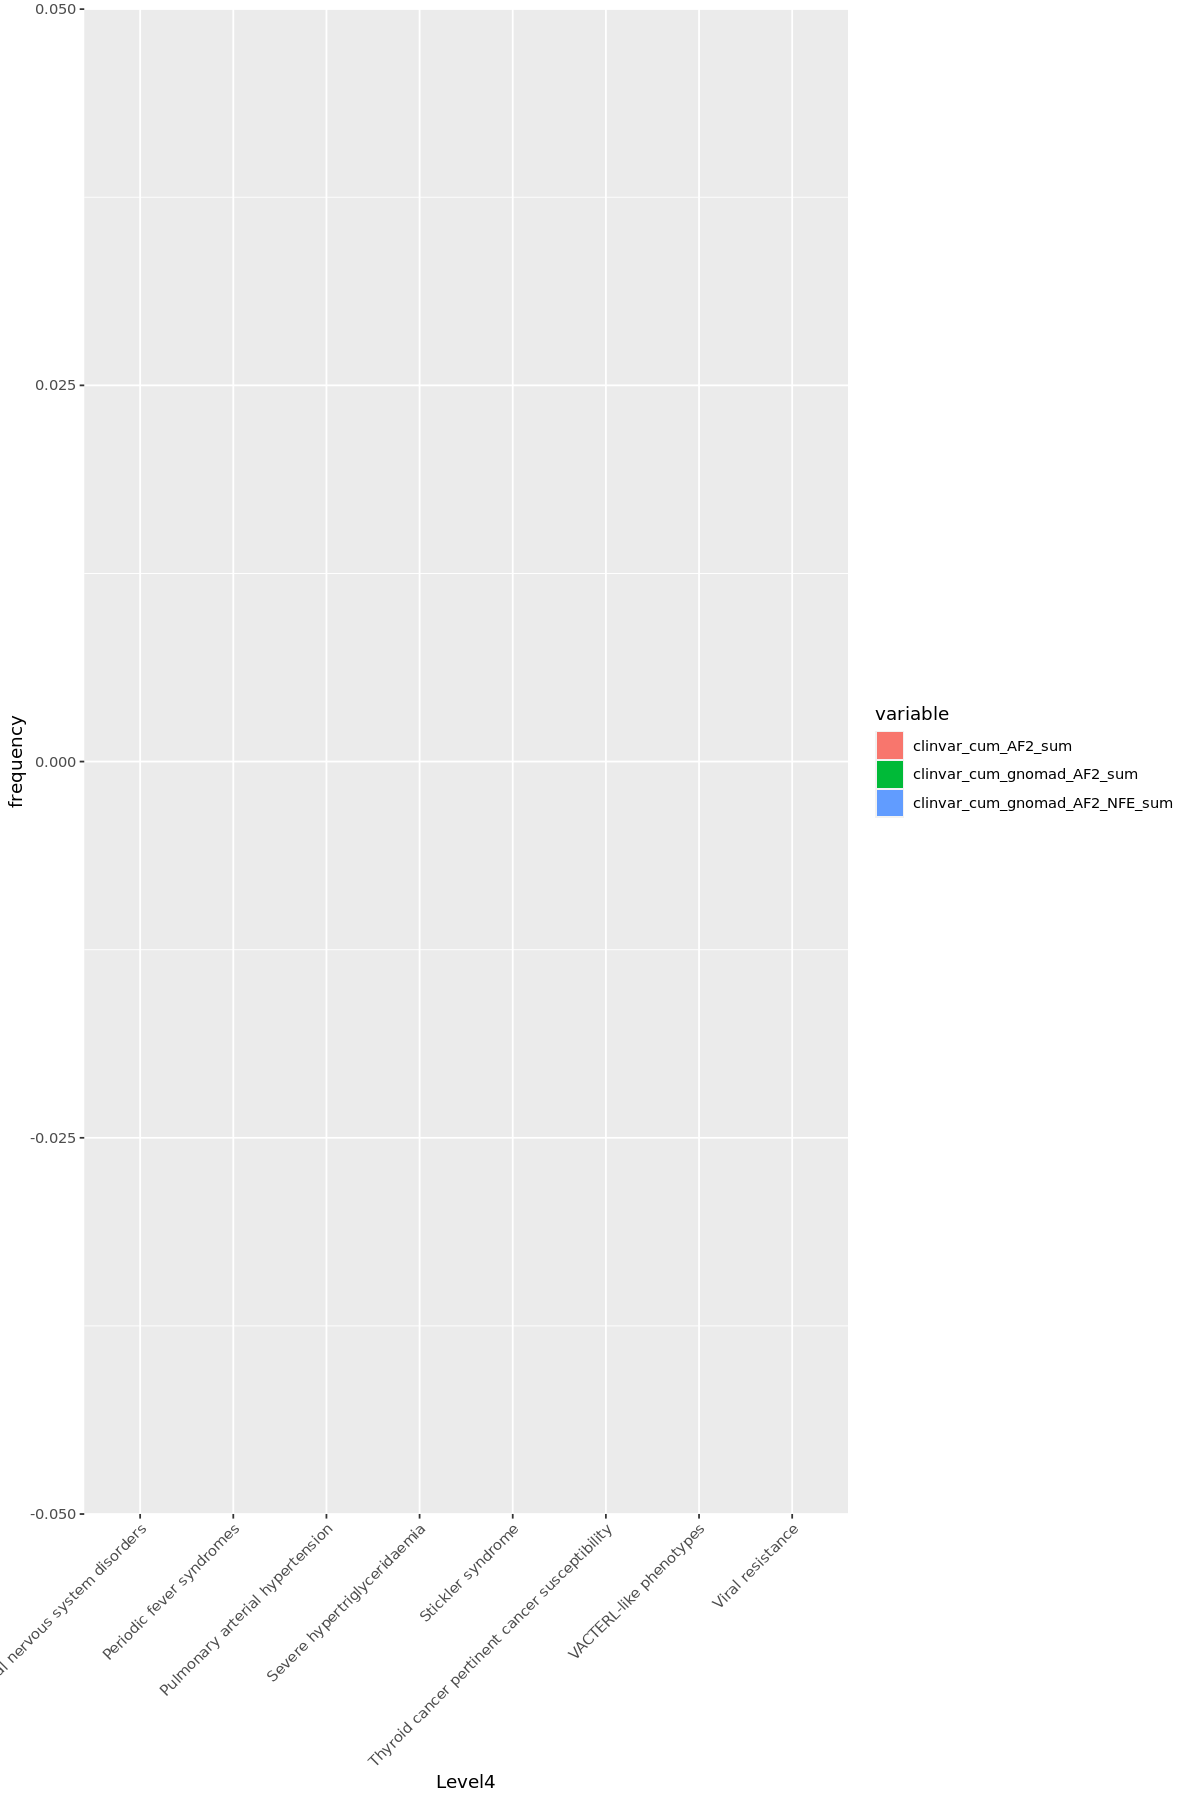

In [255]:
idx_list <- split(1:nrow(allPanelsDT3_unique), 1:10)

allPanelsDT3_unique <- allPanelsDT3_unique[order(clinvar_cum_gnomad_AF2_sum, decreasing=T)]
lapply(1:25, function(i){
    start <- ((i-1)*10+1)
    idx <- c(start:min(nrow(allPanelsDT3_unique),start+10))
    
melt_panel_clinvar <- melt(allPanelsDT3_unique[idx],  measure.vars = c("clinvar_cum_AF2_sum", "clinvar_cum_gnomad_AF2_sum", "clinvar_cum_gnomad_AF2_NFE_sum"), value.name = c("frequency"))
#melt_panel_cadd <- melt(allPanelsDT3_unique[idx],  measure.vars = c("cadd_cum_AF2_sum", "cadd_cum_gnomad_AF2_sum", "cadd_cum_gnomad_AF2_NFE_sum"), value.name = c("frequency"))

#library(repr)
#options(repr.plot.width=10, repr.plot.height=15)

p1 <- ggplot(data=melt_panel_clinvar, aes(x=Level4, y=frequency, fill=variable)) +
    geom_bar(stat="identity", position=position_dodge()) +
    theme(axis.text.x = element_text(angle = 45, hjust=1))

p1
})

#p2 <-     ggplot(data=melt_panel_cadd, aes(x=Level4, y=frequency, fill=variable)) +
#geom_bar(stat="identity", position=position_dodge()) +
#theme(axis.text.x = element_text(angle = 45, hjust=1))



Warning message in split.default(1:nrow(allPanelsDT3_unique), 1:10):
“data length is not a multiple of split variable”

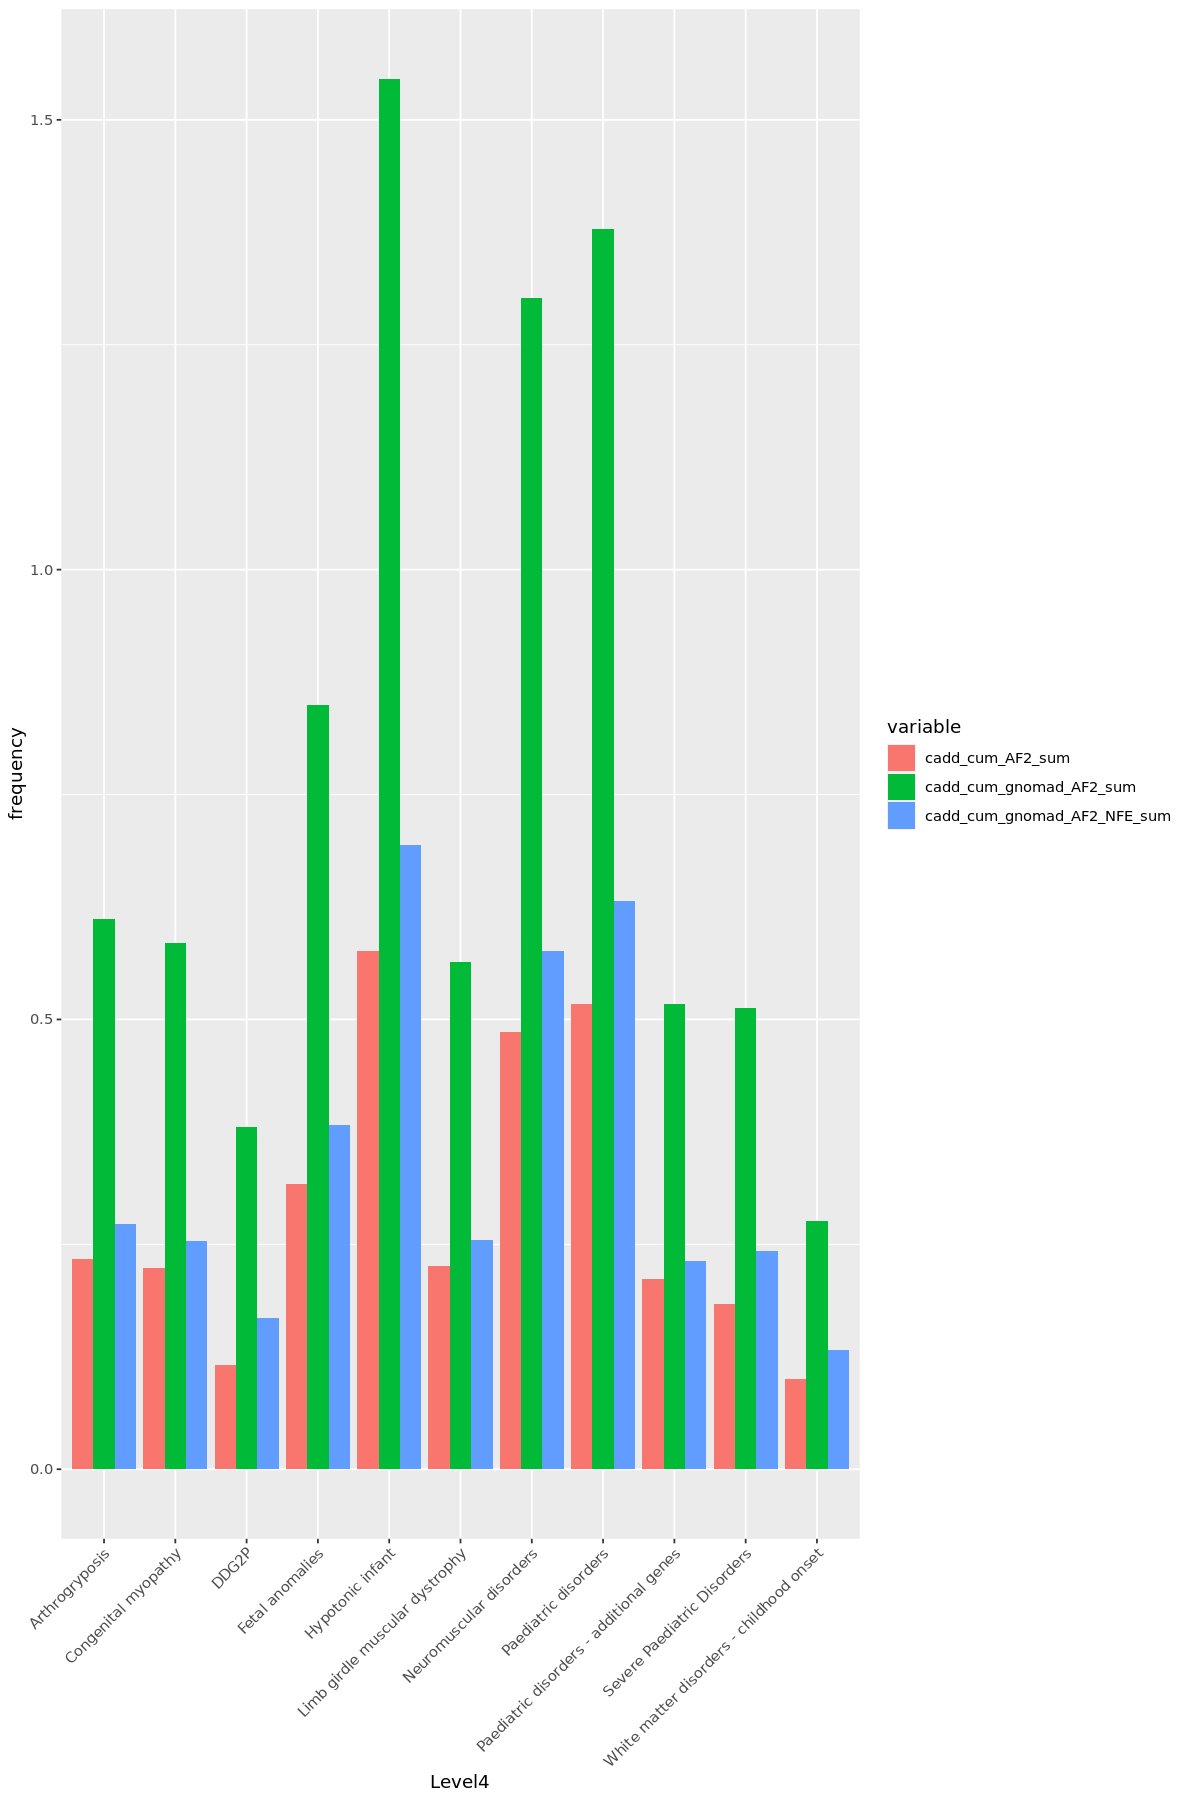

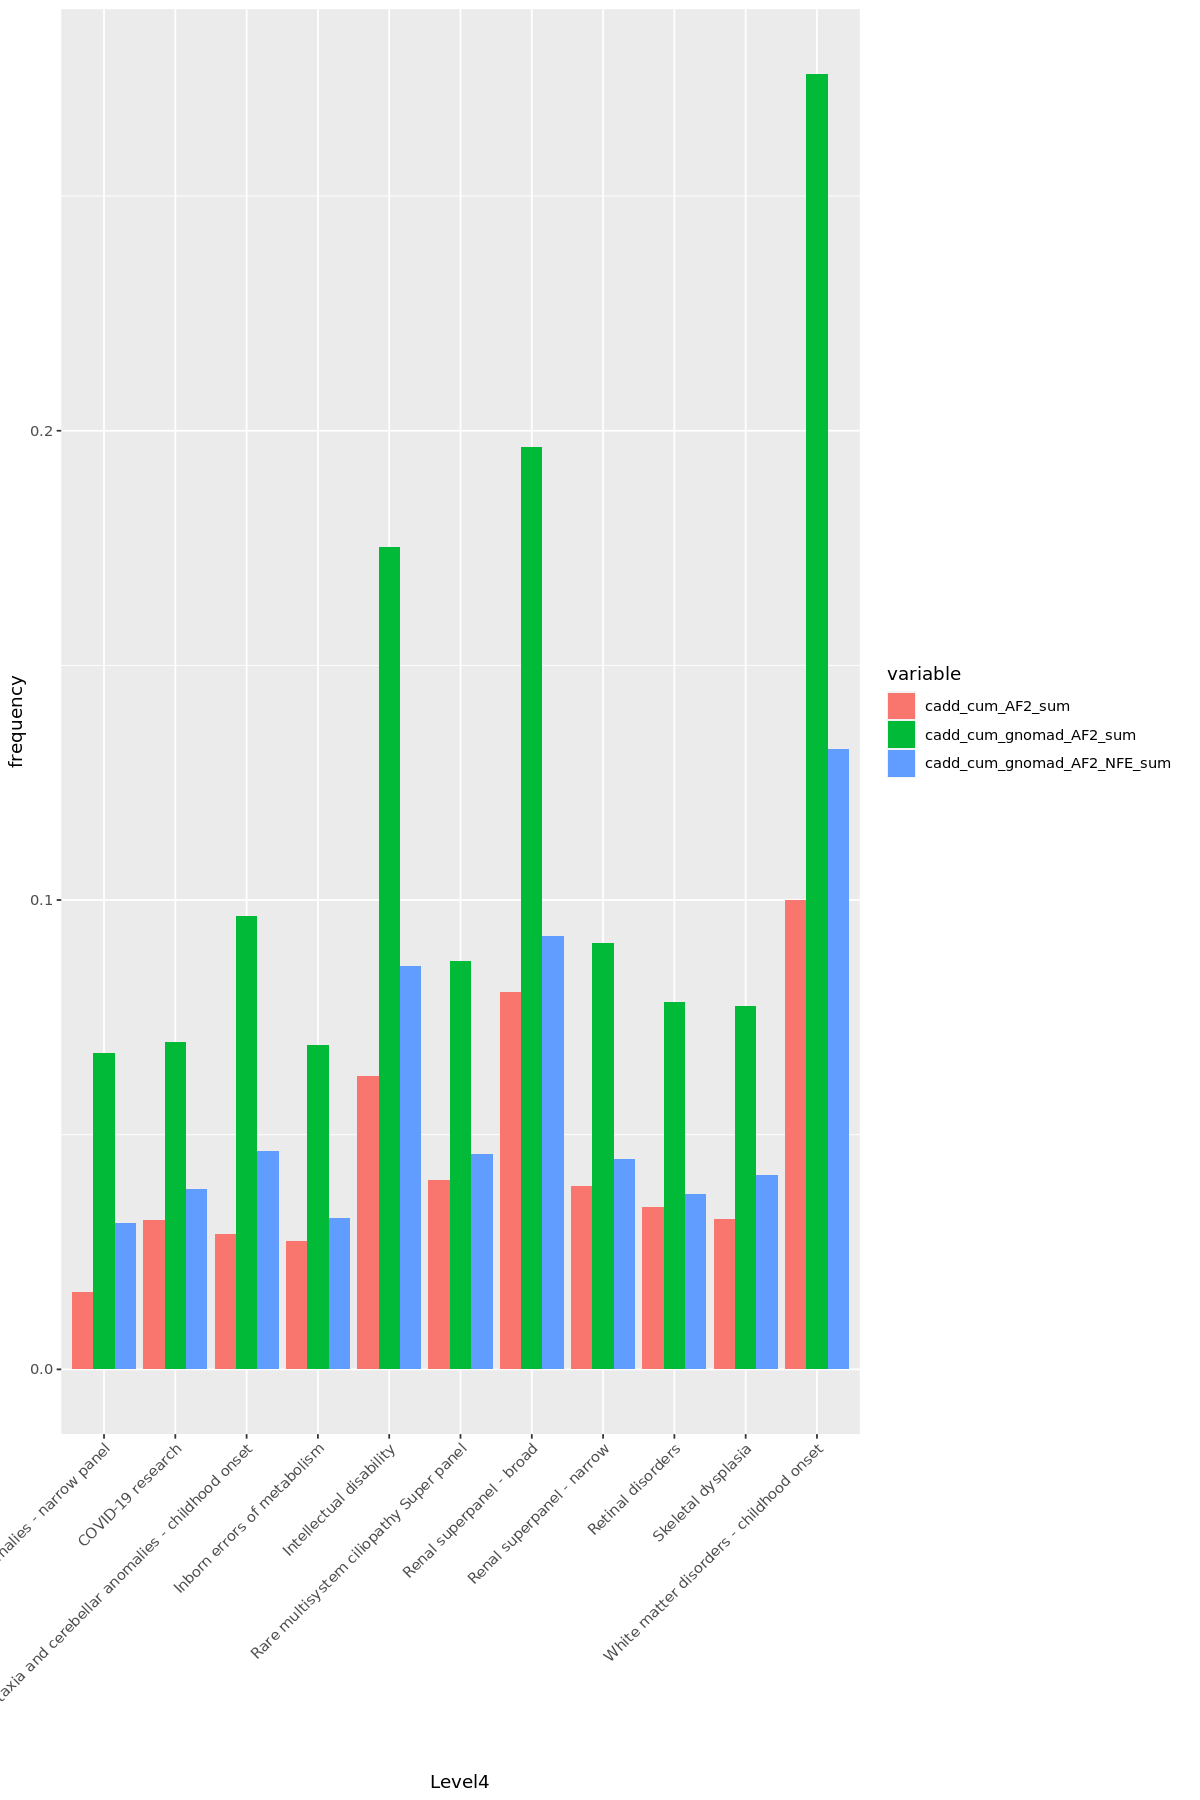

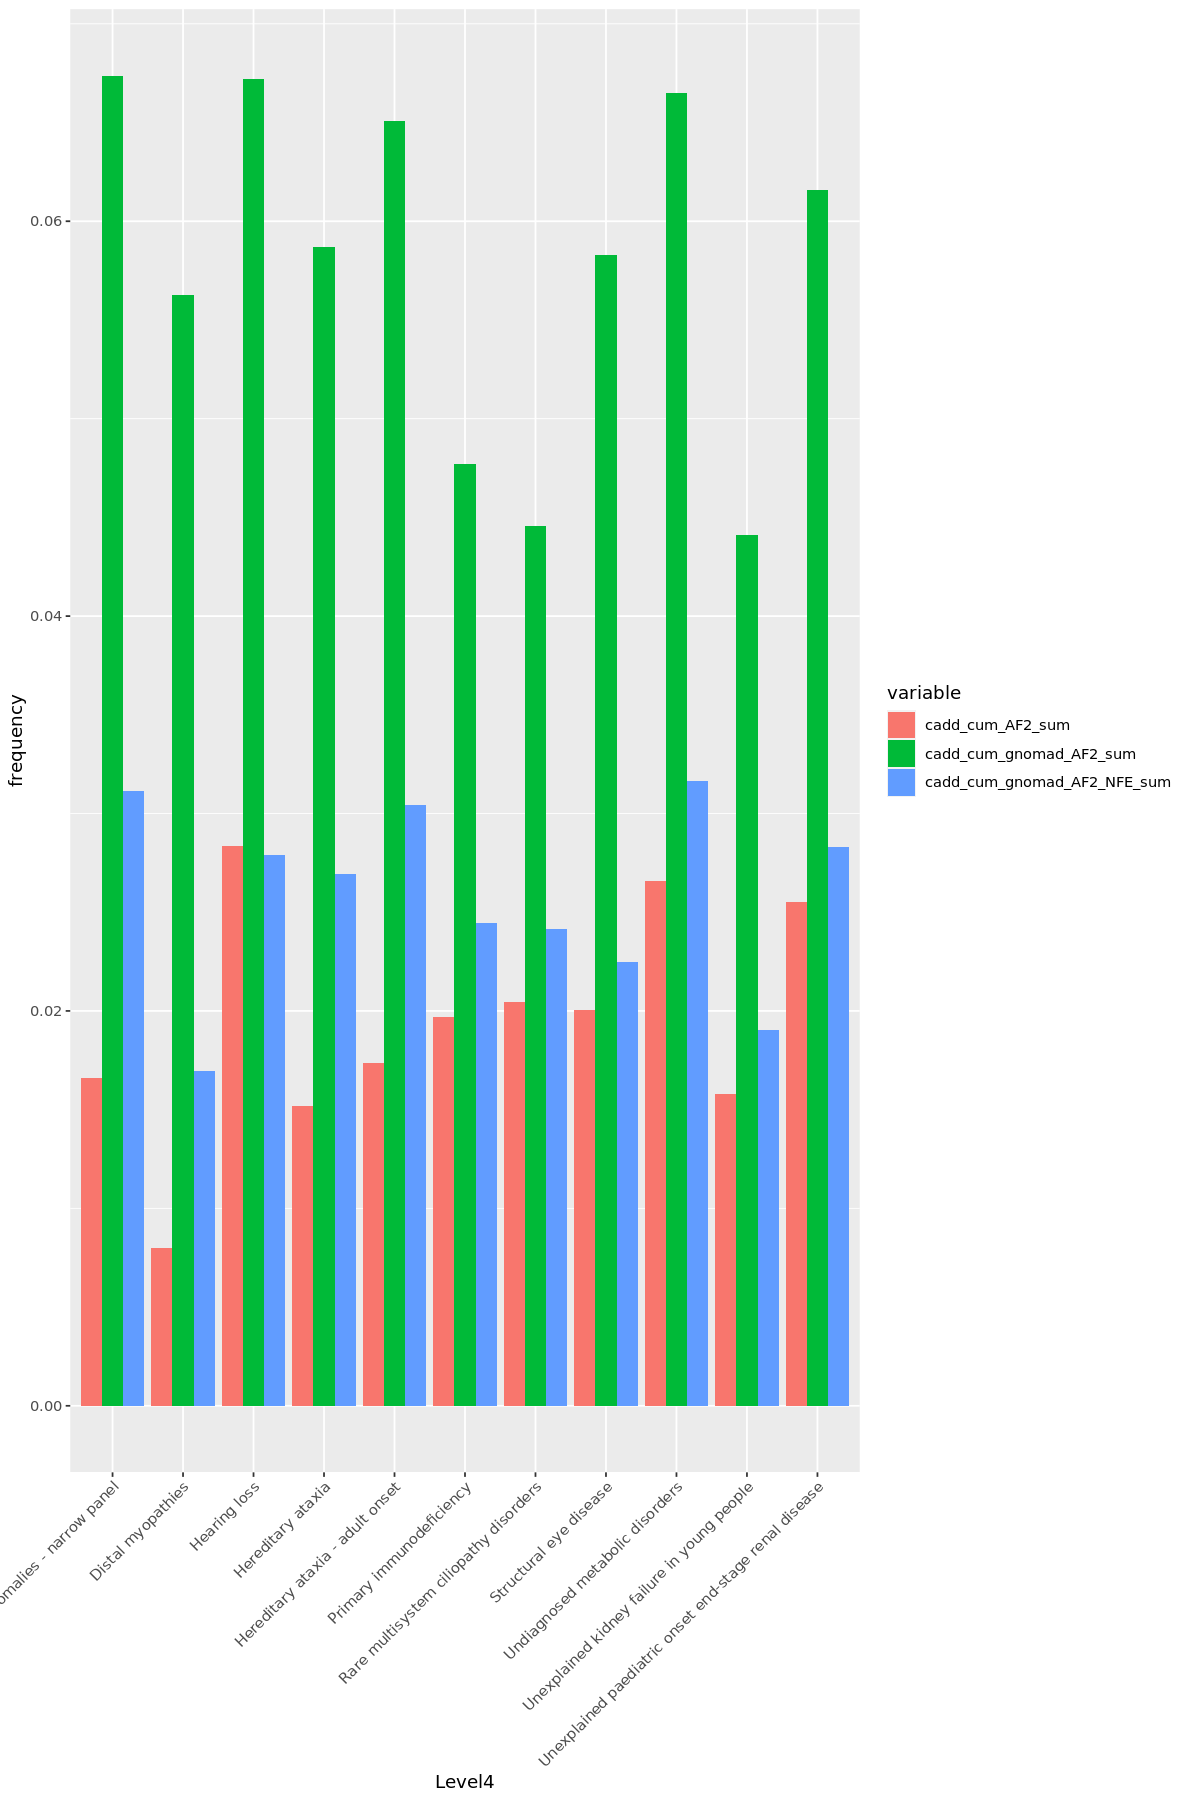

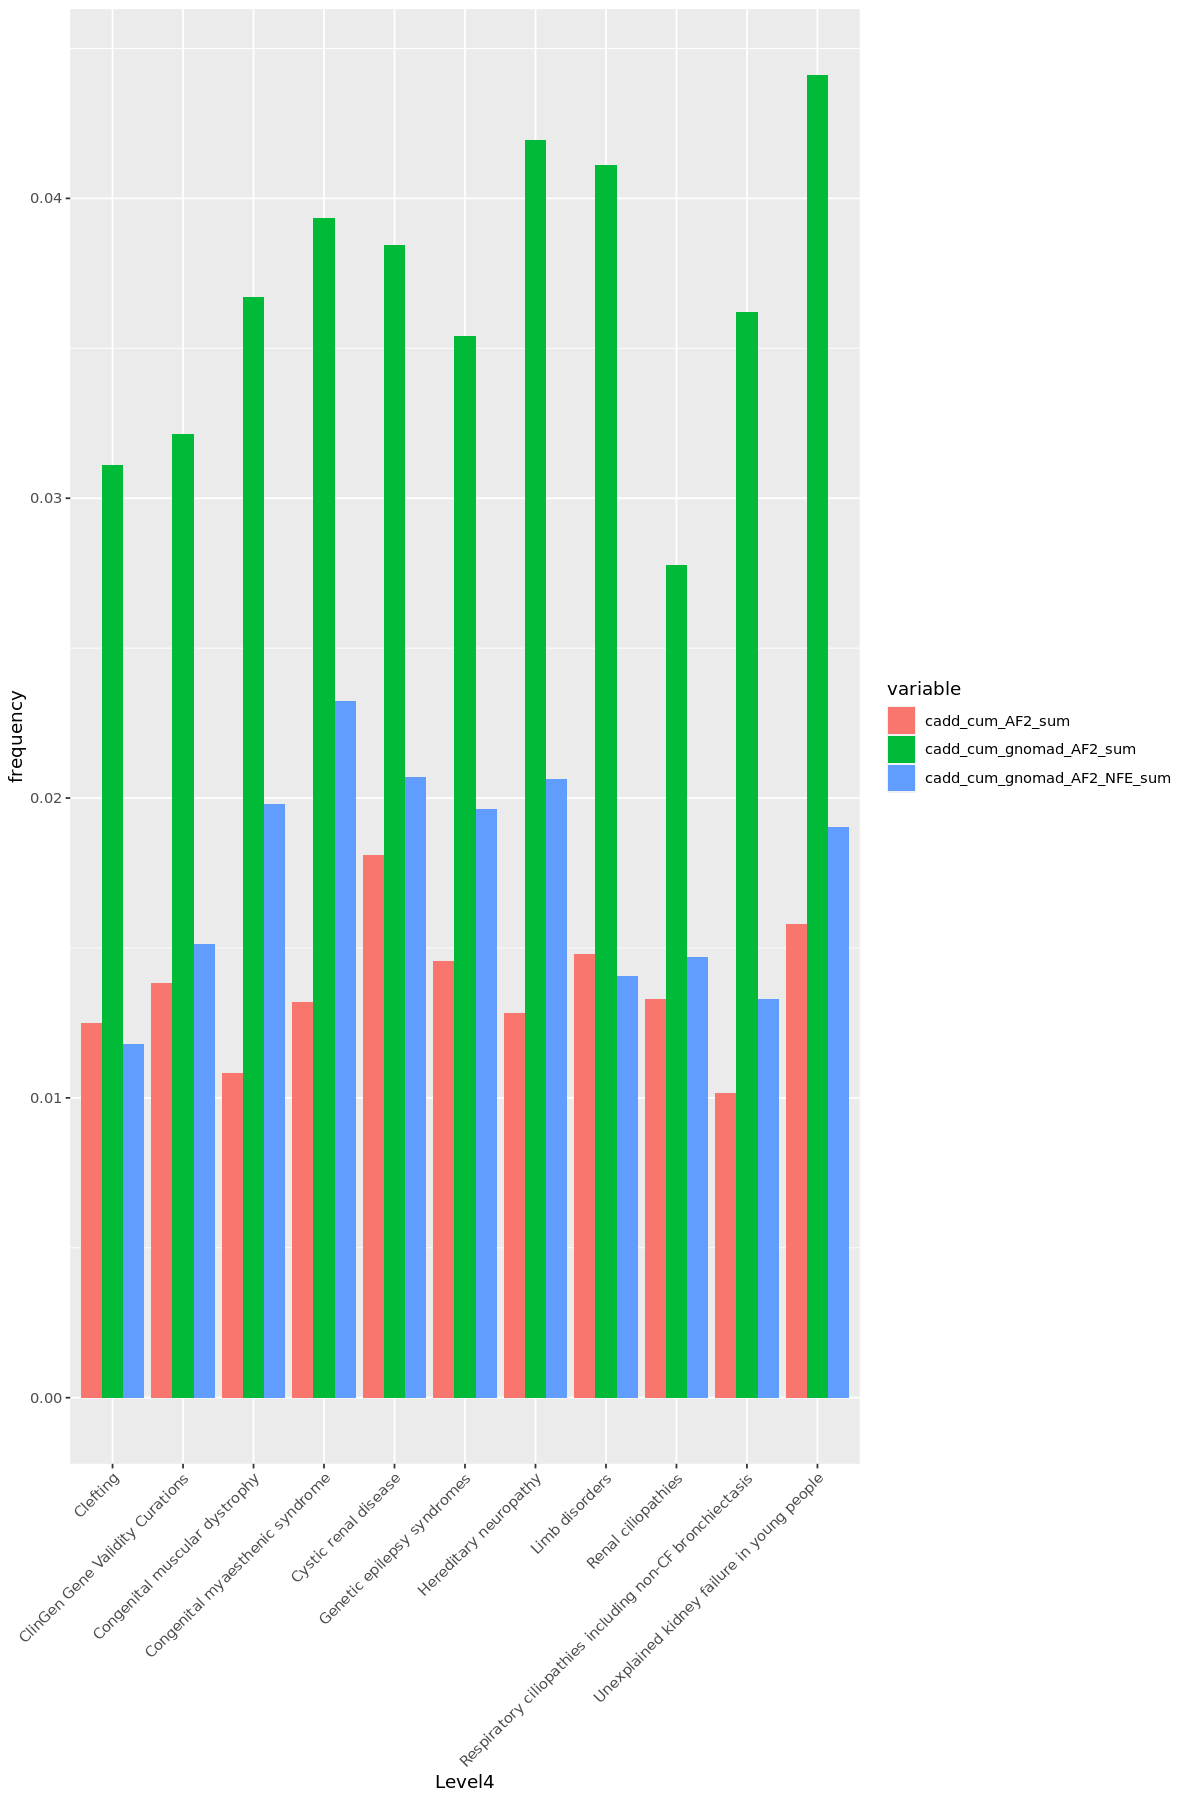

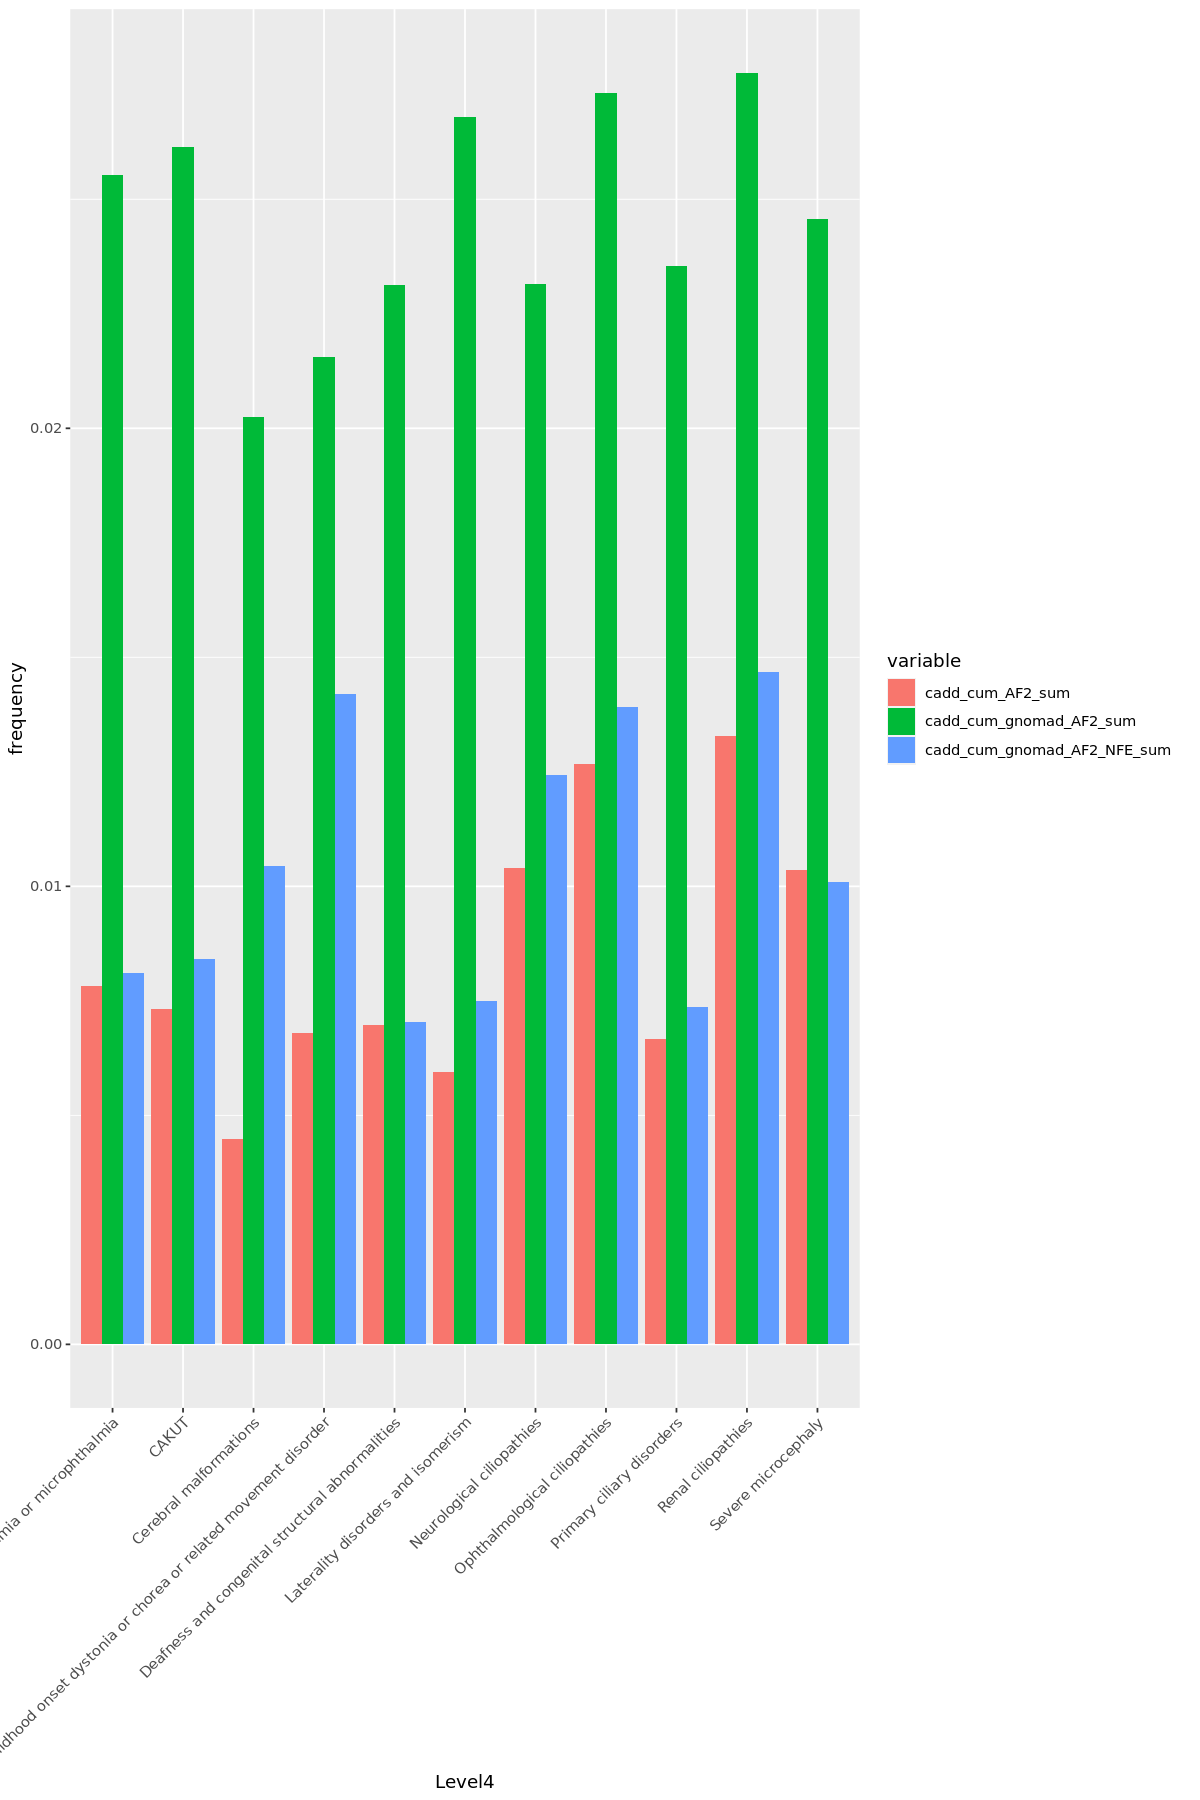

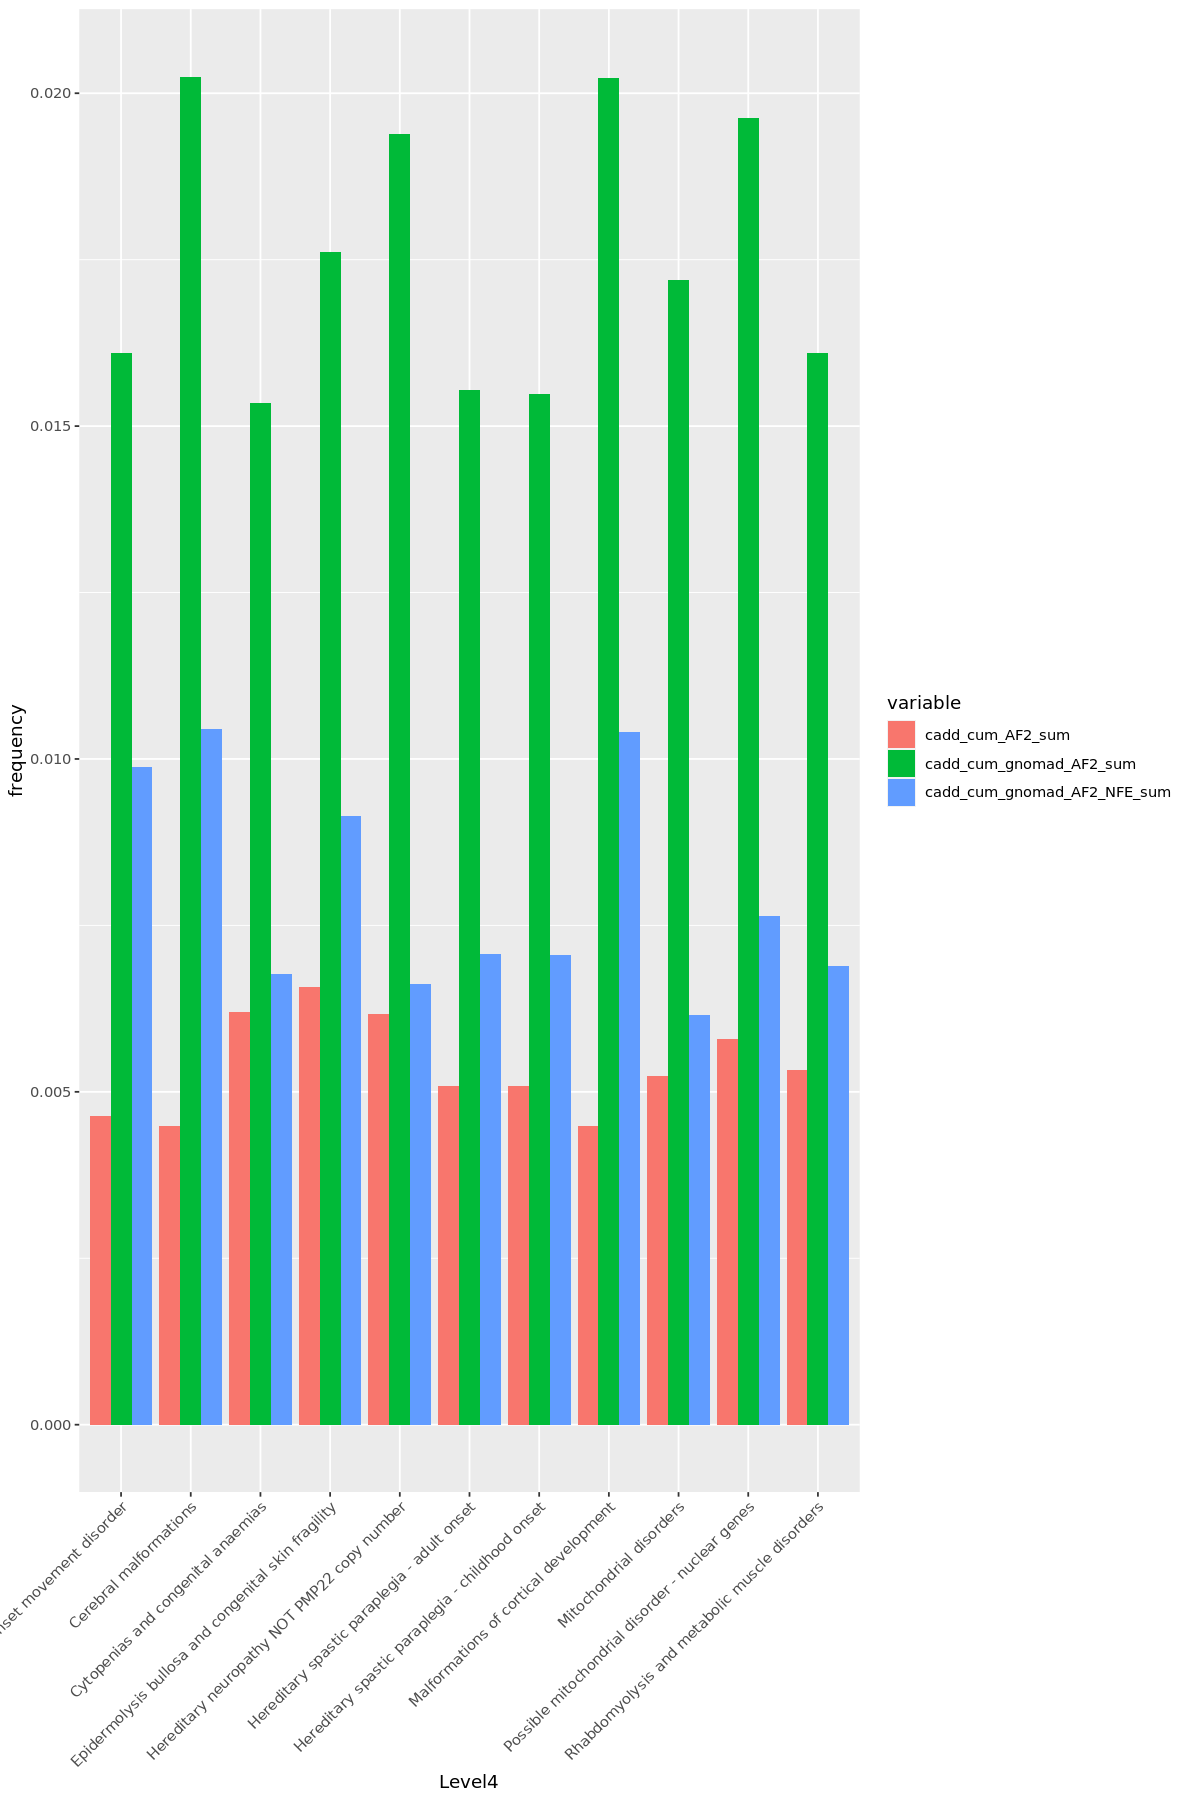

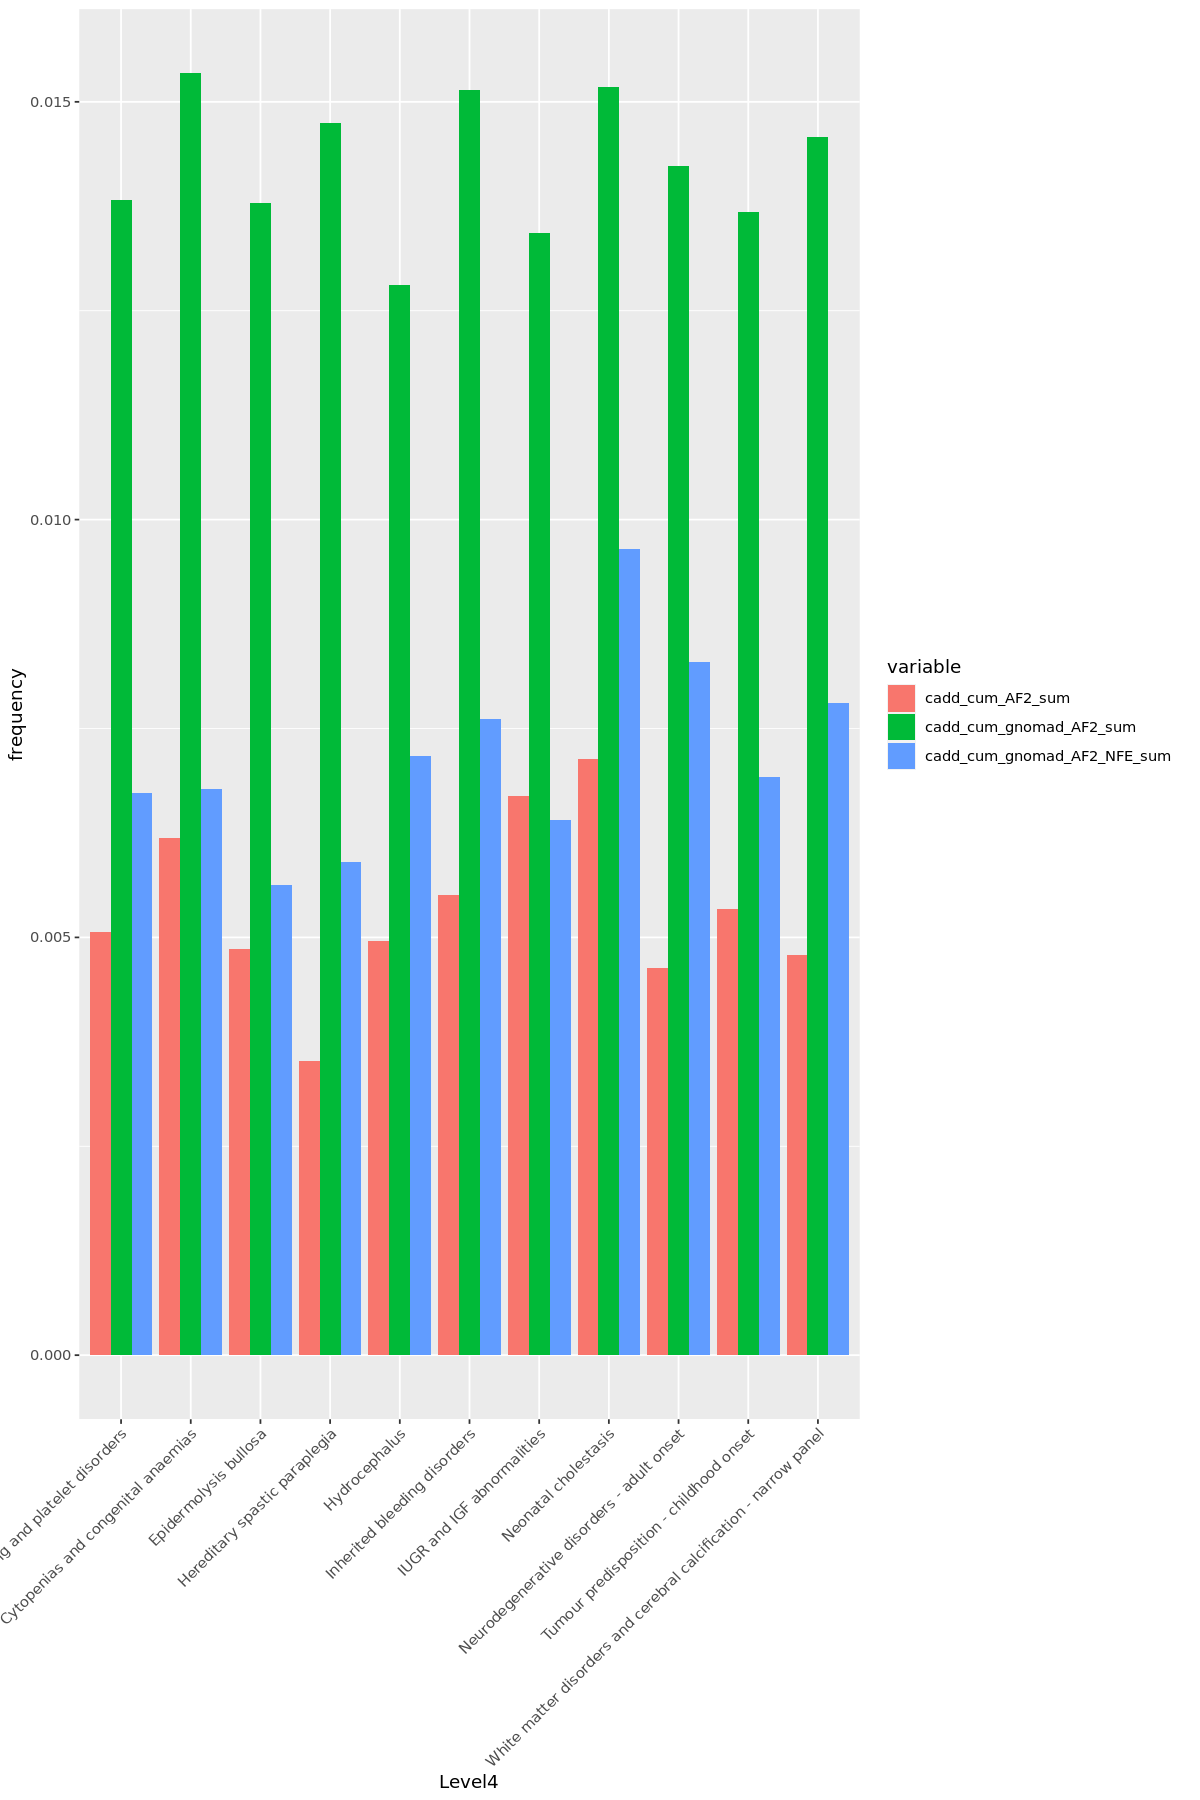

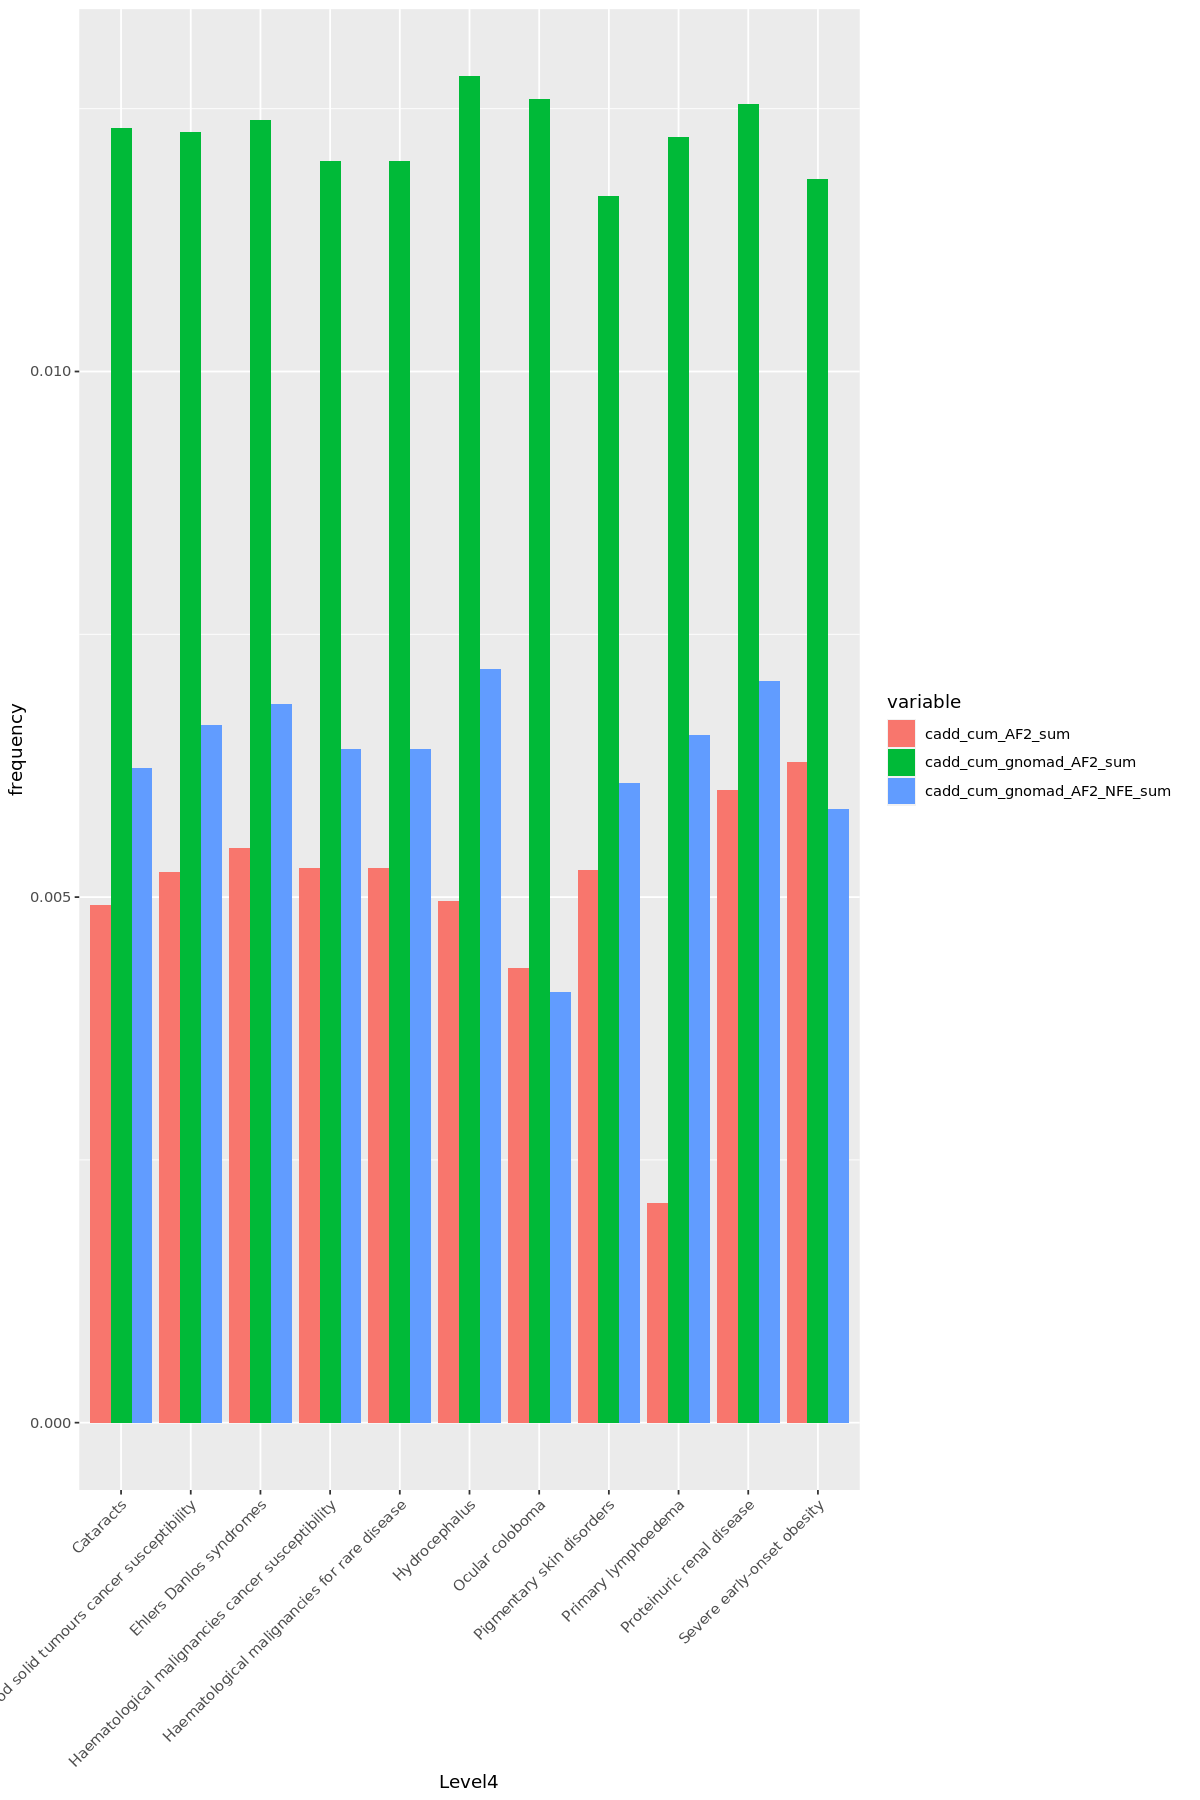

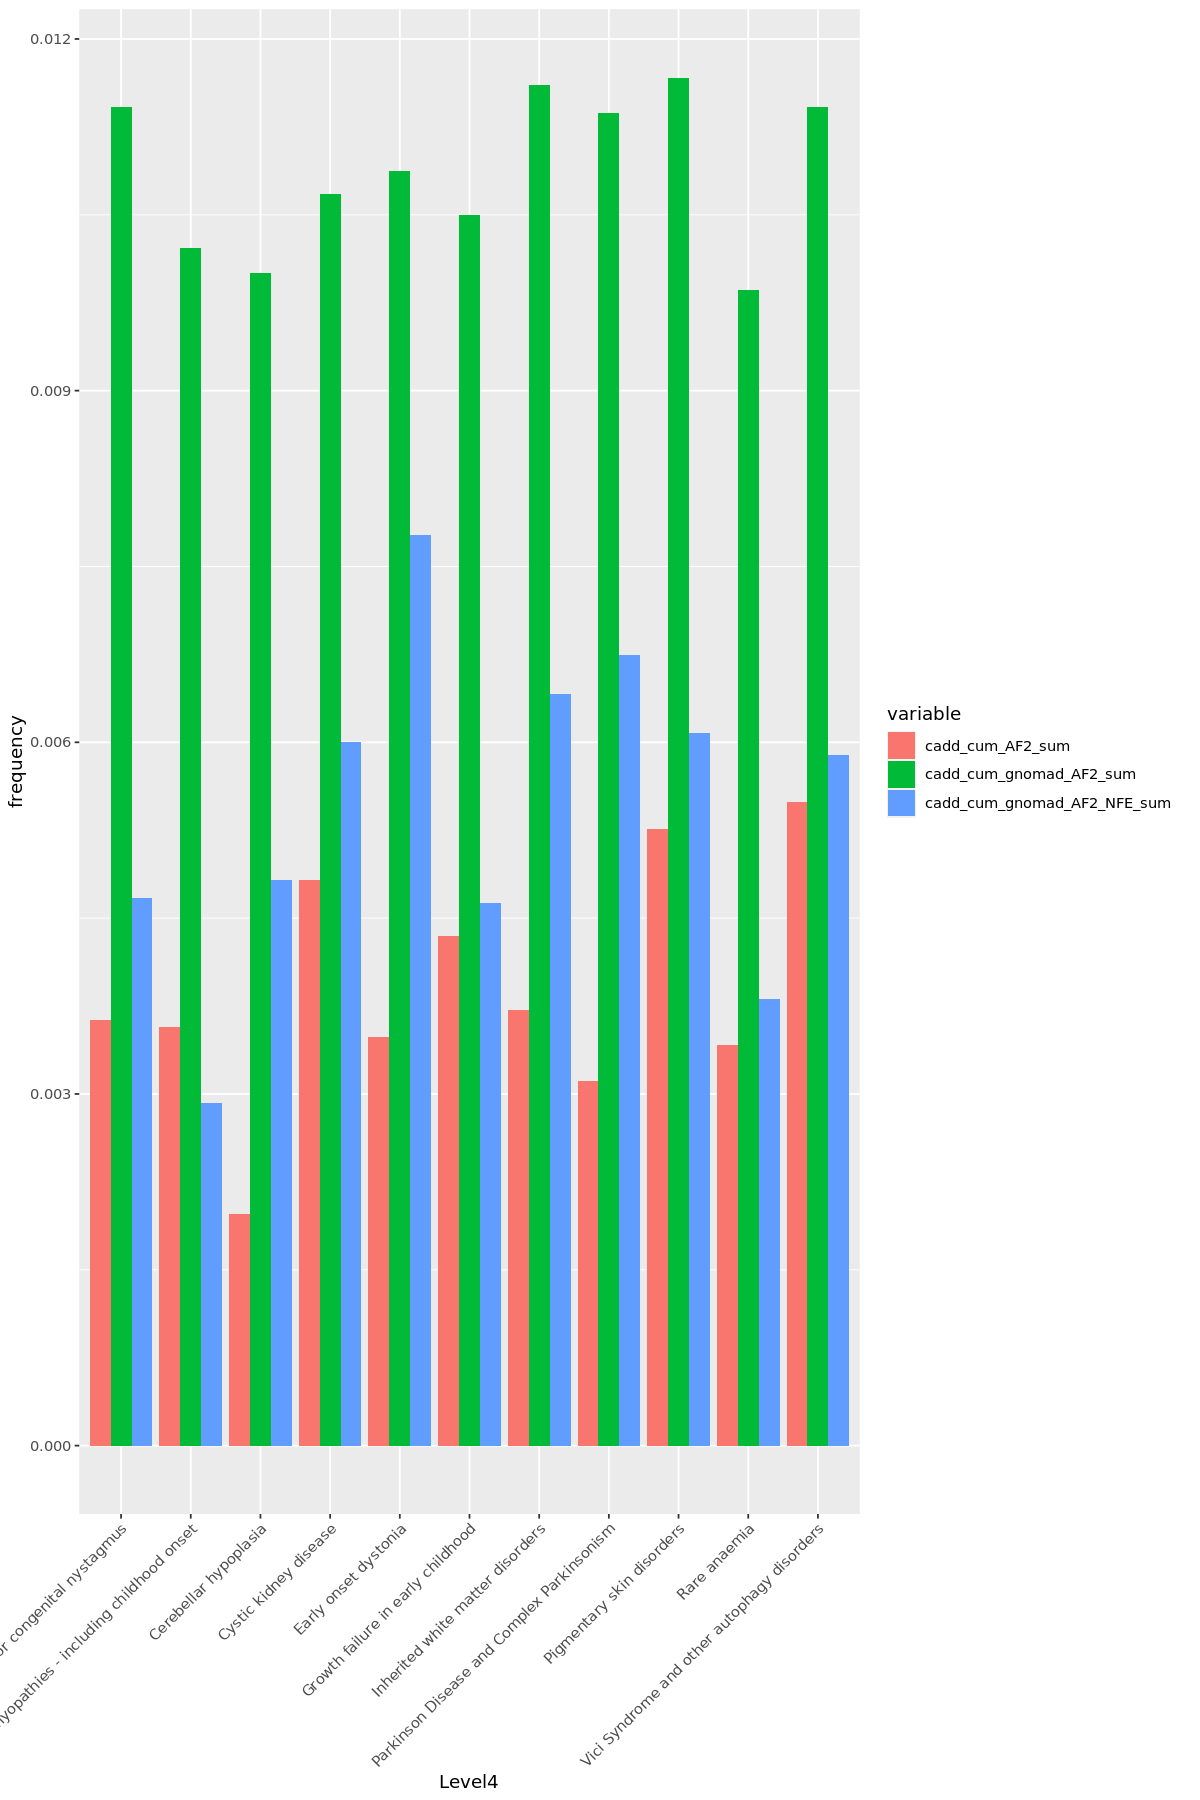

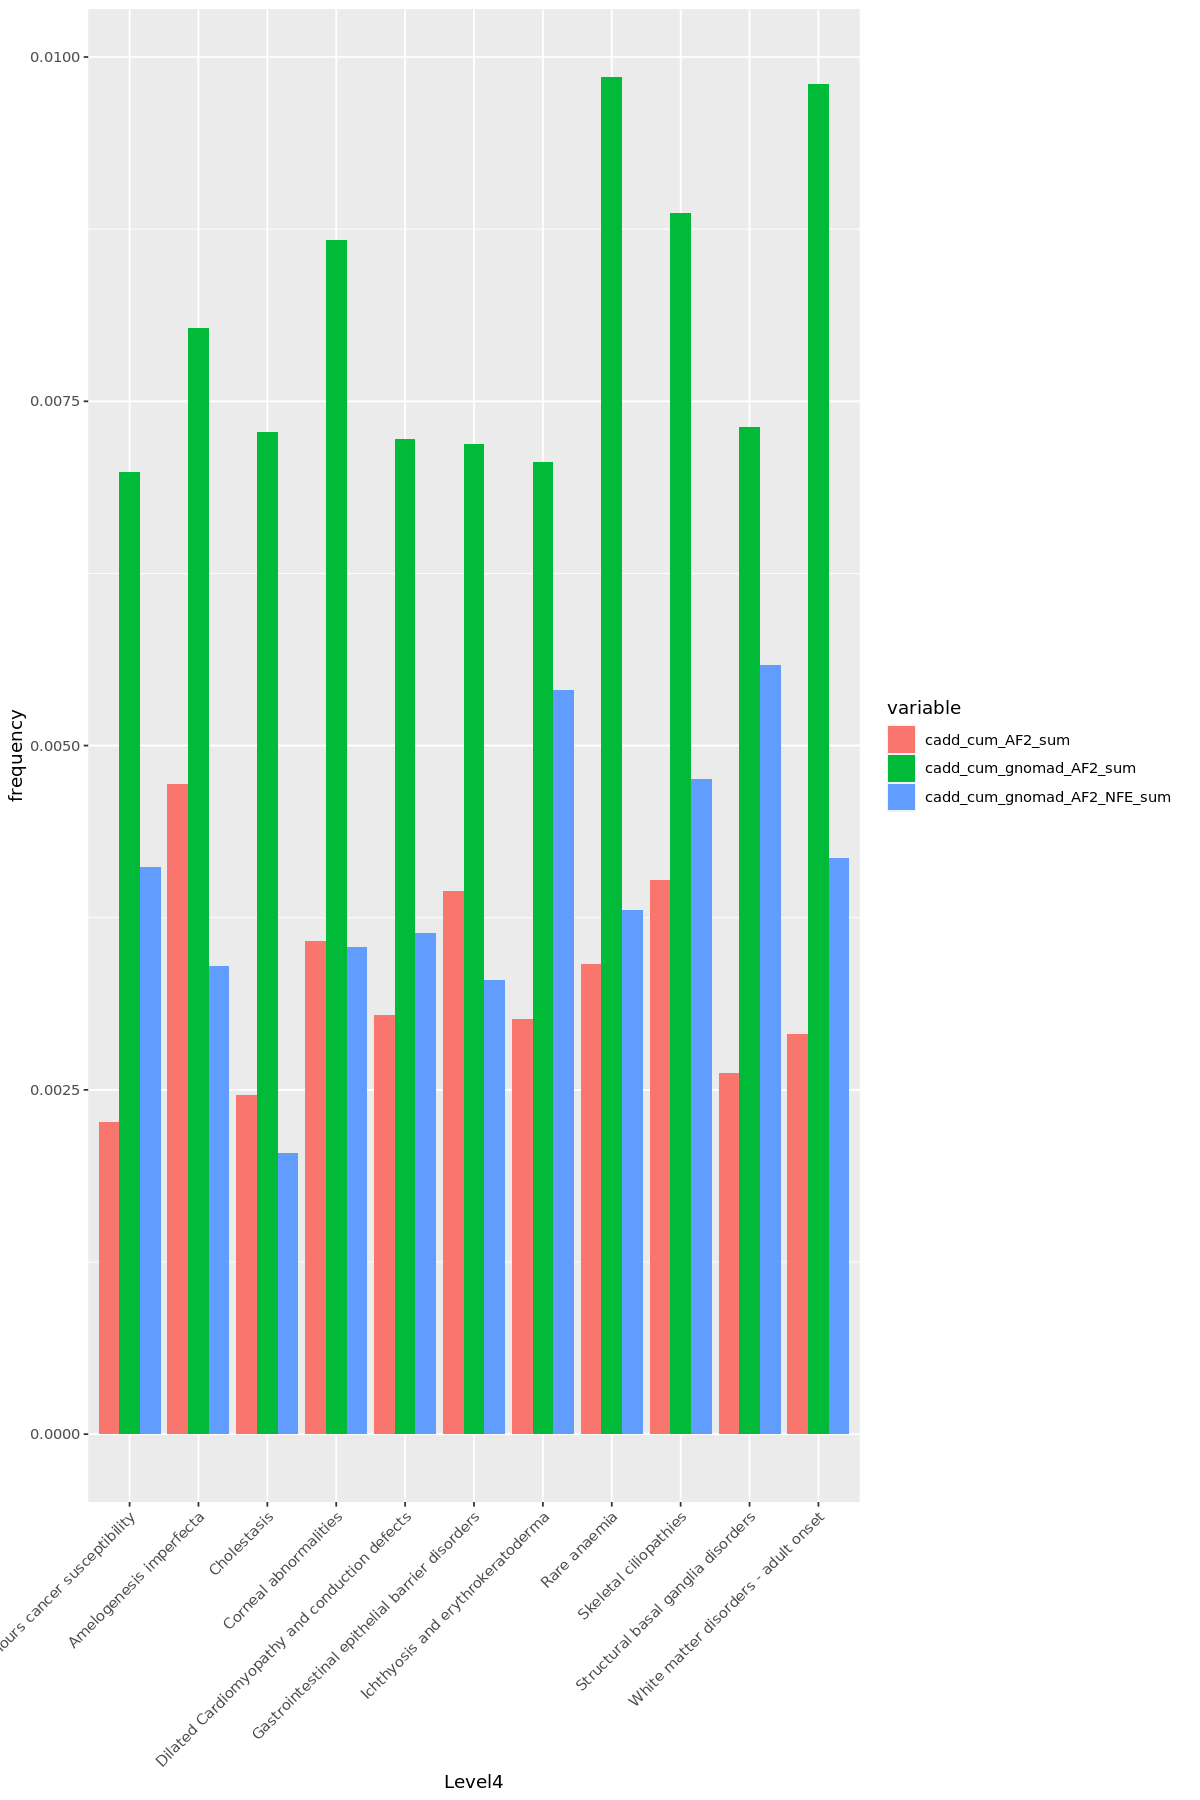

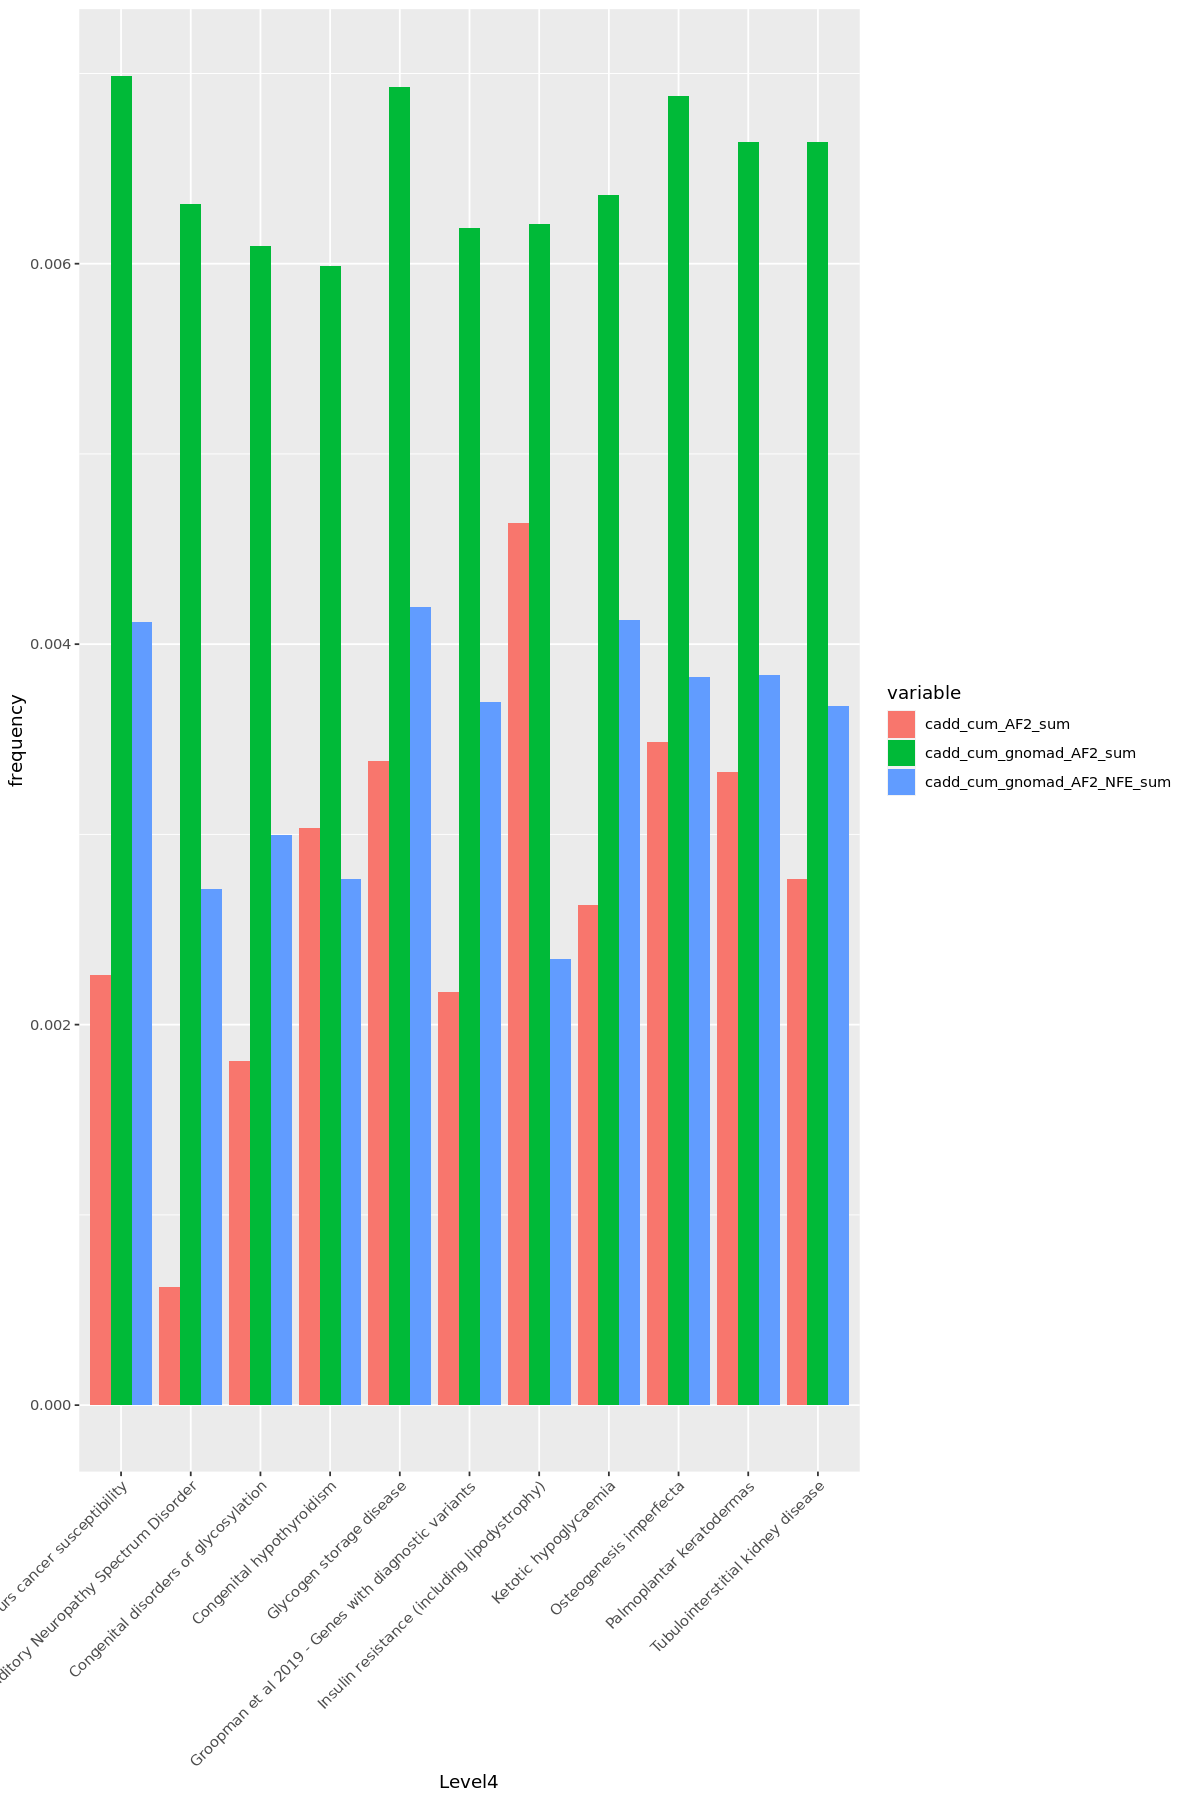

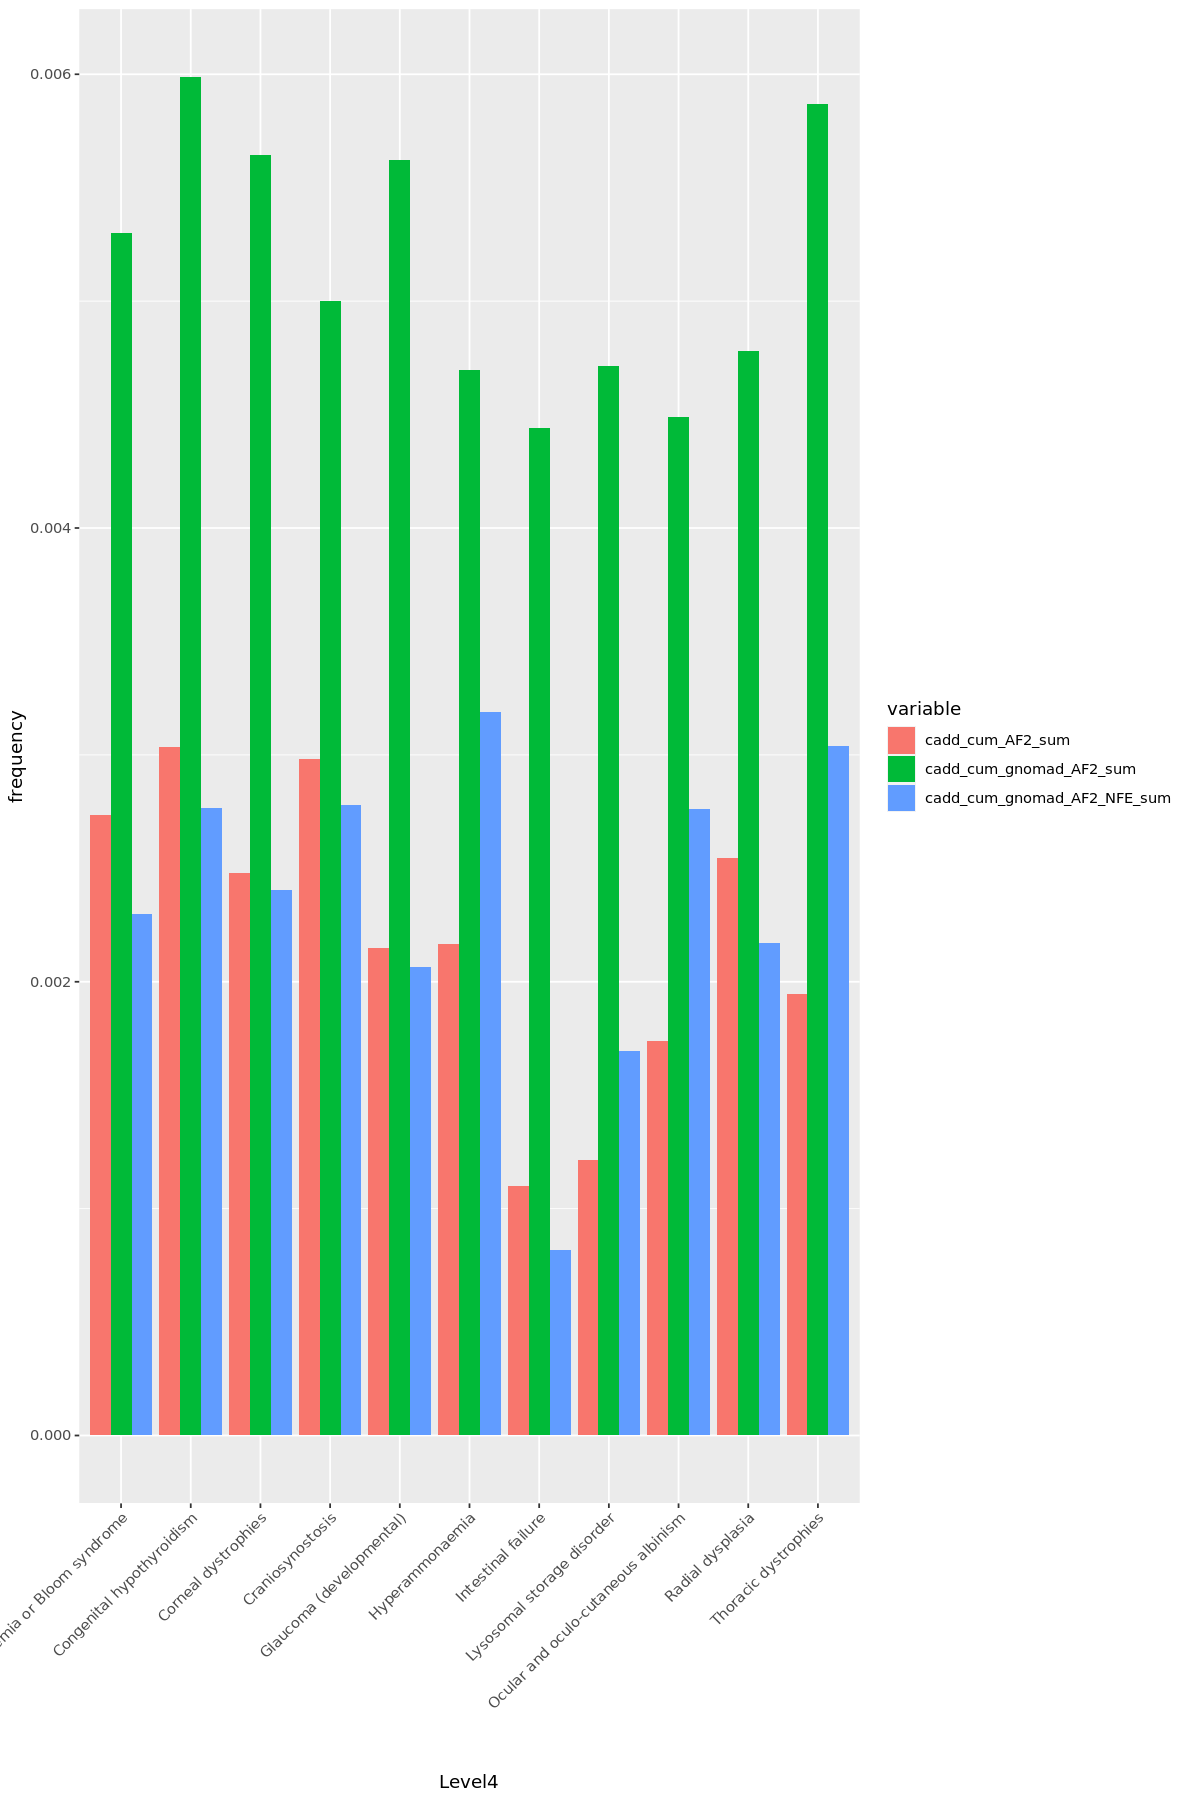

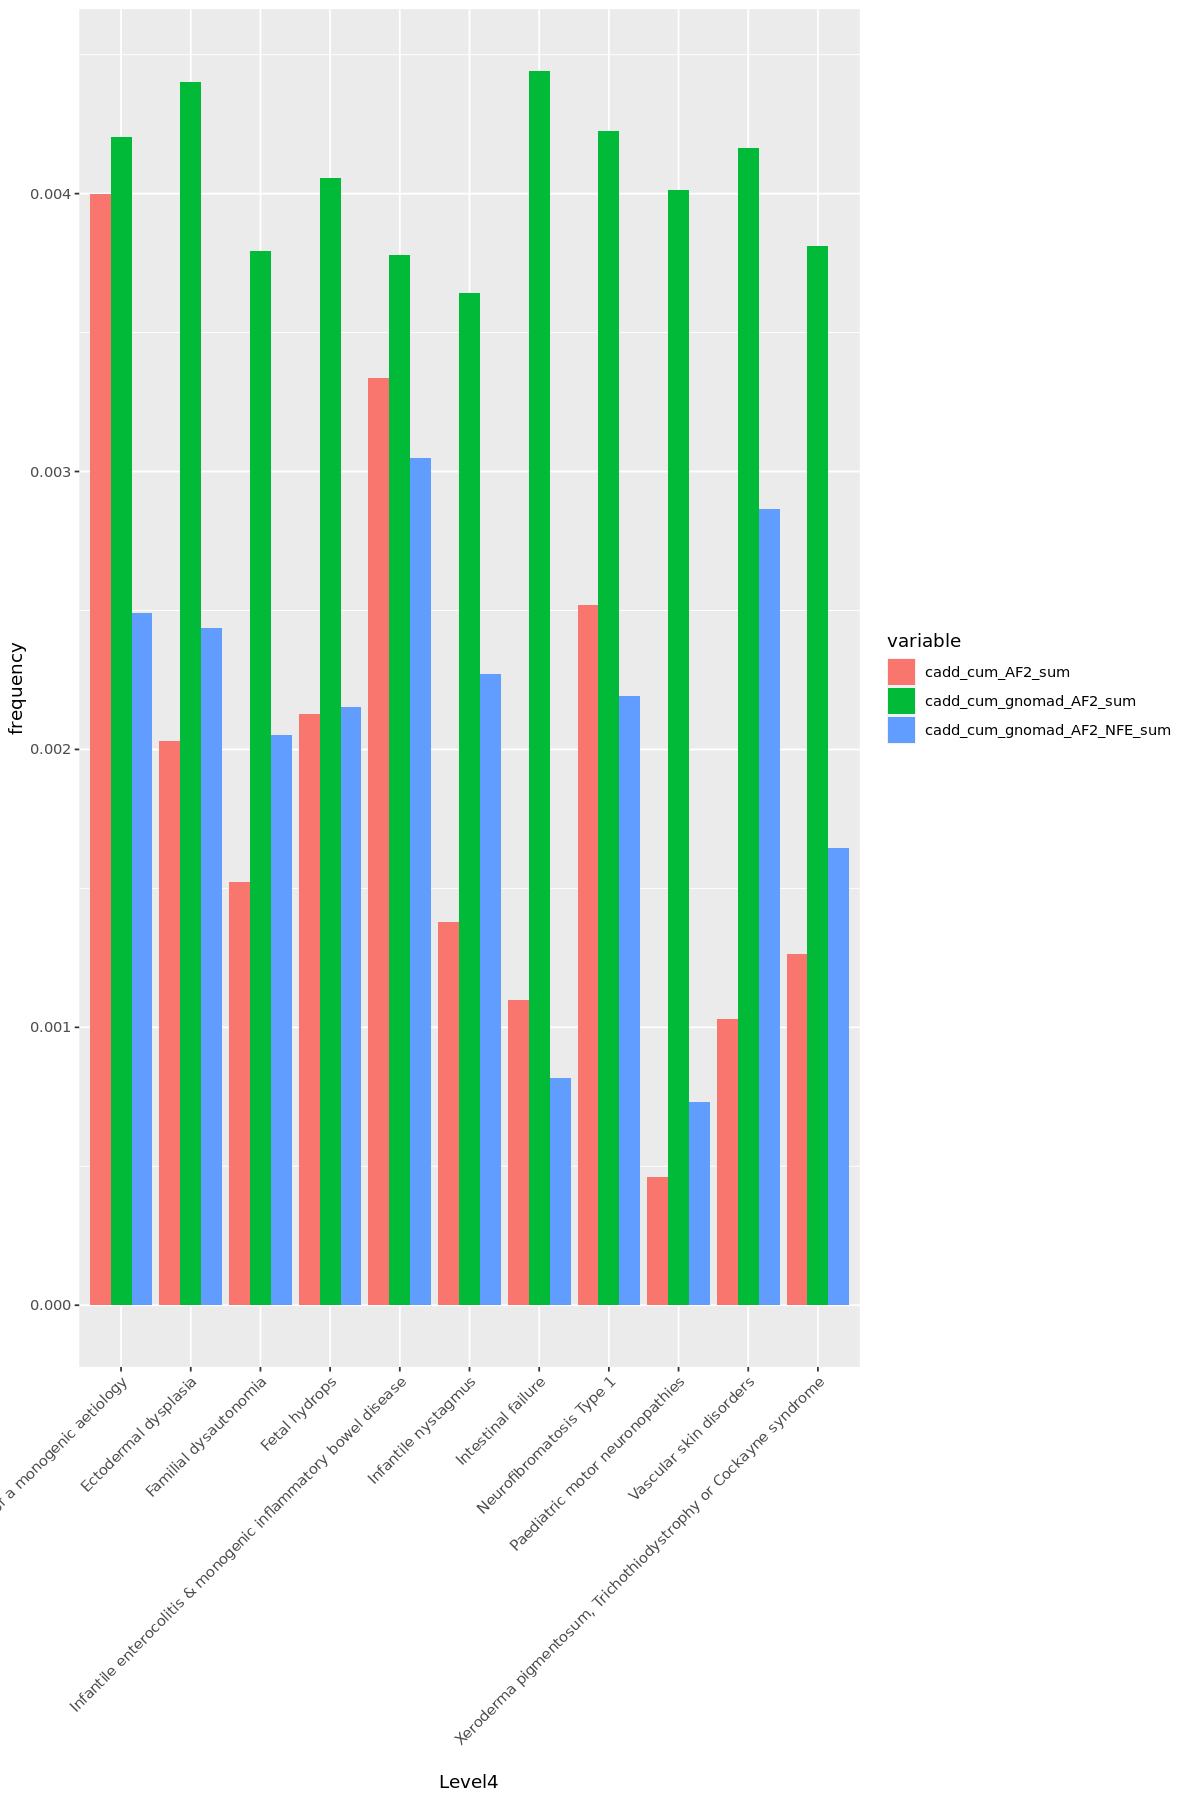

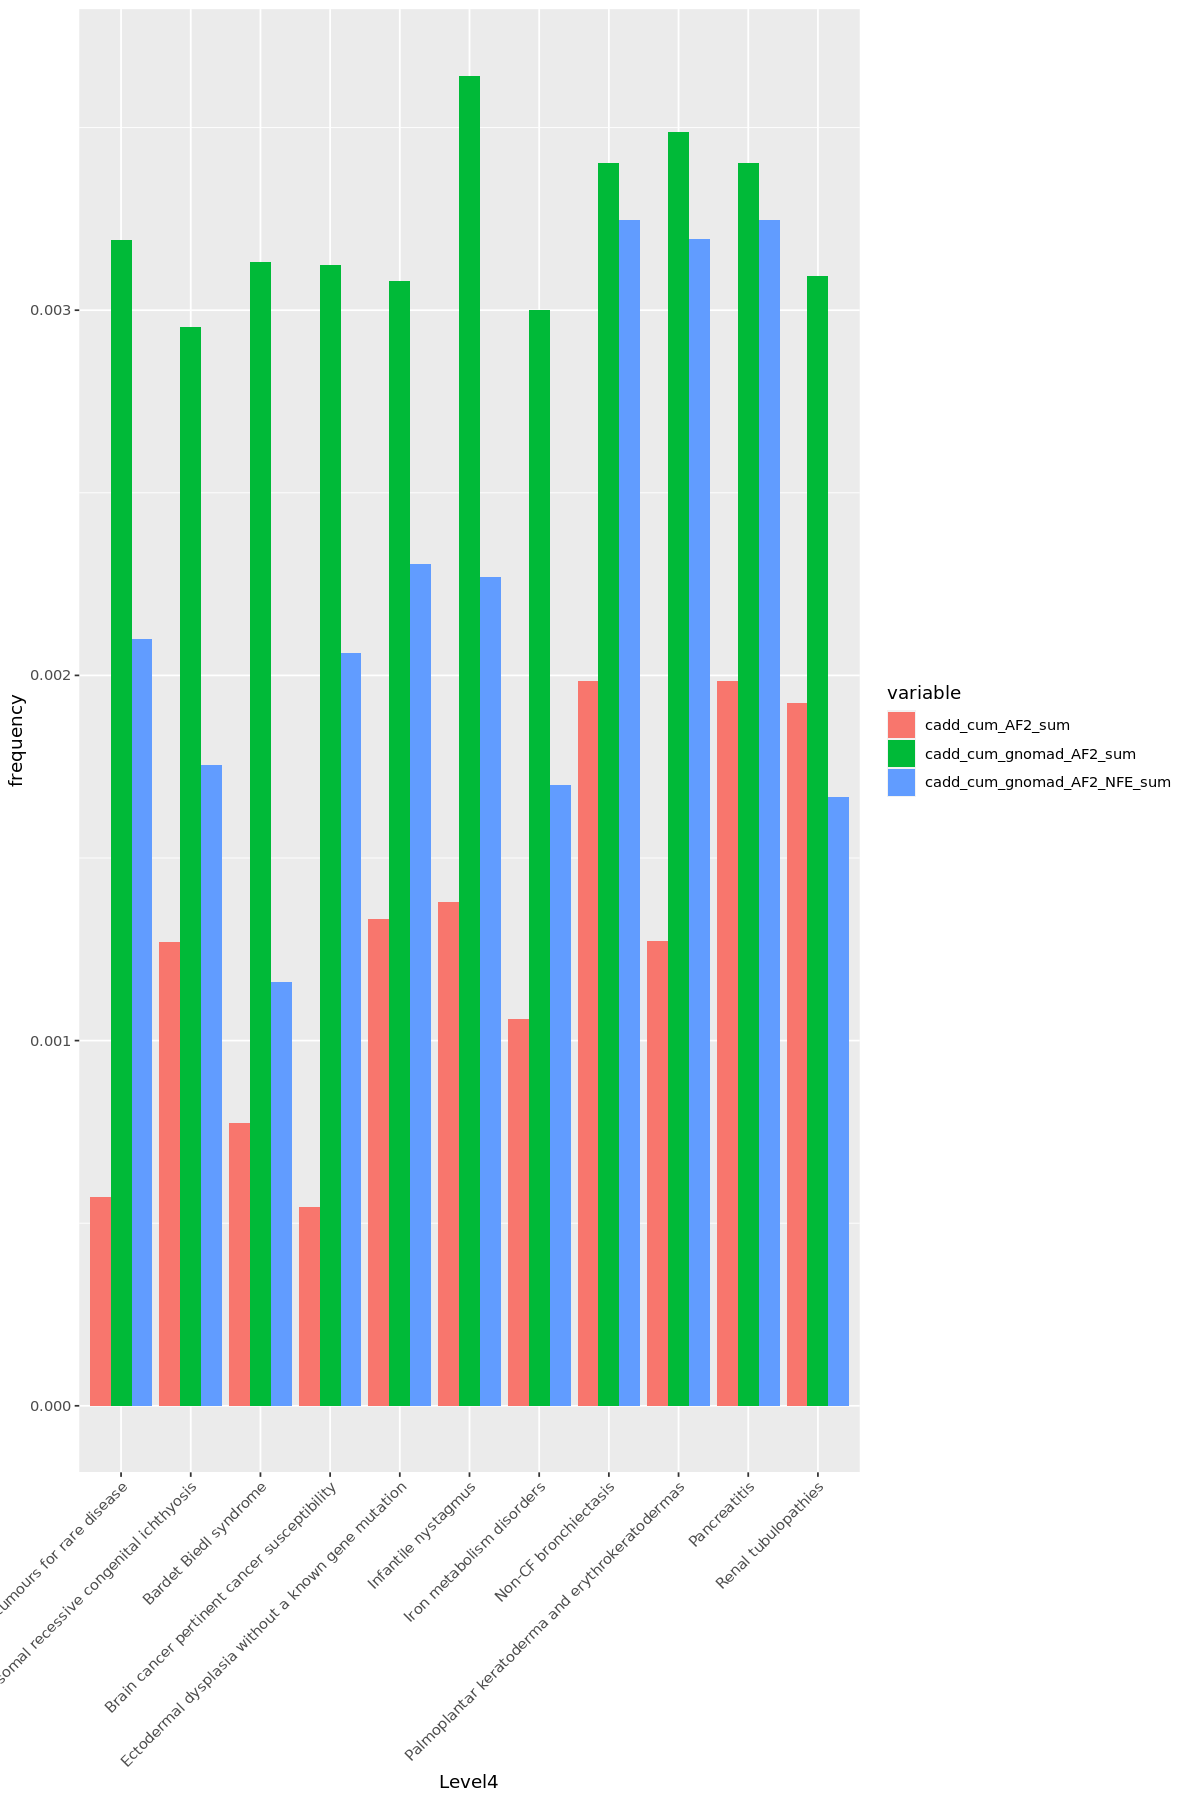

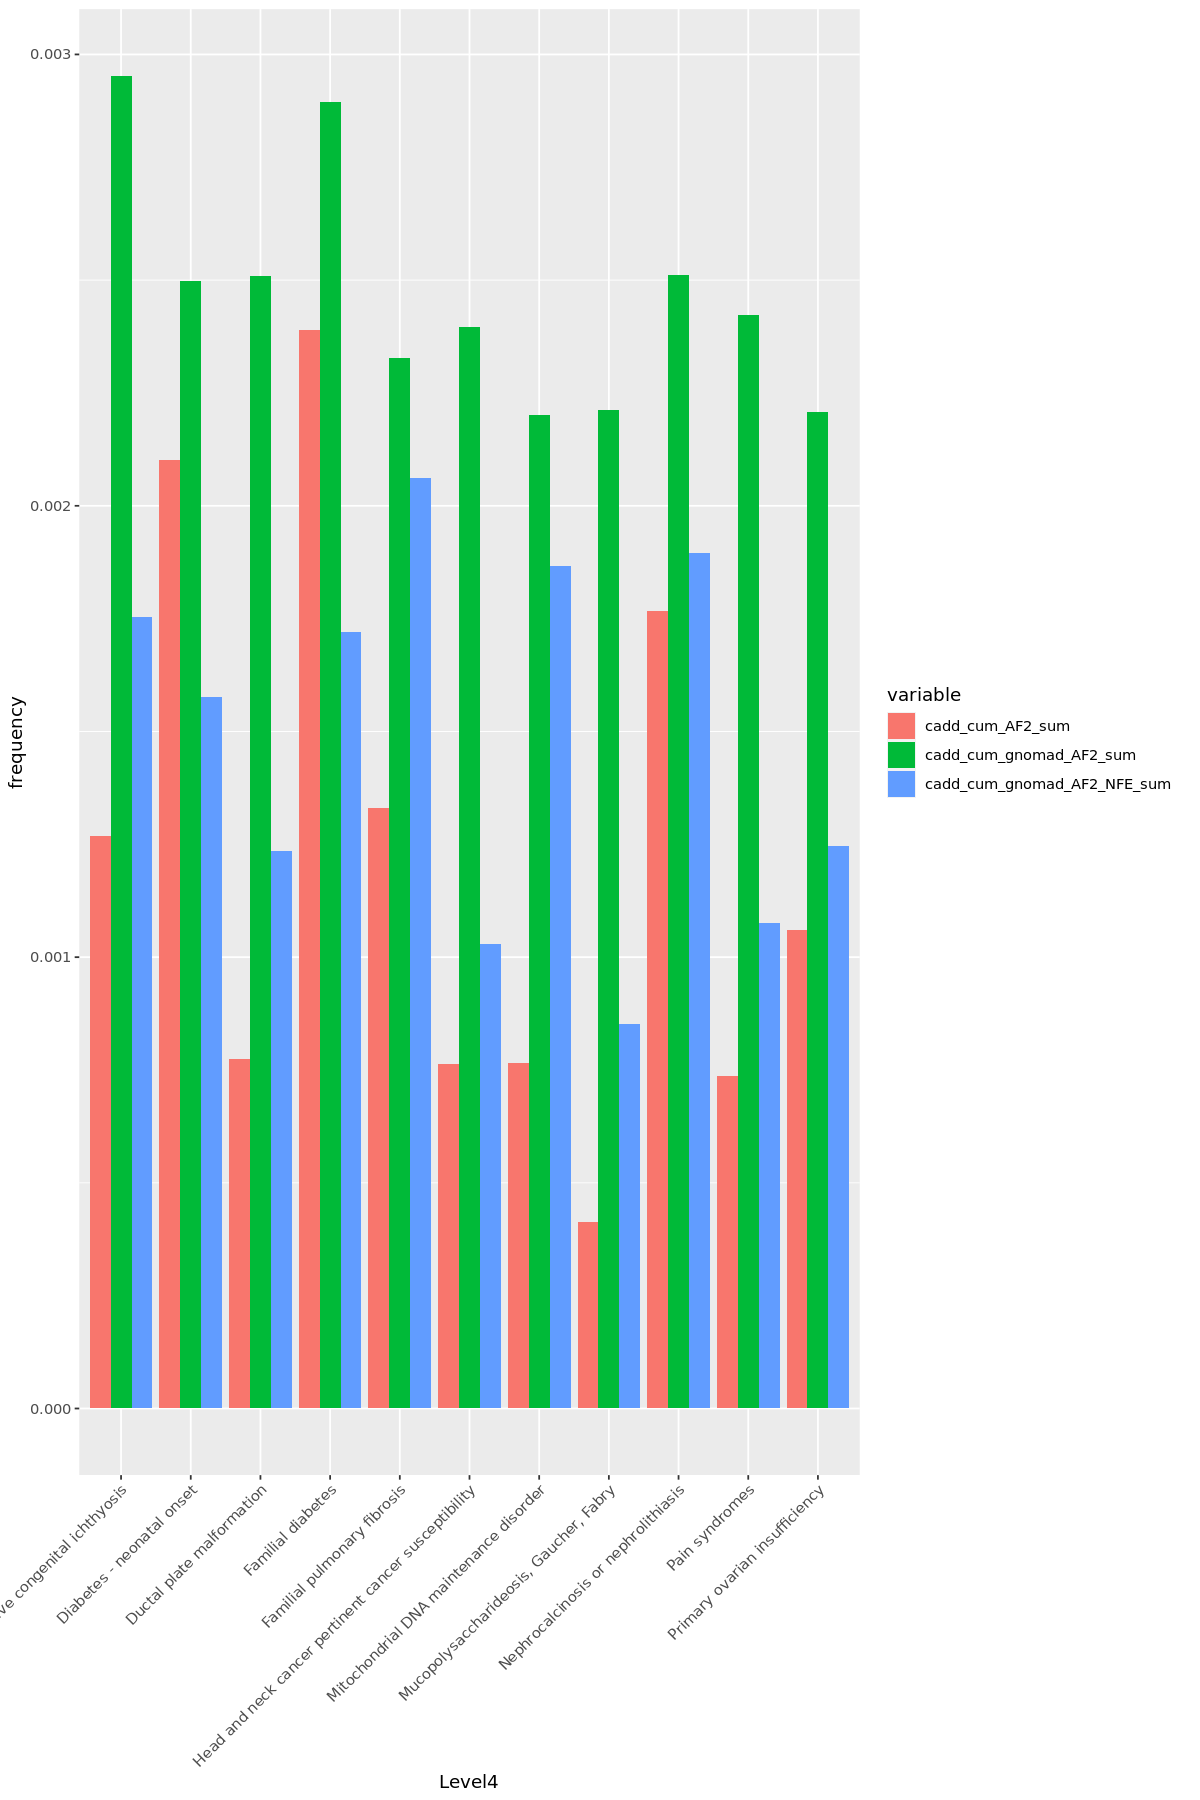

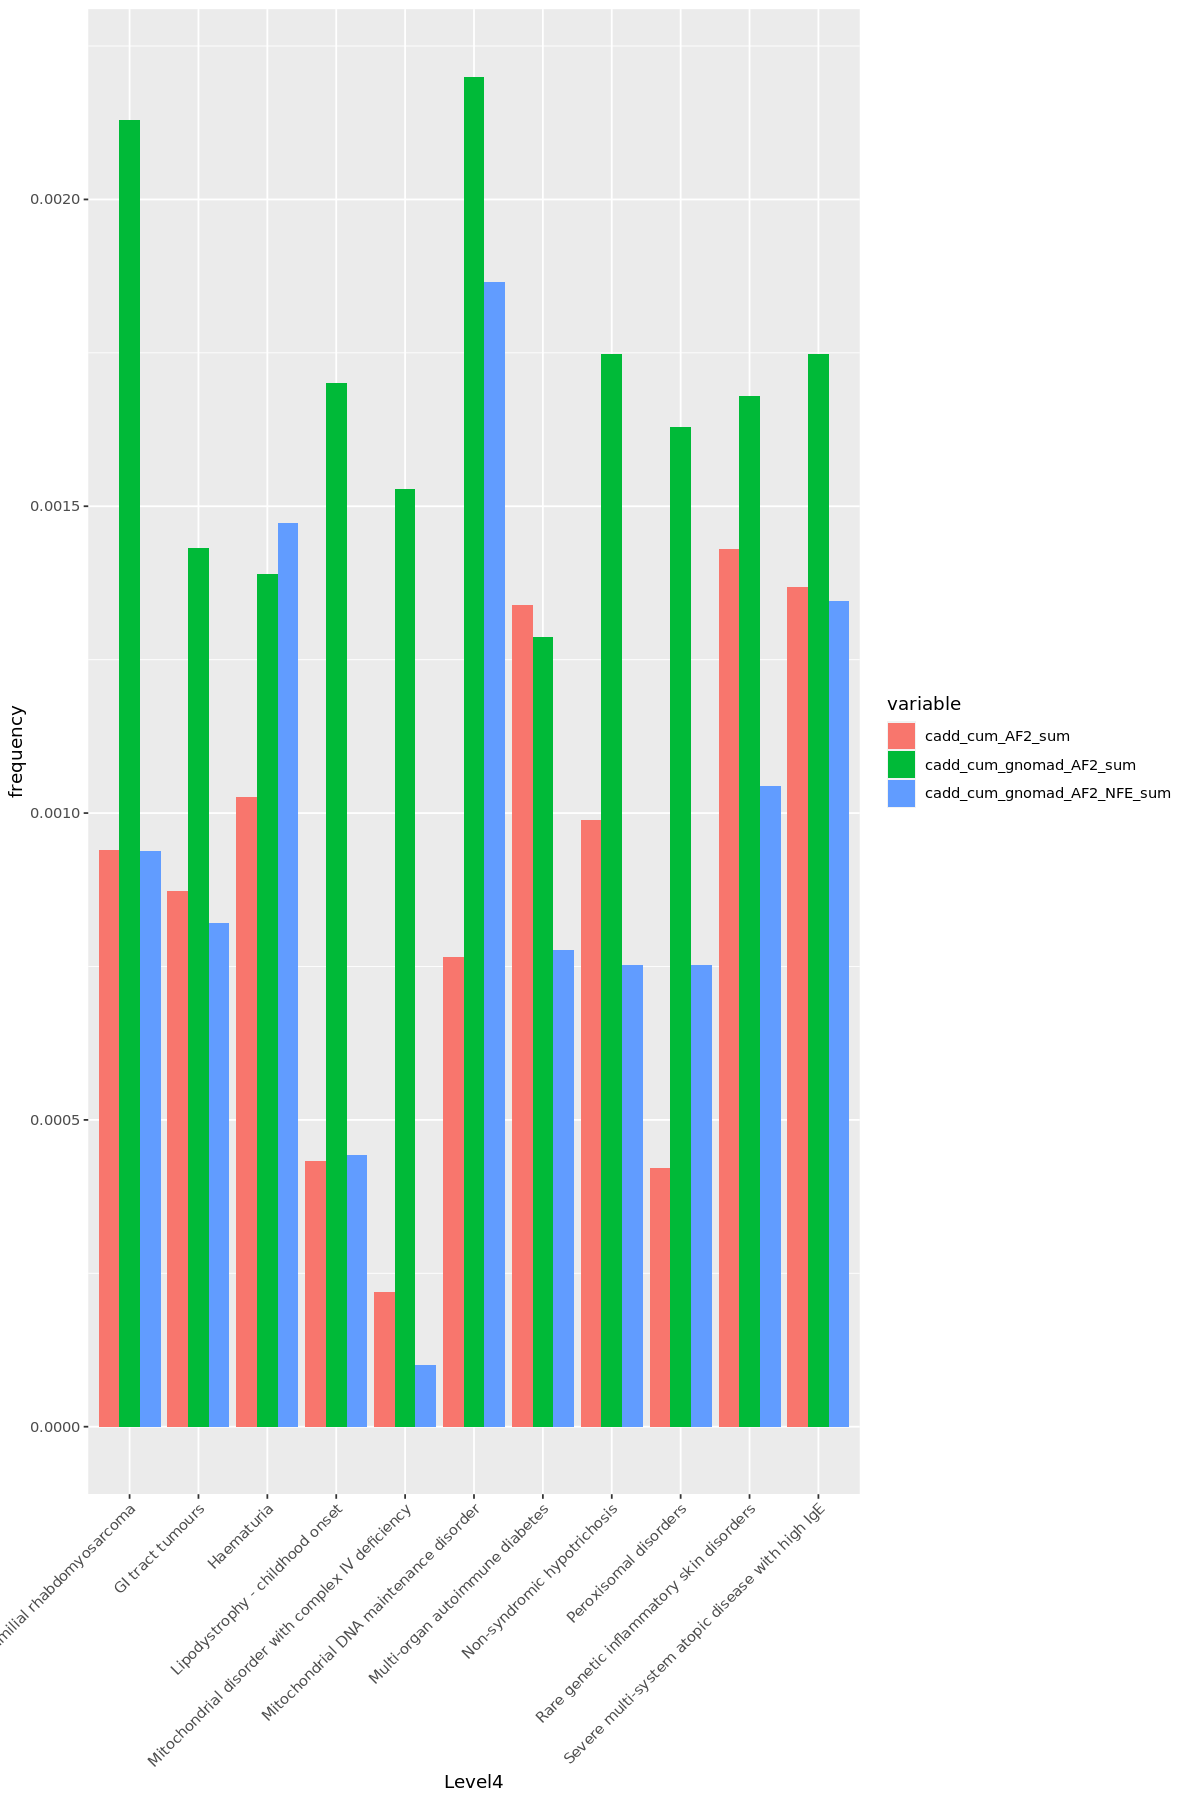

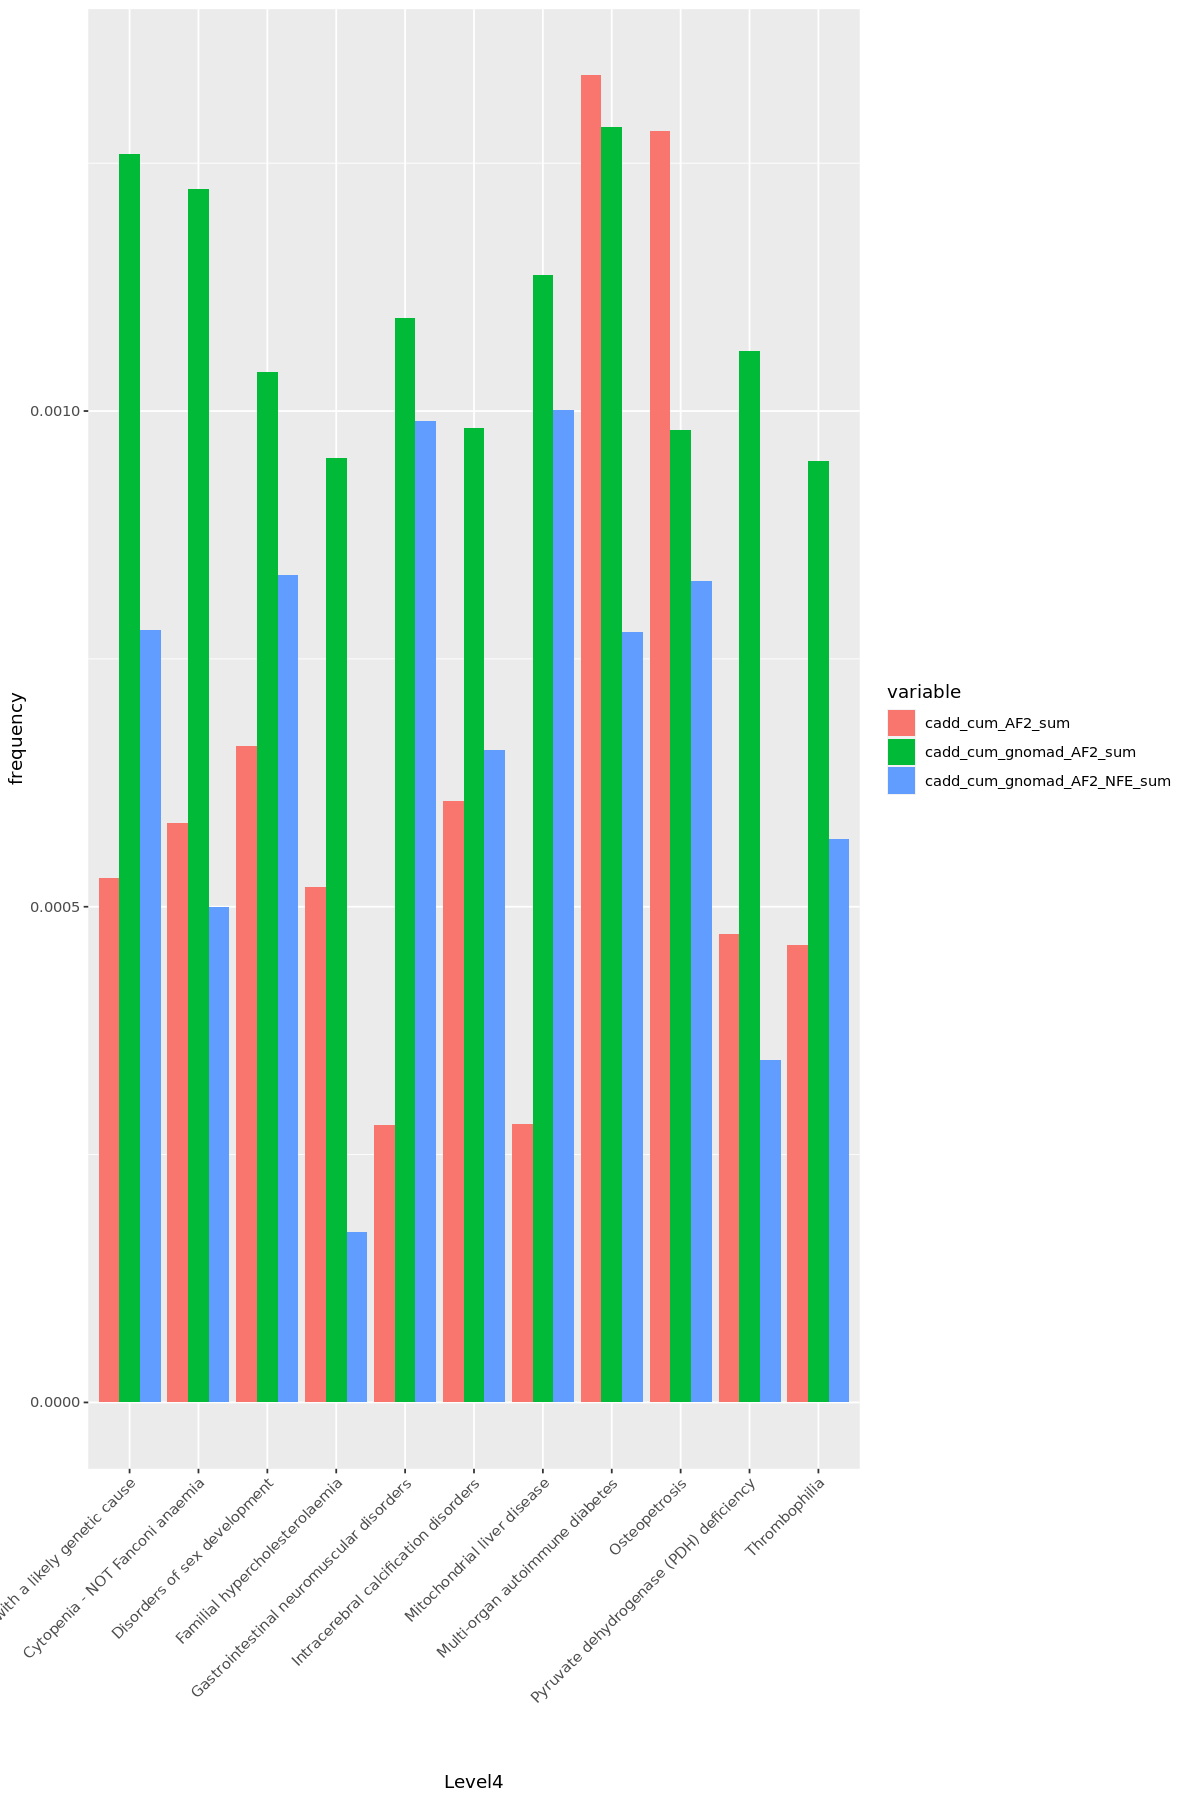

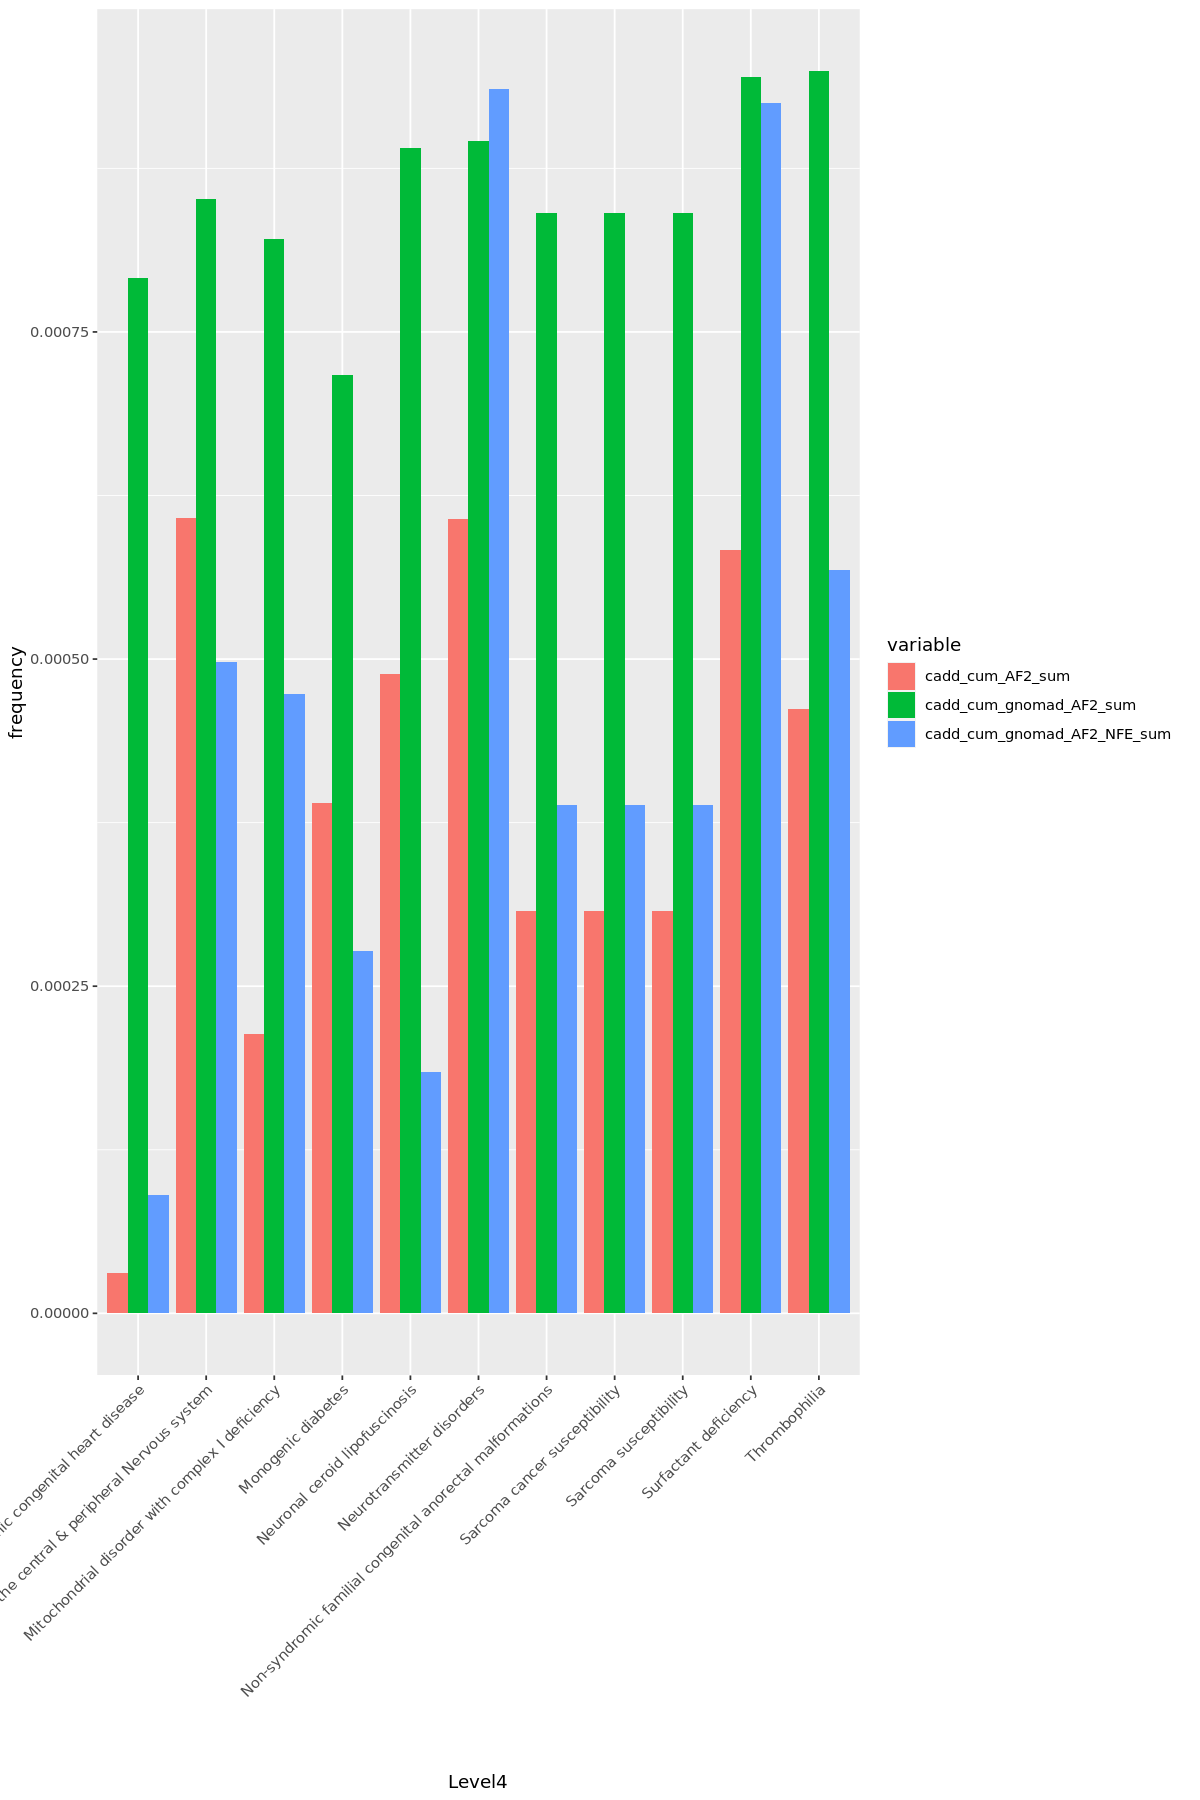

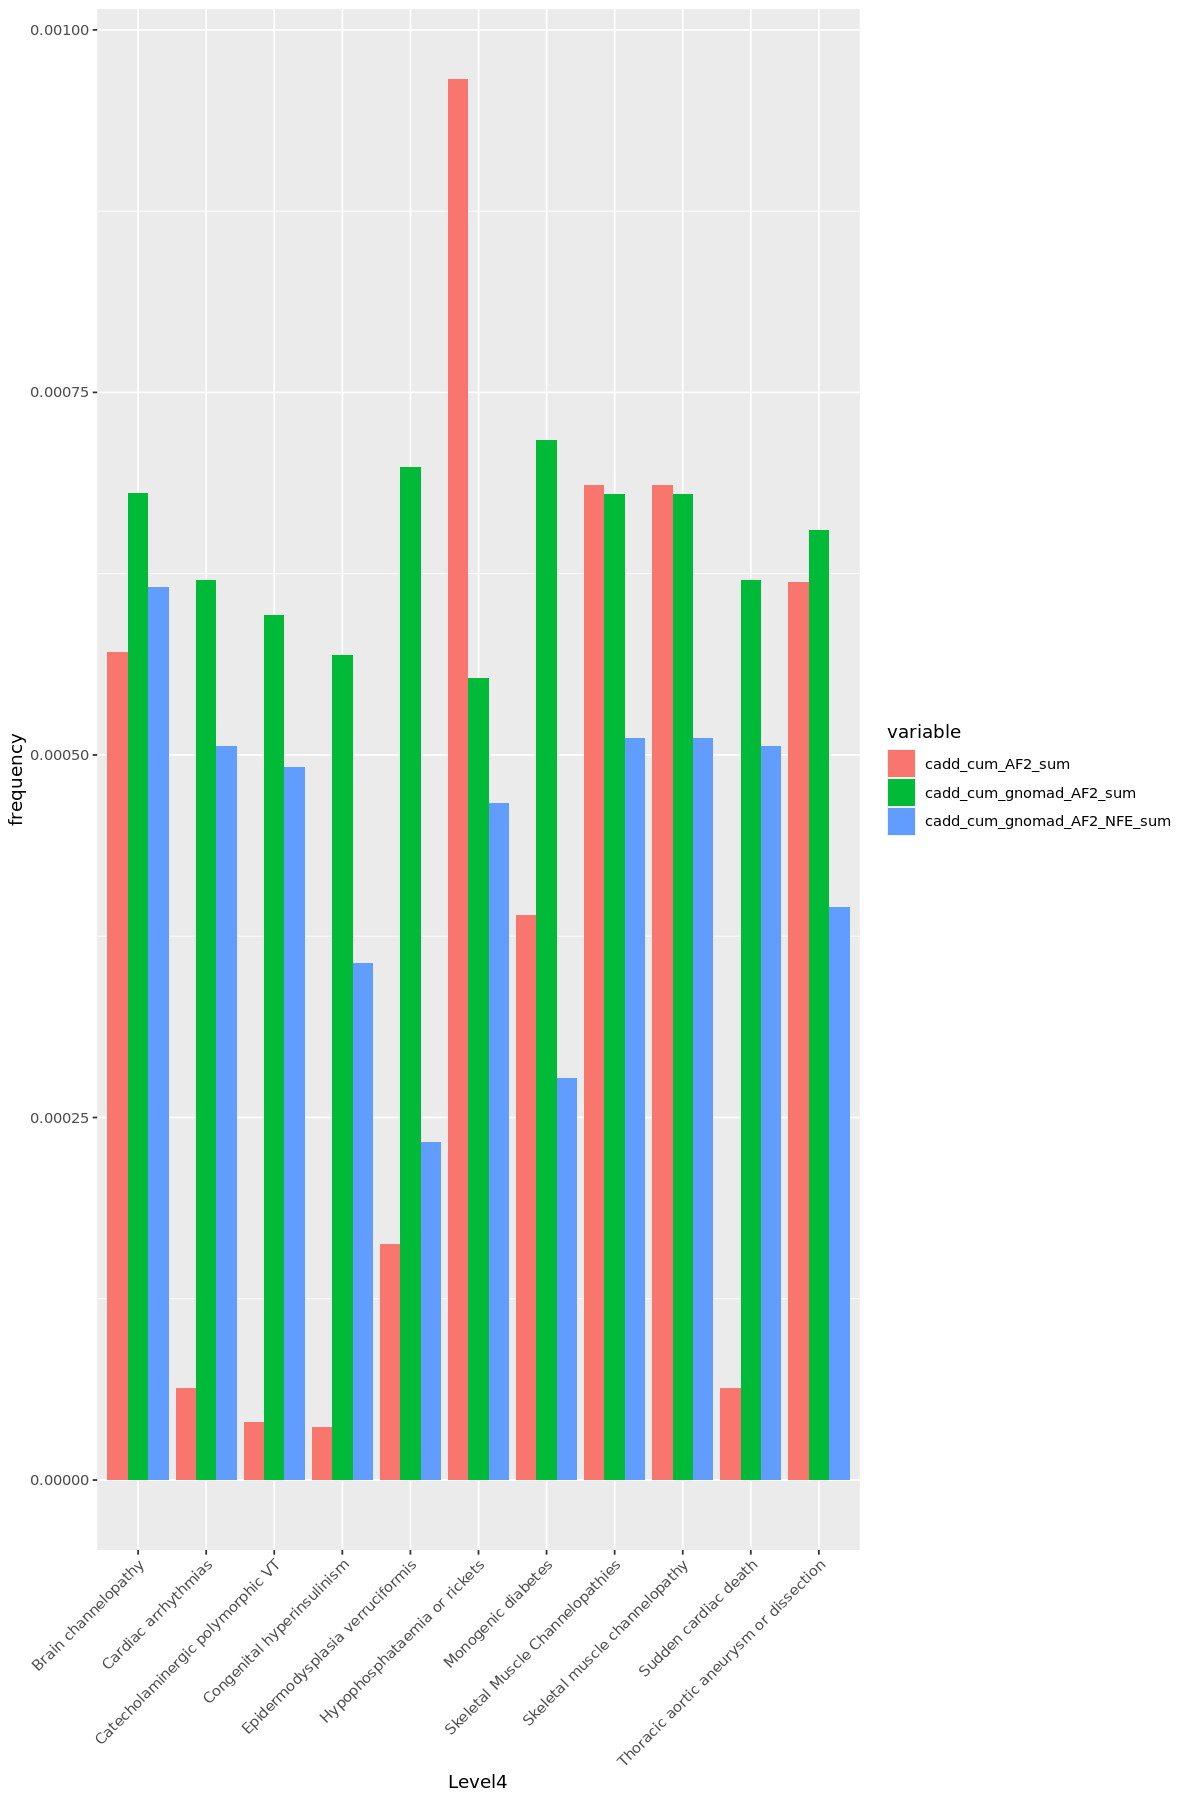

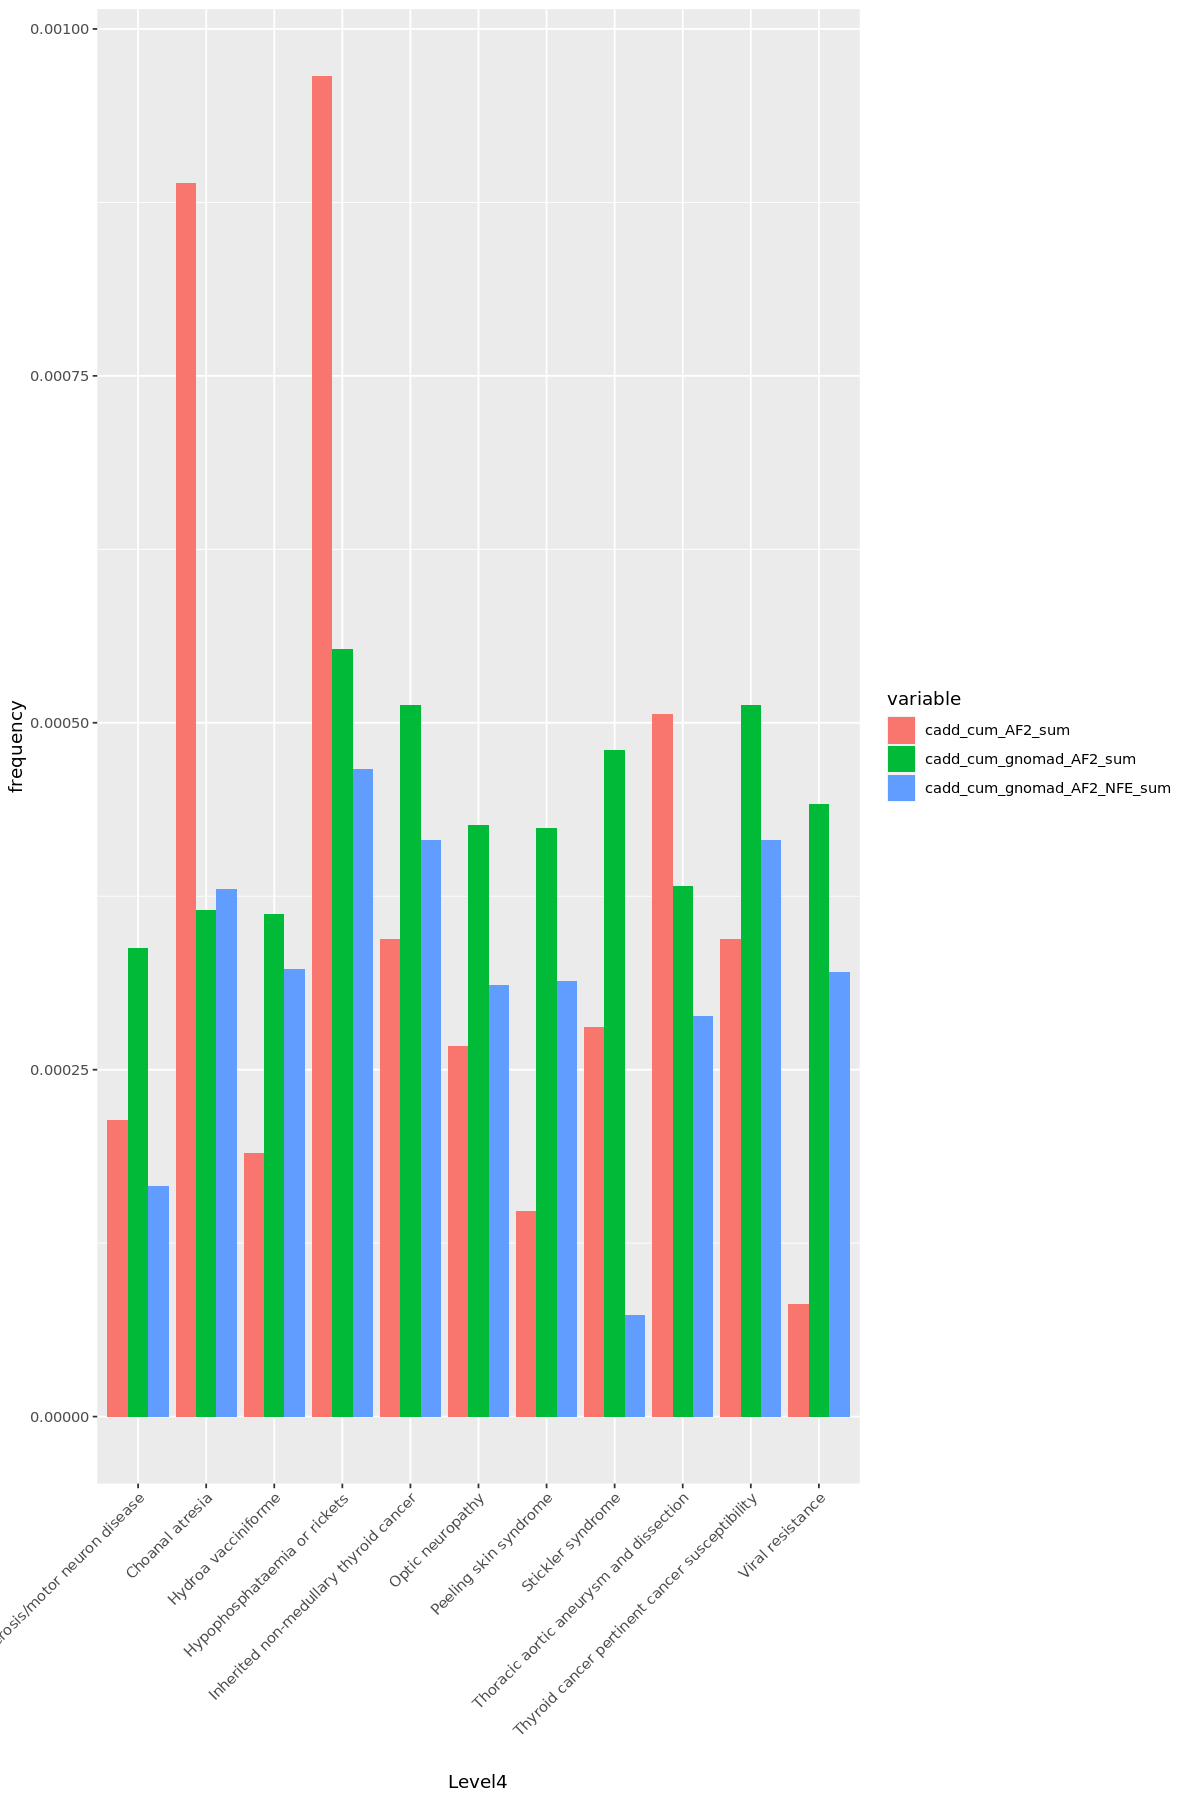

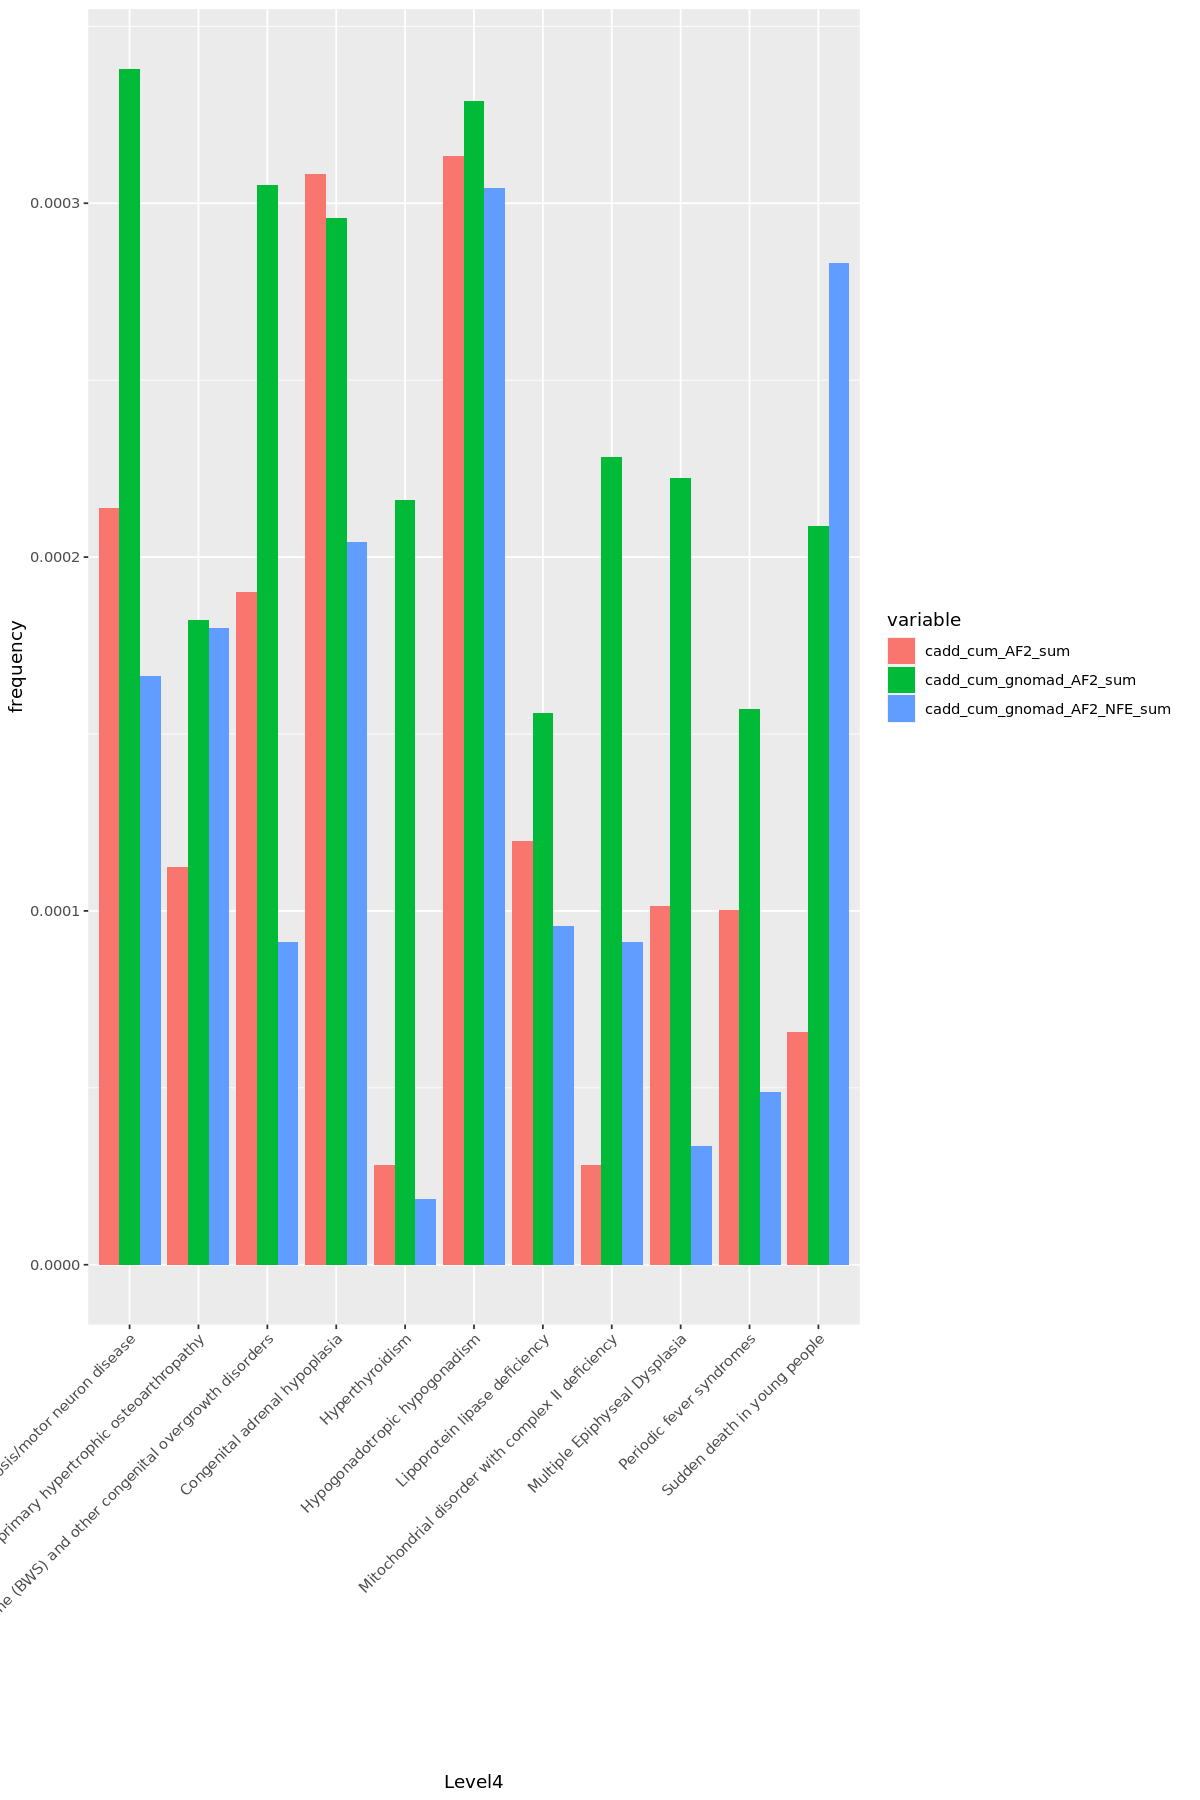

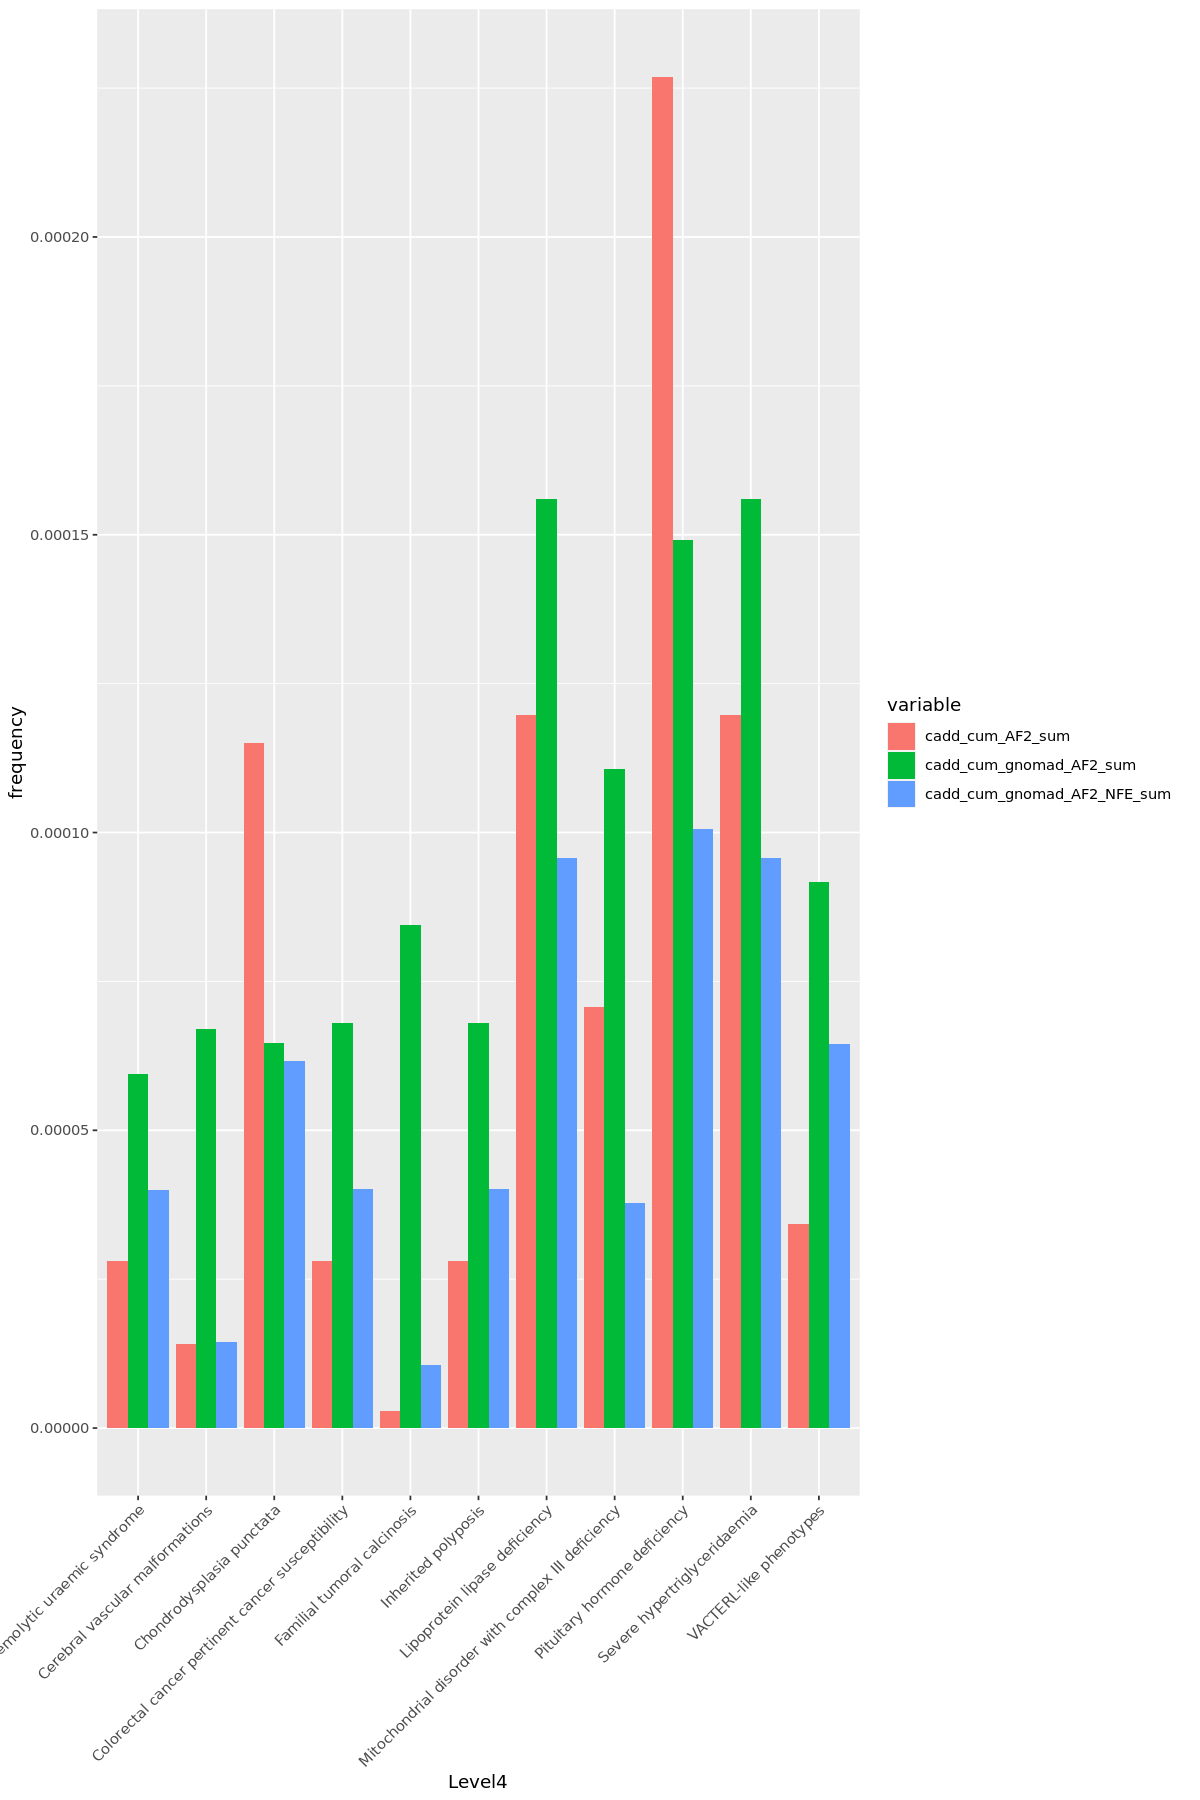

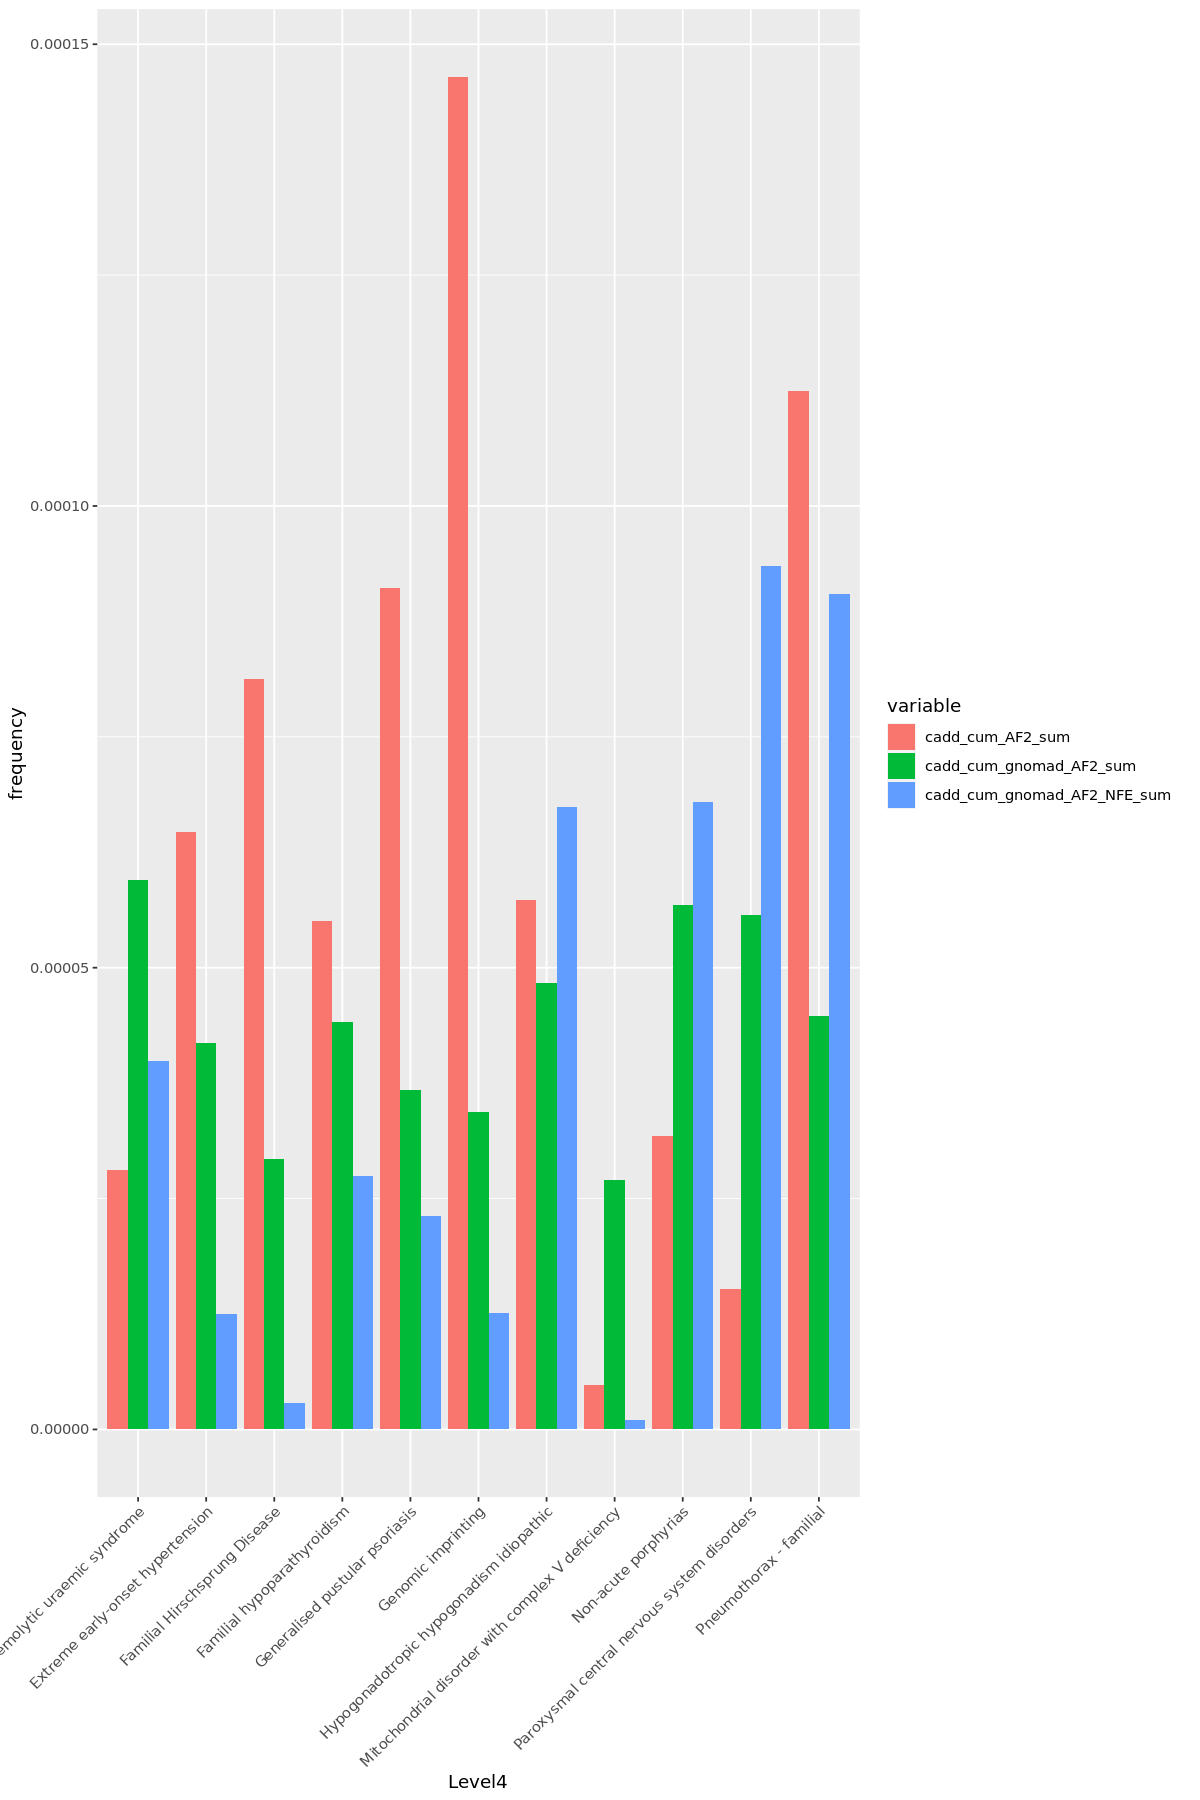

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]

[[19]]

[[20]]

[[21]]

[[22]]

[[23]]

[[24]]

[[25]]


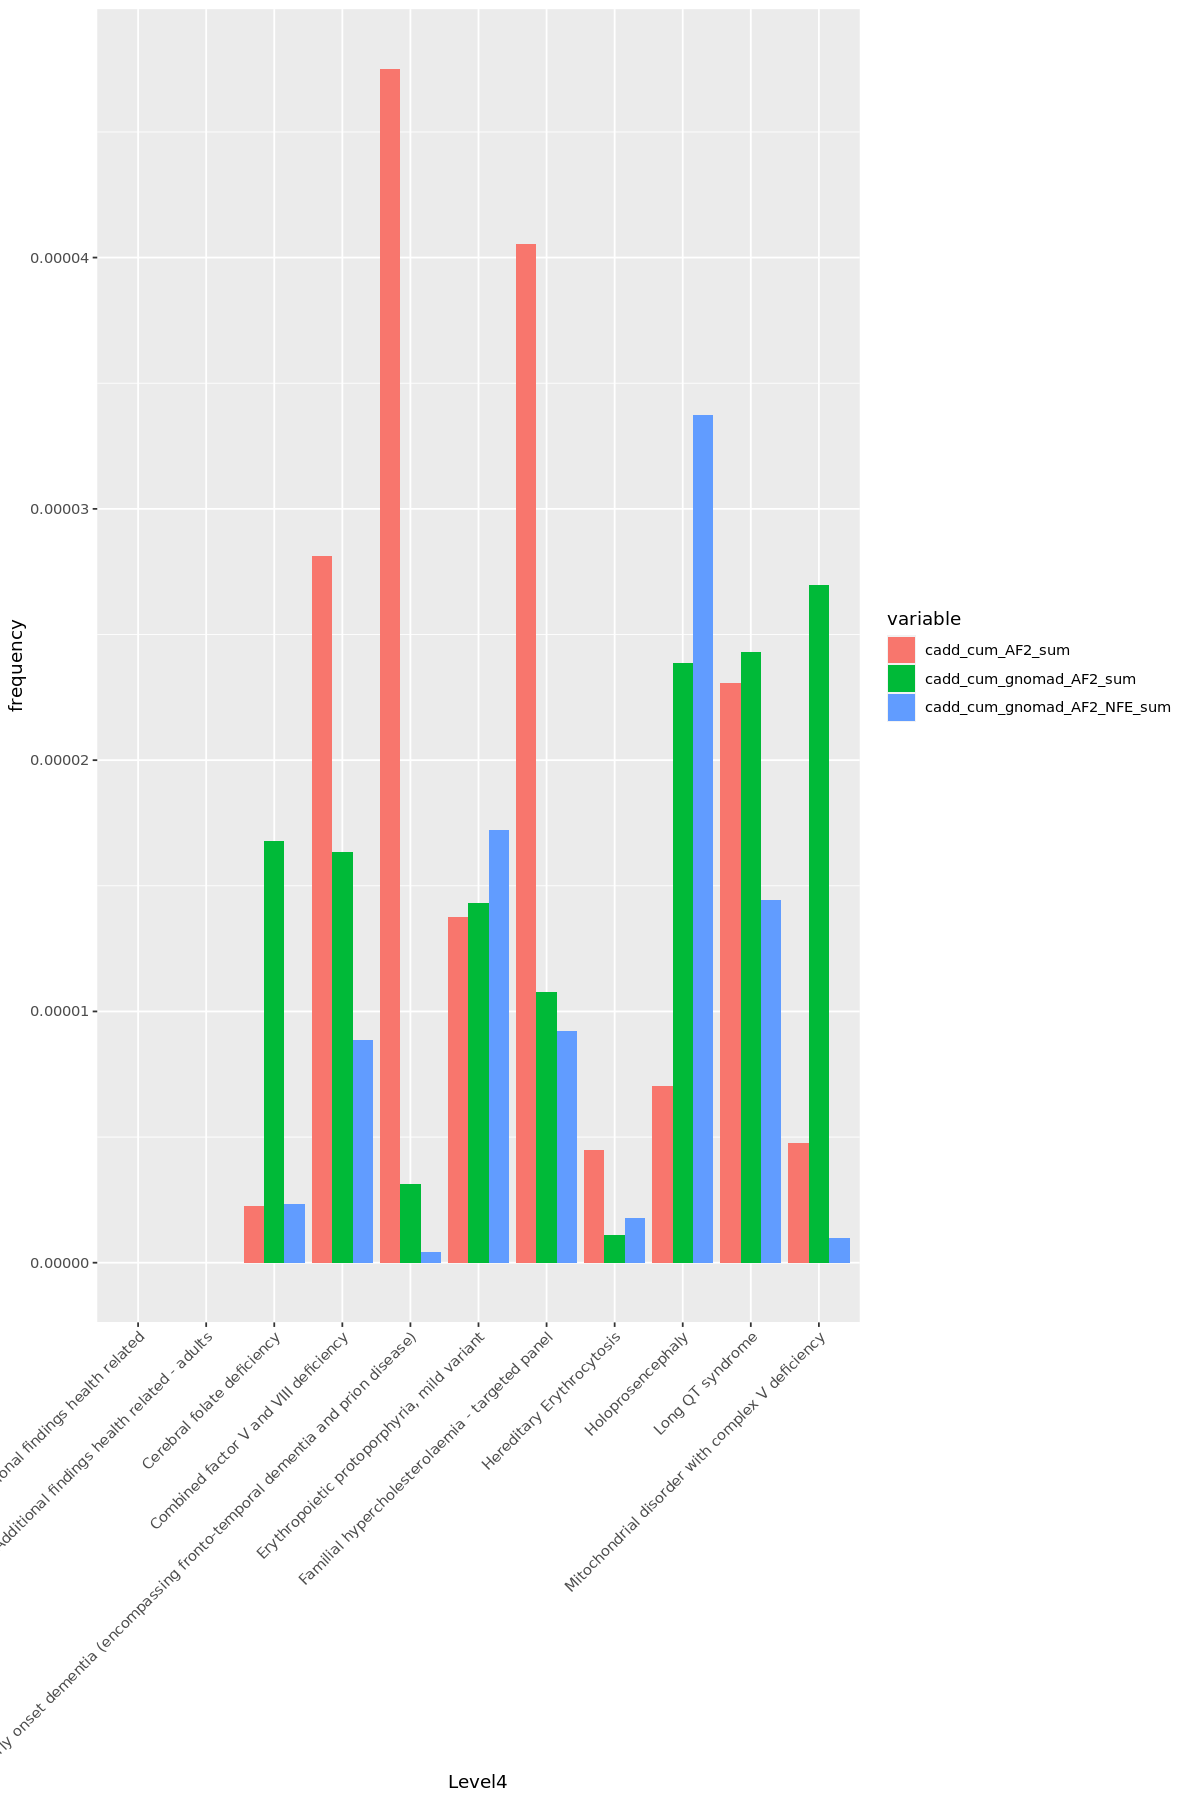

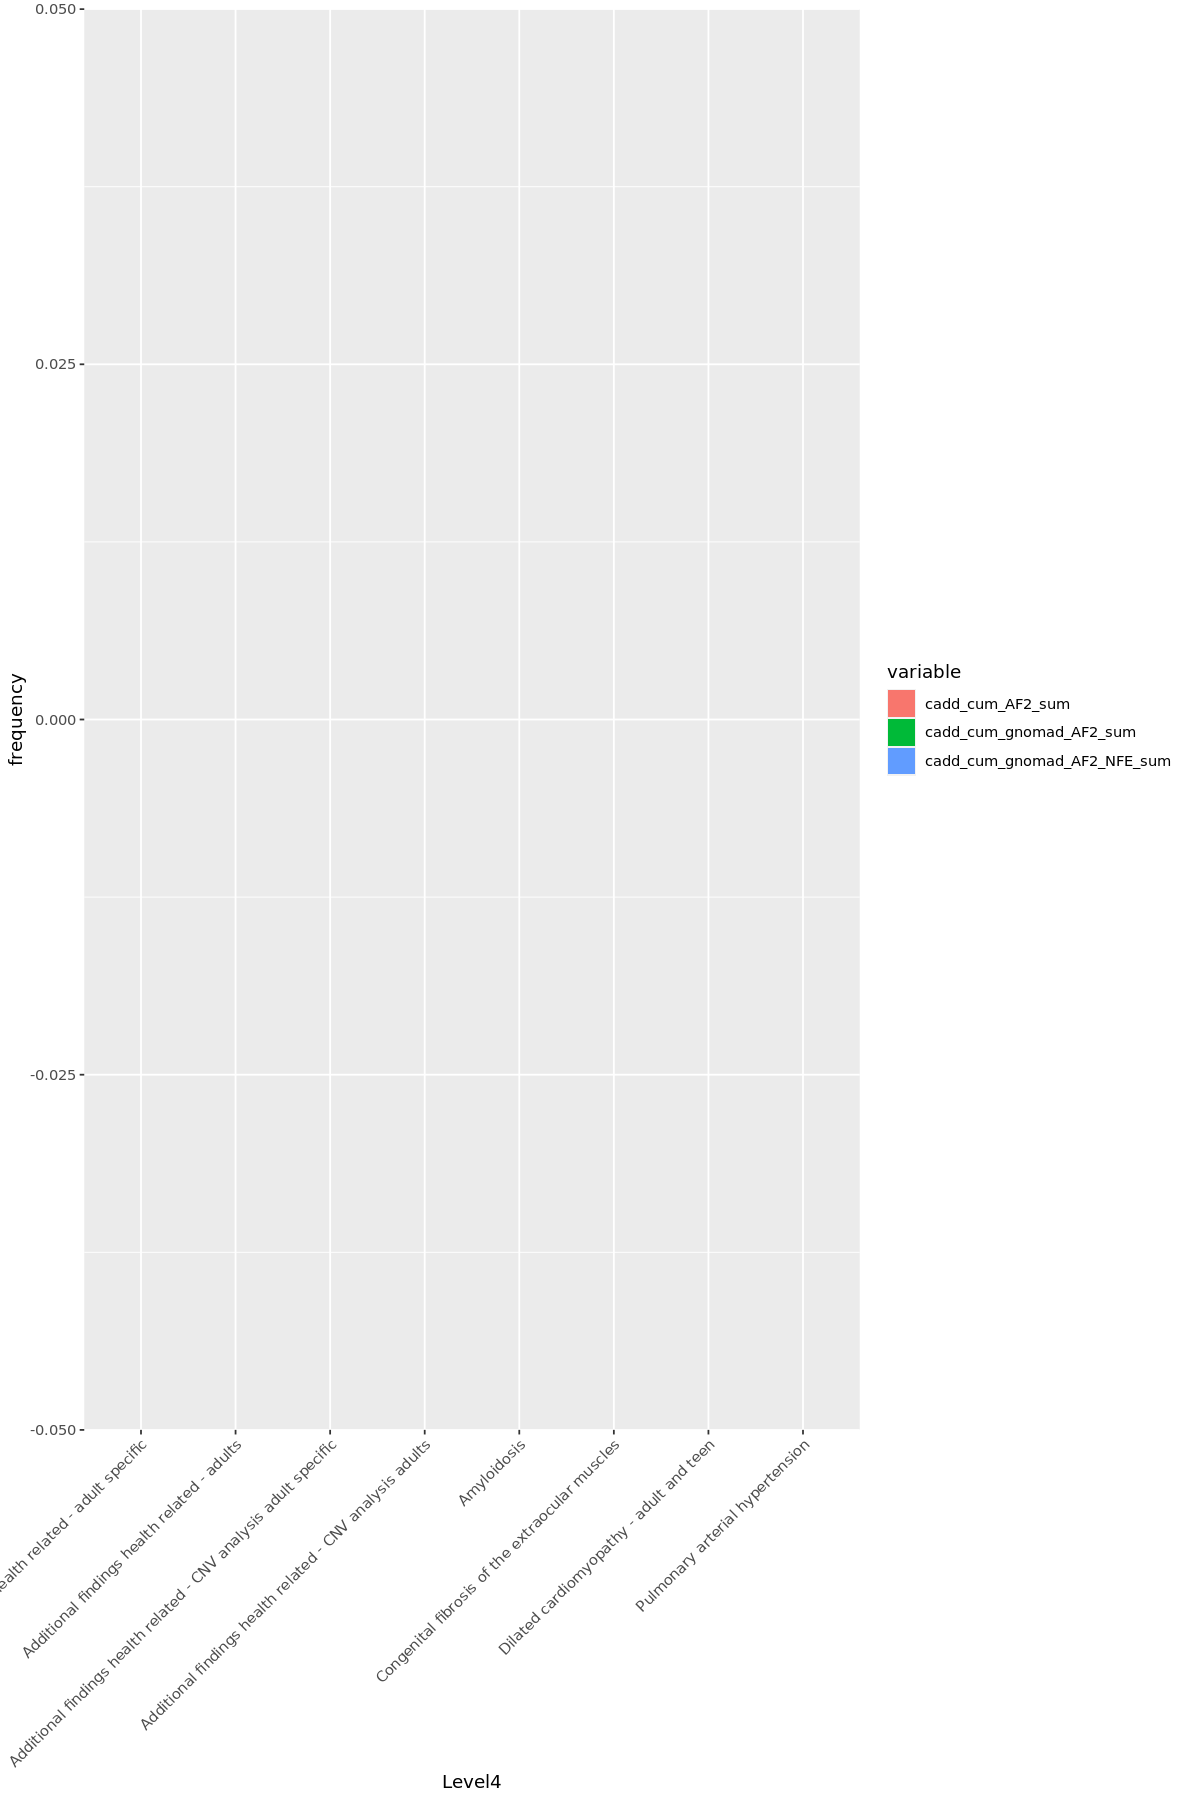

In [257]:
idx_list <- split(1:nrow(allPanelsDT3_unique), 1:10)

allPanelsDT3_unique <- allPanelsDT3_unique[order(cadd_cum_gnomad_AF2_sum, decreasing=T)]
lapply(1:25, function(i){
    start <- ((i-1)*10+1)
    idx <- c(start:min(nrow(allPanelsDT3_unique),start+10))
    
#melt_panel_clinvar <- melt(allPanelsDT3_unique[idx],  measure.vars = c("clinvar_cum_AF2_sum", "clinvar_cum_gnomad_AF2_sum", "clinvar_cum_gnomad_AF2_NFE_sum"), value.name = c("frequency"))
melt_panel_cadd <- melt(allPanelsDT3_unique[idx],  measure.vars = c("cadd_cum_AF2_sum", "cadd_cum_gnomad_AF2_sum", "cadd_cum_gnomad_AF2_NFE_sum"), value.name = c("frequency"))

#library(repr)
#options(repr.plot.width=10, repr.plot.height=15)

p1 <- ggplot(data=melt_panel_cadd, aes(x=Level4, y=frequency, fill=variable)) +
    geom_bar(stat="identity", position=position_dodge()) +
    theme(axis.text.x = element_text(angle = 45, hjust=1))

p1
})




# OLD analysis:

In [5]:
# Conseuqneces summary
csq_table <- as.data.table(table(tgp_vep$Consequence))
head(csq_table)

ERROR: Error in table(tgp_vep$Consequence): object 'tgp_vep' not found


In [14]:
# Select "main" consequence per each row 
csq_table$csq_first <- sapply(strsplit(csq_table$V1, ","), `[`, 1)
csq_first <- as.data.table(csq_table %>% mutate(csq_first = toupper(csq_first)) %>% 
    group_by(csq_first) %>% summarise(N = sum(N)))
dim(csq_first)
head(csq_first)

[1] 24  2

csq_first                         N      
1 3_PRIME_UTR_VARIANT                341486
2 5_PRIME_UTR_VARIANT                 57721
3 CODING_SEQUENCE_VARIANT                 9
4 DOWNSTREAM_GENE_VARIANT           2131350
5 FRAMESHIFT_VARIANT                   4416
6 INCOMPLETE_TERMINAL_CODON_VARIANT       4

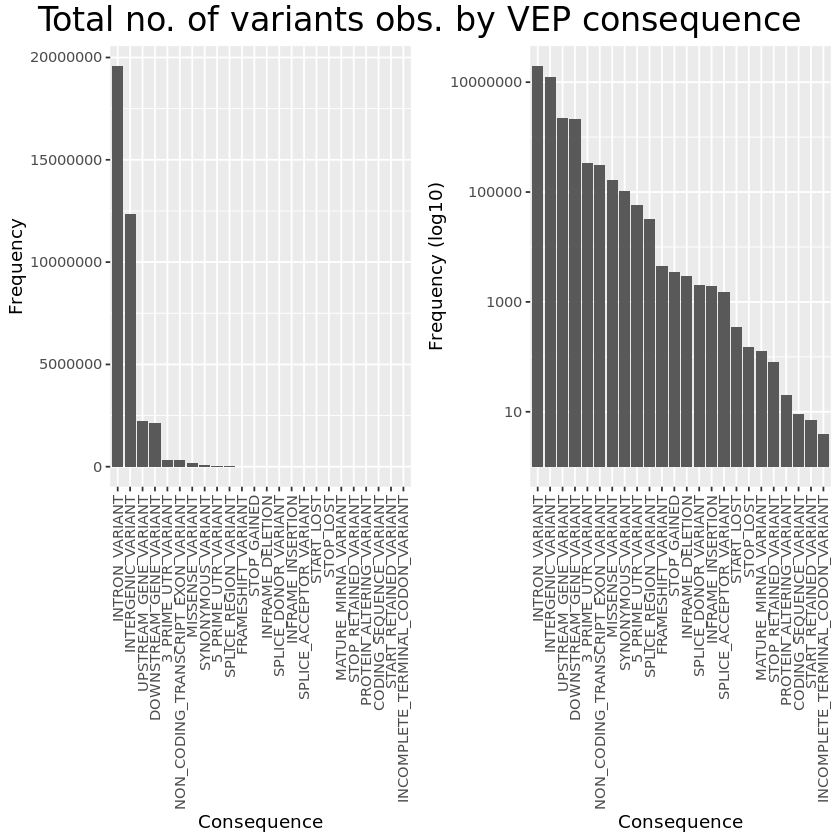

In [15]:
# Plot consequences
p1 <- ggplot(csq_first, aes(reorder(csq_first, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 90)) +
    scale_y_log10() +
    labs(x = "Consequence", y = "Frequency (log10)")
p2 <- ggplot(csq_first, aes(reorder(csq_first, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 90)) +
    labs(x = "Consequence", y = "Frequency")
    #theme(plot.title = "Liczba wariantów dla poszczególnych głownych konsekwencji", axis.title.x = element_blank(), axis.title.y = element_blank())


grid.arrange(p2, p1, nrow = 1, top = textGrob("Total no. of variants obs. by VEP consequence",gp=gpar(fontsize=20)))

In [176]:
# Recessive clinvar pathogenic/likely pathogenic variants
clinvar_recessive <- tgp_vep[which(Symbol %in% omim_recessive$symbol & CLNSIG %in% c("Pathogenic", "Pathogenic/Likely_pathogenic", "Likely_pathogenic)"))]

In [142]:
dim(tgp_vep[which(AC==0)])

[1] 429163    154

In [ ]:
# 10 variants with AC=0
dim(clinvar_recessive)
dim(clinvar_recessive[which(AC>0)])
head(clinvar_recessive[which(AC==0)])

In [150]:
table(clinvar_recessive[,Consequence])


                                        5_prime_UTR_variant 
                                                          3 
                                    downstream_gene_variant 
                                                         12 
                                         frameshift_variant 
                                                        118 
                   frameshift_variant,splice_region_variant 
                                                          3 
                                           inframe_deletion 
                                                          6 
                                          inframe_insertion 
                                                          1 
                                             intron_variant 
                                                         18 
                                           missense_variant 
                                                        251 
                     mi

In [177]:
clinvar_recessive[which(Consequence == "upstream_gene_variant"),ClinVar_url]

[1] "https://www.ncbi.nlm.nih.gov/clinvar/variation/12076/" 
 [2] "https://www.ncbi.nlm.nih.gov/clinvar/variation/265135/"
 [3] "https://www.ncbi.nlm.nih.gov/clinvar/variation/626999/"
 [4] "https://www.ncbi.nlm.nih.gov/clinvar/variation/116/"   
 [5] "https://www.ncbi.nlm.nih.gov/clinvar/variation/188834/"
 [6] "https://www.ncbi.nlm.nih.gov/clinvar/variation/573257/"
 [7] "https://www.ncbi.nlm.nih.gov/clinvar/variation/162203/"
 [8] "https://www.ncbi.nlm.nih.gov/clinvar/variation/223044/"
 [9] "https://www.ncbi.nlm.nih.gov/clinvar/variation/16663/" 
[10] "https://www.ncbi.nlm.nih.gov/clinvar/variation/223019/"
[11] "https://www.ncbi.nlm.nih.gov/clinvar/variation/31077/"

In [ ]:
dim(clinvar_recessive[which(AF > gnomAD_AF_NFE), c("key","gnomAD_AF","gnomAD_AF_NFE", "AF")])
head(clinvar_recessive[which(AF > gnomAD_AF_NFE), c("key","gnomAD_AF","gnomAD_AF_NFE", "AF")])

In [179]:
clinvar_gene_table <- as.data.table(sort(table(clinvar_recessive$Symbol), decreasing = TRUE))

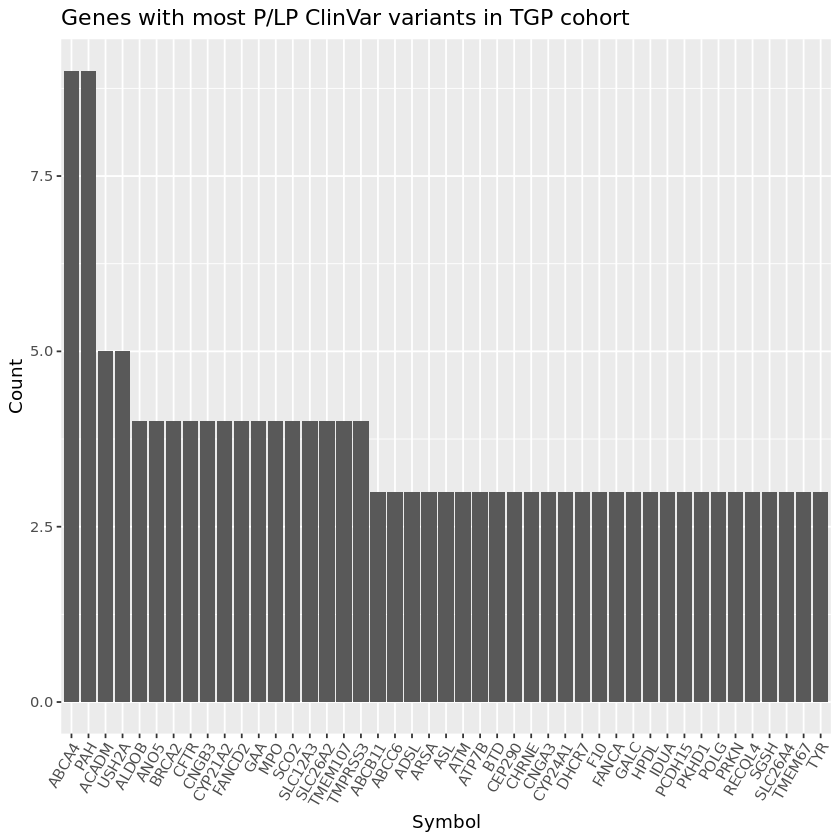

In [182]:
# Genes with the highest number of Clinvar pathogenic varianst
clinvar_gene_table_2 <- clinvar_gene_table[which(N > 2)]
ggplot(clinvar_gene_table[which(N > 2)], aes(reorder(V1, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 60)) +
    labs(title = "Genes with most P/LP ClinVar variants in TGP cohort", x = "Symbol", y = "Count")

In [184]:
clinvar_recessive$AF <- as.numeric(clinvar_recessive$AF)

In [185]:
melt_clinvar <- melt(clinvar_recessive, id.vars = c("key2"), measure.vars = c("gnomAD_AF", "gnomAD_AF_NFE", "AF"), variable.name = c("database"), value.name = c("frequency"))

In [187]:
dim(melt_clinvar)
#head(melt_clinvar)

[1] 1944    3

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 211 rows containing non-finite values (stat_boxplot).”

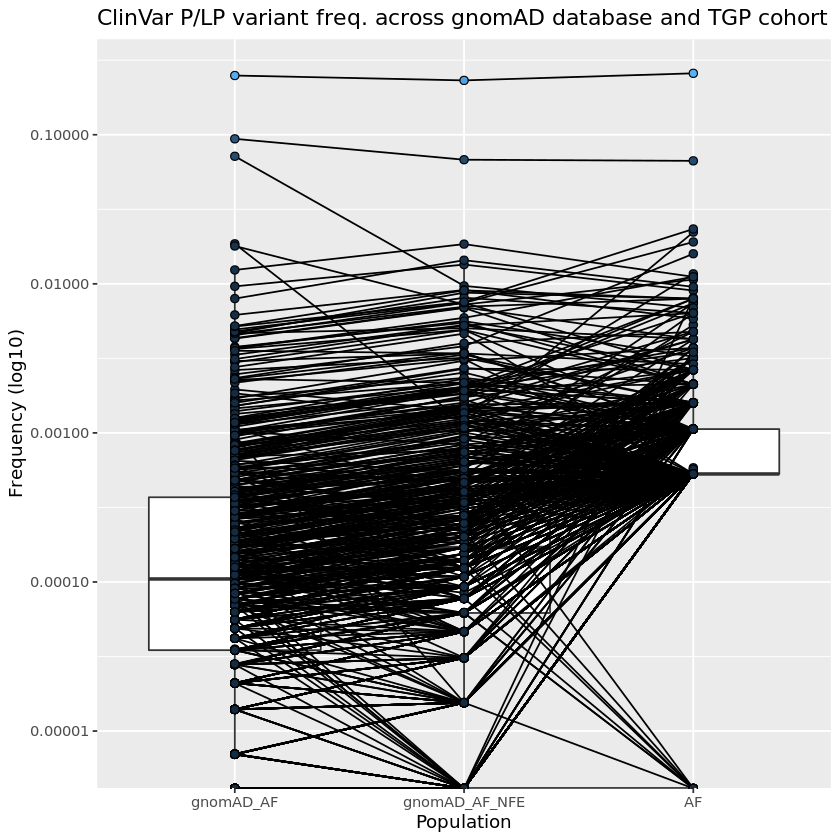

In [188]:
ggplot(melt_clinvar, aes(database,frequency, fill=frequency)) +
    geom_boxplot() +
    geom_line(aes(group=key2)) +
    geom_point(aes(fill=frequency,group=database),size=2,shape=21, position = position_dodge(0.2)) +
    theme(legend.position = "none") +
    scale_y_log10() +
    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

In [191]:
clinvar_recessive_overrep_TGP <- clinvar_recessive[which(AF > gnomAD_AF_NFE & AF > gnomAD_AF), c("key2","gnomAD_AF","gnomAD_AF_NFE", "AF")]
#head(clinvar_recessive_overrep_TGP)
melt_clinvar_overrep_TGP <- melt(clinvar_recessive_overrep_TGP, id.vars = c("key2"), measure.vars = c("gnomAD_AF", "gnomAD_AF_NFE", "AF"), variable.name = c("database"), value.name = c("frequency"))
#head(melt_clinvar_overrep_TGP)

In [192]:
clinvar_recessive_diff <- clinvar_recessive[, diff_AF := gnomAD_AF - AF][, diff_AF_NFE := gnomAD_AF_NFE - AF]

In [194]:
#head(clinvar_recessive_diff[which(diff_AF < 0 & diff_AF_NFE < 0), c("key","gnomAD_AF","gnomAD_AF_NFE", "AF", "diff_AF", "diff_AF_NFE")])
dim(clinvar_recessive_diff[which(diff_AF < 0 & diff_AF_NFE < 0)])

[1] 551 156

In [196]:
#ggplot(clinvar_recessive_overrep_TGP, aes(database, frequency, fill = frequency)) +
#    geom_boxplot() +
#    geom_line(aes(group = key2)) +
#    geom_point(aes(fill = frequency, group = database), size = 2, shape = 21, position = position_dodge(0.2)) +
#    theme(legend.position = "none") +
#    scale_y_log10() +
#    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

#ggplot(clinvar_recessive_overrep_TGP, aes(x=database, y=frequency)) +
#    geom_boxplot() +
#    geom_jitter(colour="lightblue", height = 0) +
#    scale_y_log10() +
#    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 211 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 211 rows containing missing values (geom_point).”

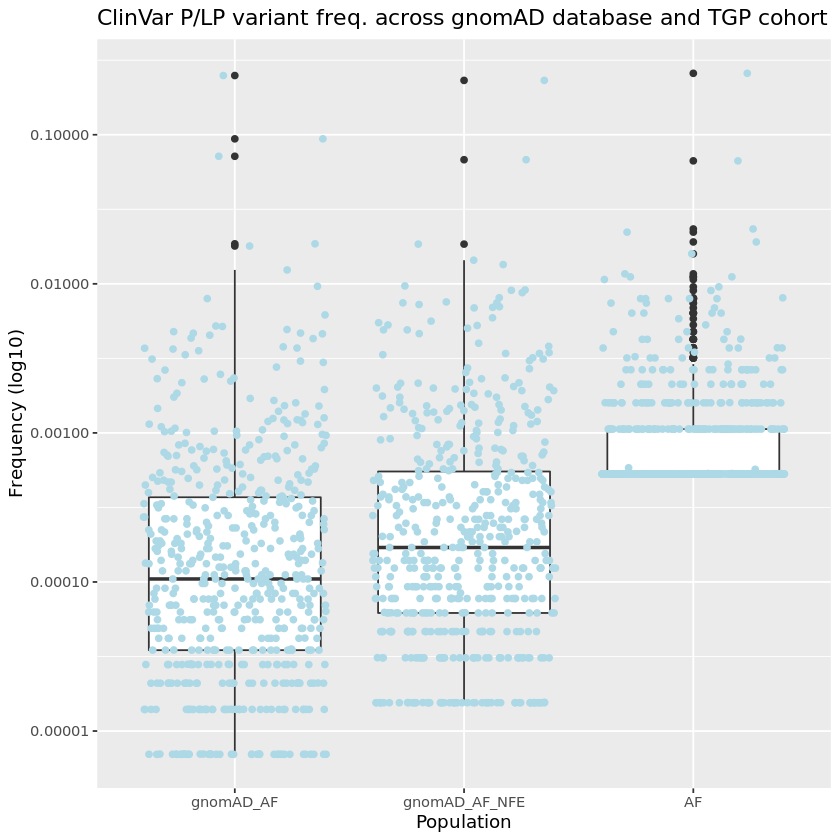

In [197]:
ggplot(melt_clinvar, aes(x=database, y=frequency)) +
    geom_boxplot() +
    geom_jitter(colour="lightblue", height = 0) +
    scale_y_log10() +
    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 211 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 211 rows containing non-finite values (stat_sum).”

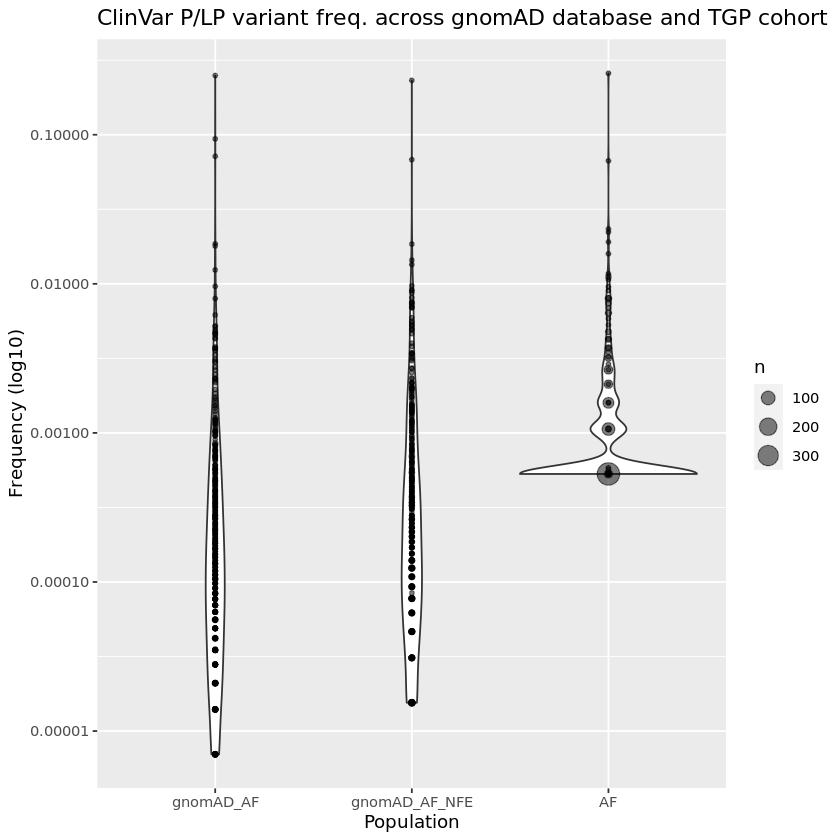

In [198]:
ggplot(melt_clinvar, aes(x=database, y=frequency)) +
    geom_violin() +
    geom_count(alpha=0.5) +
    scale_y_log10() +
    labs(title = "ClinVar P/LP variant freq. across gnomAD database and TGP cohort", x = "Population", y = "Frequency (log10)")

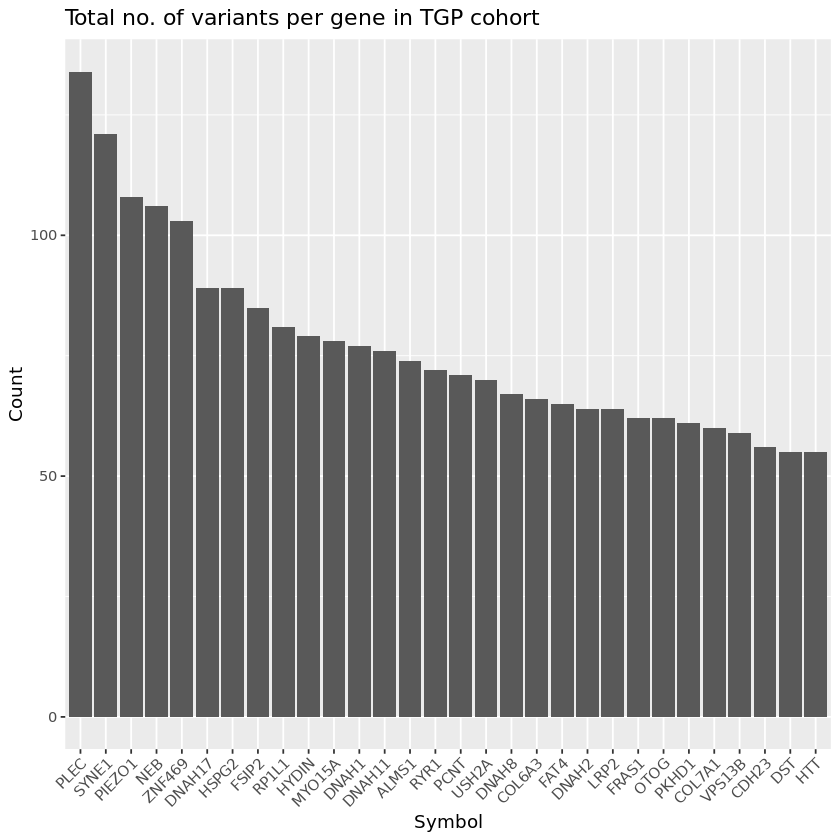

In [201]:
tgp_vep_gene_table <- as.data.table(sort(table(tgp_vep_nonsyn_rare$Symbol), decreasing = TRUE))
ggplot(tgp_vep_gene_table[2:31], aes(reorder(V1, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 45)) +
    labs(title = "Total no. of variants per gene in TGP cohort", x = "Symbol", y = "Count")

In [204]:
tgp_vep_gene_table_singleton <- as.data.table(sort(table(tgp_vep_nonsyn_rare[which(AF < 0.01 & AC == 1)]$Symbol), decreasing = TRUE))

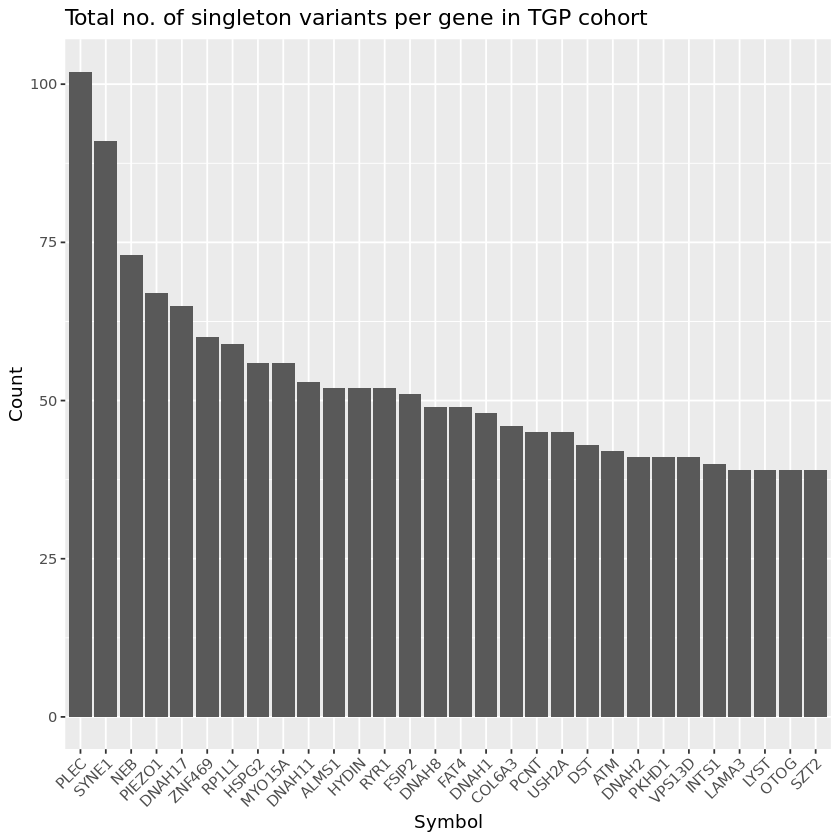

In [205]:
ggplot(tgp_vep_gene_table_singleton[2:31], aes(reorder(V1, -N), N)) + 
    geom_col() +
    scale_x_discrete(guide = guide_axis(angle = 45)) +
    labs(title = "Total no. of singleton variants per gene in TGP cohort", x = "Symbol", y = "Count")